# 0.0. Imports

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import random
import warnings
import xgboost as xgb
import pickle
from lightgbm import LGBMClassifier
from boruta import BorutaPy
from scipy.stats import chi2_contingency
from scikitplot import metrics as mt 
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from IPython.core.display import HTML

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [64]:

def percentage(ax, total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height,
                '{:1.2f}%'.format(height/total*100),
                ha="center")
    plt.show()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / (min(kcorr-1, rcorr-1) ) )

def ml_performance(model_name, y_test, yhat):
    accuracy = m.accuracy_score(y_test, yhat)
    kappa = m.cohen_kappa_score(y_test, yhat)
    precision = m.precision_score(y_test, yhat)
    recall = m.recall_score(y_test, yhat)
    roc = m.roc_auc_score(y_test, yhat)
    f1score = m.f1_score(y_test, yhat)
    
    return pd.DataFrame({'Model Name': model_name,
                        'Accuracy': accuracy,
                        'Kappa': kappa,
                        'Precision': precision,
                        'Recall': recall,
                        'ROC': roc,
                        'F1-Score': f1score}, index = [0])

def cross_validation(model_name, model, y_test, yhat, kfold, verbose = False, random_state = 42):
    accuracy_list = []
    kappa_list = []
    precision_list = []
    recall_list = []
    roc_list = []
    f1_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # model
        m = model.fit(X_train, y_train)
        
        # prediction
        yhat = m.predict(X_test)
        
        # performance
        m_result = ml_performance(model_name, y_test, yhat)
        
        # store performance of each kfold iteration
        accuracy_list.append(m_result['Accuracy'])
        kappa_list.append(m_result['Kappa'])
        precision_list.append(m_result['Precision'])
        recall_list.append(m_result['Recall'])
        roc_list.append(m_result['ROC'])
        f1_list.append(m_result['F1-Score'])
    
    return pd.DataFrame({'Model Name': model_name,
                        'Accuracy CV': np.round(np.mean(accuracy_list), 3).astype(str) + '+/-' + np.round(np.std(accuracy_list), 5).astype(str),
                        'Kappa CV': np.round(np.mean(kappa_list), 3).astype(str) + '+/-' + np.round(np.std(kappa_list), 5).astype(str),
                        'Precision CV': np.round(np.mean(precision_list), 3).astype(str) + '+/-' + np.round(np.std(precision_list), 5).astype(str),
                        'Recall CV': np.round(np.mean(recall_list), 3).astype(str) + '+/-' + np.round(np.std(recall_list), 5).astype(str),
                        'ROC CV': np.round(np.mean(roc_list), 3).astype(str) + '+/-' + np.round(np.std(roc_list), 5).astype(str),
                        'F1-Score CV': np.round(np.mean(f1_list), 3).astype(str) + '+/-' + np.round(np.std(f1_list), 5).astype(str)}, index = [0])

def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # set pandas for desired number of decimal places
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

jupyter_settings()

## 0.2. Loading Data

In [65]:
df_raw = pd.read_csv('../data/raw/cardio_train.csv', sep = ';')
df_raw.shape

(70000, 13)

# 1.0. Data Description

In [66]:
df1 = df_raw.copy()
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.00,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.00,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.00,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.00,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.00,100,60,1,1,0,0,0,0


## 1.1. Data Dimension

In [67]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 70000
Number of columns: 13


## 1.2. Data Types & NA Check

In [68]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [69]:
# convert 'age' from days to years
df1['age'] = df1['age'] / 365
df1['age'] = df1['age'].round().astype(np.int64)

# convert 'height' from cm to m
df1['height'] = df1['height'] / 100

# convert 'weight' from float to int64
# df1['weight'] = df1['weight'].astype(np.int64)
# df1.info()

In [70]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,1.68,62.00,110,80,1,1,0,0,1,0
1,1,55,1,1.56,85.00,140,90,3,1,0,0,1,1
2,2,52,1,1.65,64.00,130,70,3,1,0,0,0,1
3,3,48,2,1.69,82.00,150,100,1,1,0,0,1,1
4,4,48,1,1.56,56.00,100,60,1,1,0,0,0,0


In [71]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  float64
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 6.9 MB


## 1.3. Descriptive Statistics

In [72]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,1.68,62.00,110,80,1,1,0,0,1,0
1,1,55,1,1.56,85.00,140,90,3,1,0,0,1,1
2,2,52,1,1.65,64.00,130,70,3,1,0,0,0,1
3,3,48,2,1.69,82.00,150,100,1,1,0,0,1,1
4,4,48,1,1.56,56.00,100,60,1,1,0,0,0,0


In [73]:
# create a DataFrame with numerical attributes
num_attributes = df1.iloc[:, 1:7].drop(df1.columns[2], axis=1)

# create a DataFrame with categorical attributes
cat_attributes = df1.iloc[:, 7:12]
cat_attributes = pd.concat([cat_attributes, df1.iloc[:, [2]]], axis=1)

In [74]:
num_attributes.head()

,age,height,weight,ap_hi,ap_lo
0,50,1.68,62.00,110,80
1,55,1.56,85.00,140,90
2,52,1.65,64.00,130,70
3,48,1.69,82.00,150,100
4,48,1.56,56.00,100,60


In [75]:
cat_attributes.head()

,cholesterol,gluc,smoke,alco,active,gender
0,1,1,0,0,1,2
1,3,1,0,0,1,1
2,3,1,0,0,0,1
3,1,1,0,0,1,2
4,1,1,0,0,0,1


### 1.3.1. Numerical Attributes

In [76]:
# central tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,30.00,65.00,35.00,53.34,54.00,6.77,-0.31,-0.82
1,height,0.55,2.50,1.95,1.64,1.65,0.08,-0.64,7.94
2,weight,10.00,200.00,190.00,74.21,72.00,14.40,1.01,2.59
3,ap_hi,-150.00,16020.00,16170.00,128.82,120.00,154.01,85.30,7580.07
4,ap_lo,-70.00,11000.00,11070.00,96.63,80.00,188.47,32.11,1425.91


### 1.3.2. Categorical Attributes

In [77]:
cat_attributes.apply(lambda x: x.unique().shape[0])

cholesterol    3
gluc           3
smoke          2
alco           2
active         2
gender         2
dtype: int64

In [78]:
df1['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

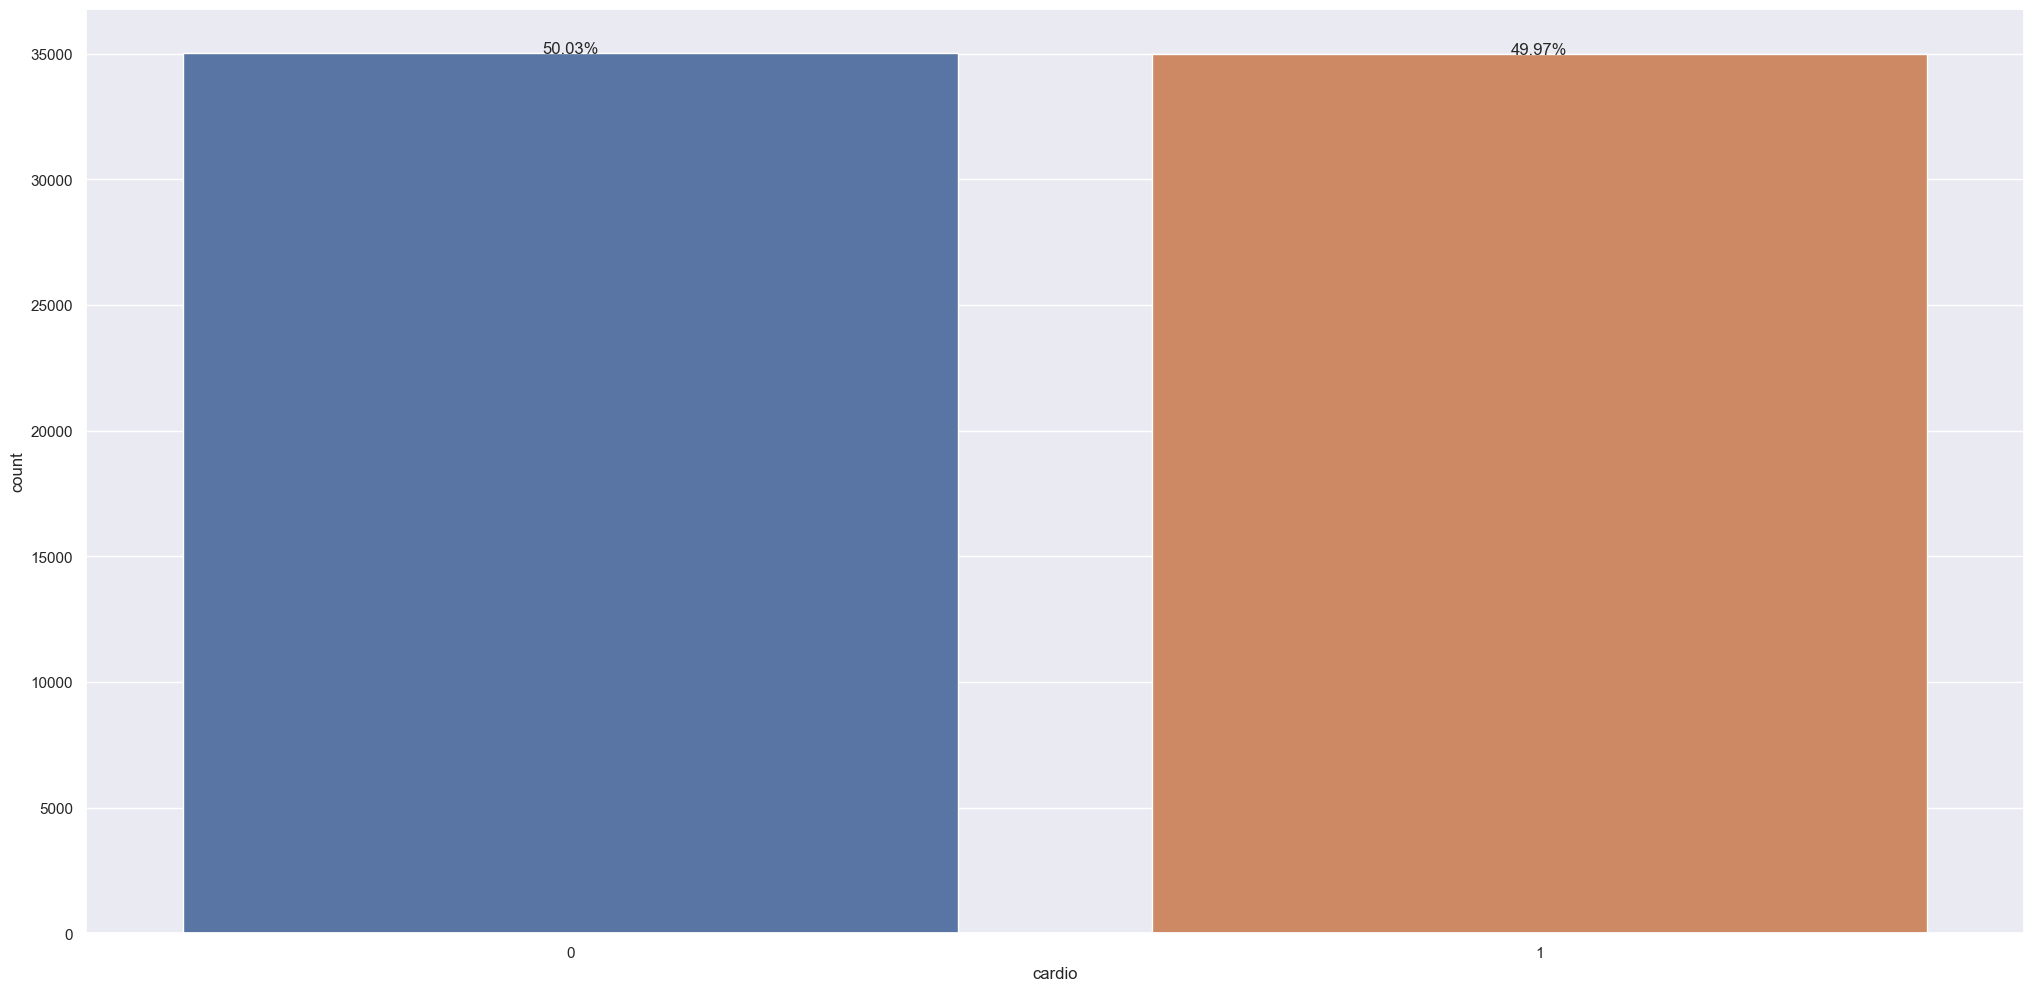

In [79]:
counts = df1['cardio'].value_counts()
ax = sns.countplot(x='cardio', data=df1)
total = counts.sum()

percentage(ax, total);

In [80]:
df1.apply(lambda x: x.unique().shape[0])

id             70000
age               28
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

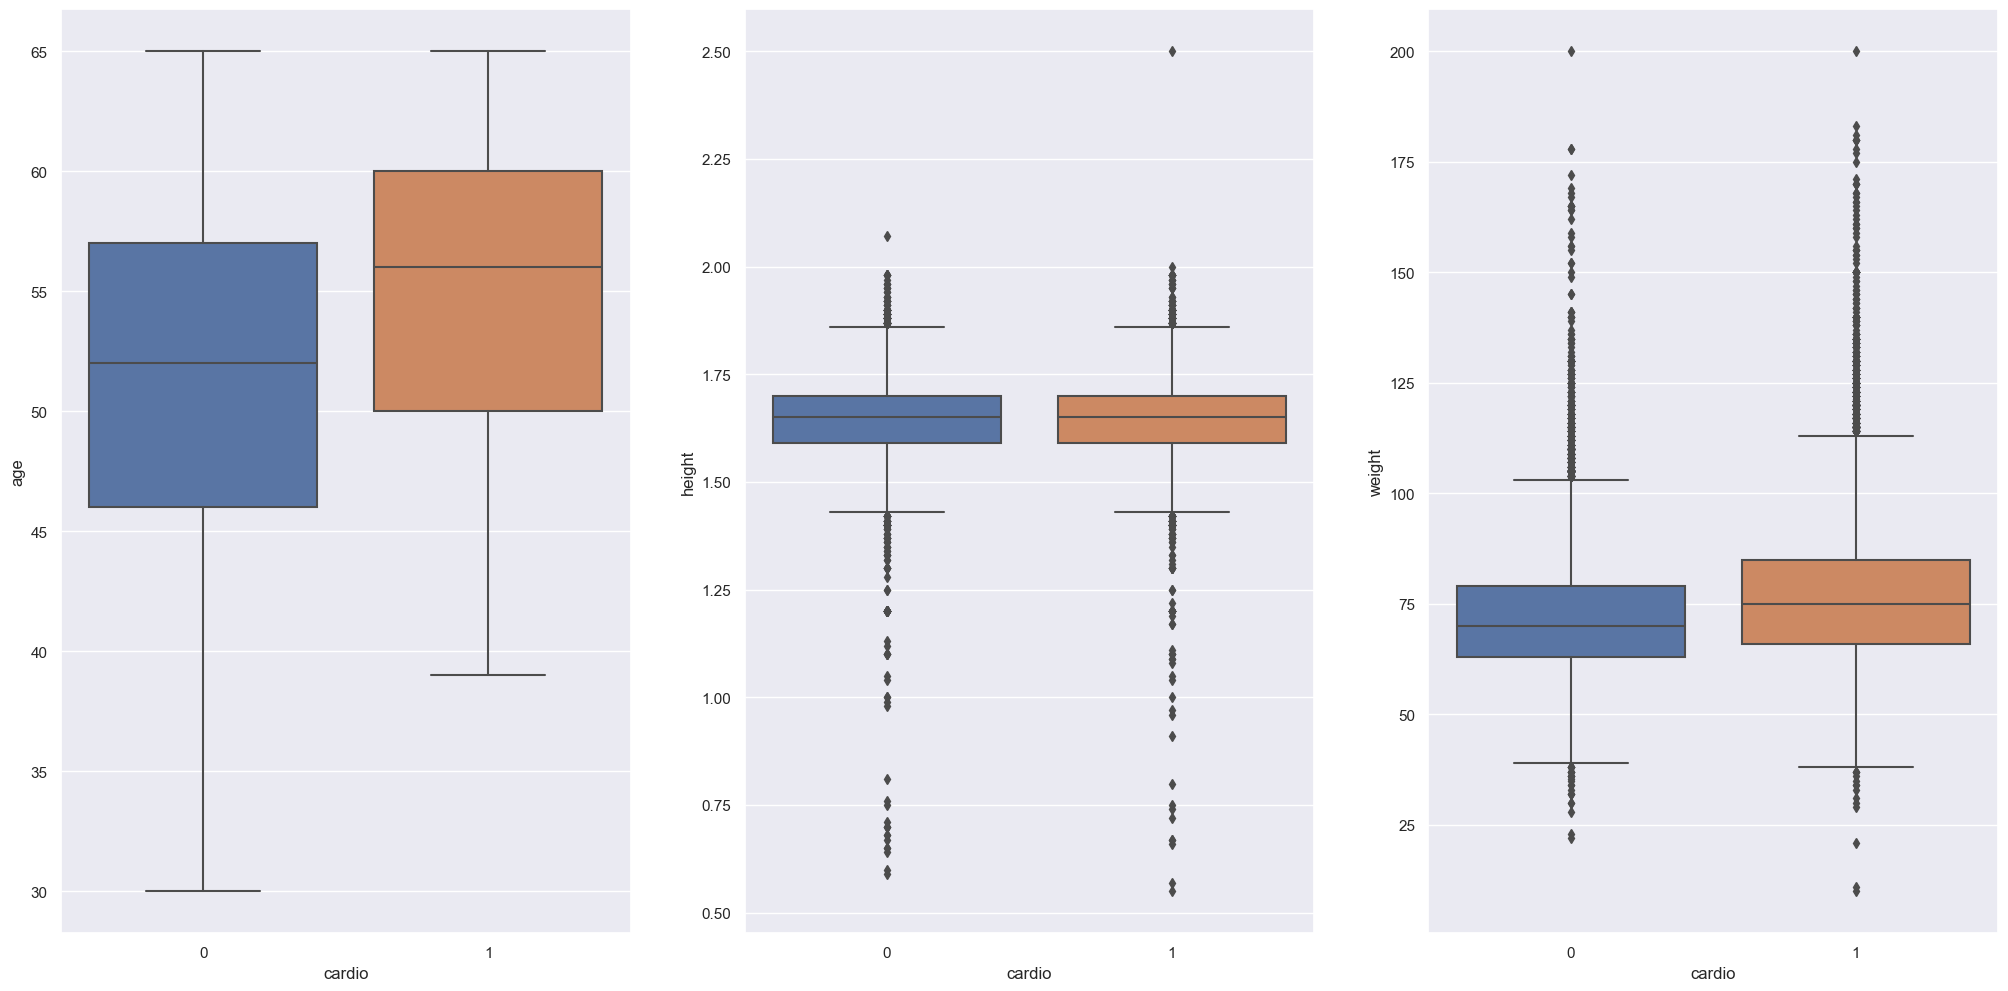

In [81]:
plt.subplot(1, 3, 1)
sns.boxplot(x='cardio', y='age', data=df1)

plt.subplot(1, 3, 2)
sns.boxplot(x='cardio', y='height', data=df1)

plt.subplot(1, 3, 3)
sns.boxplot(x='cardio', y='weight', data=df1);


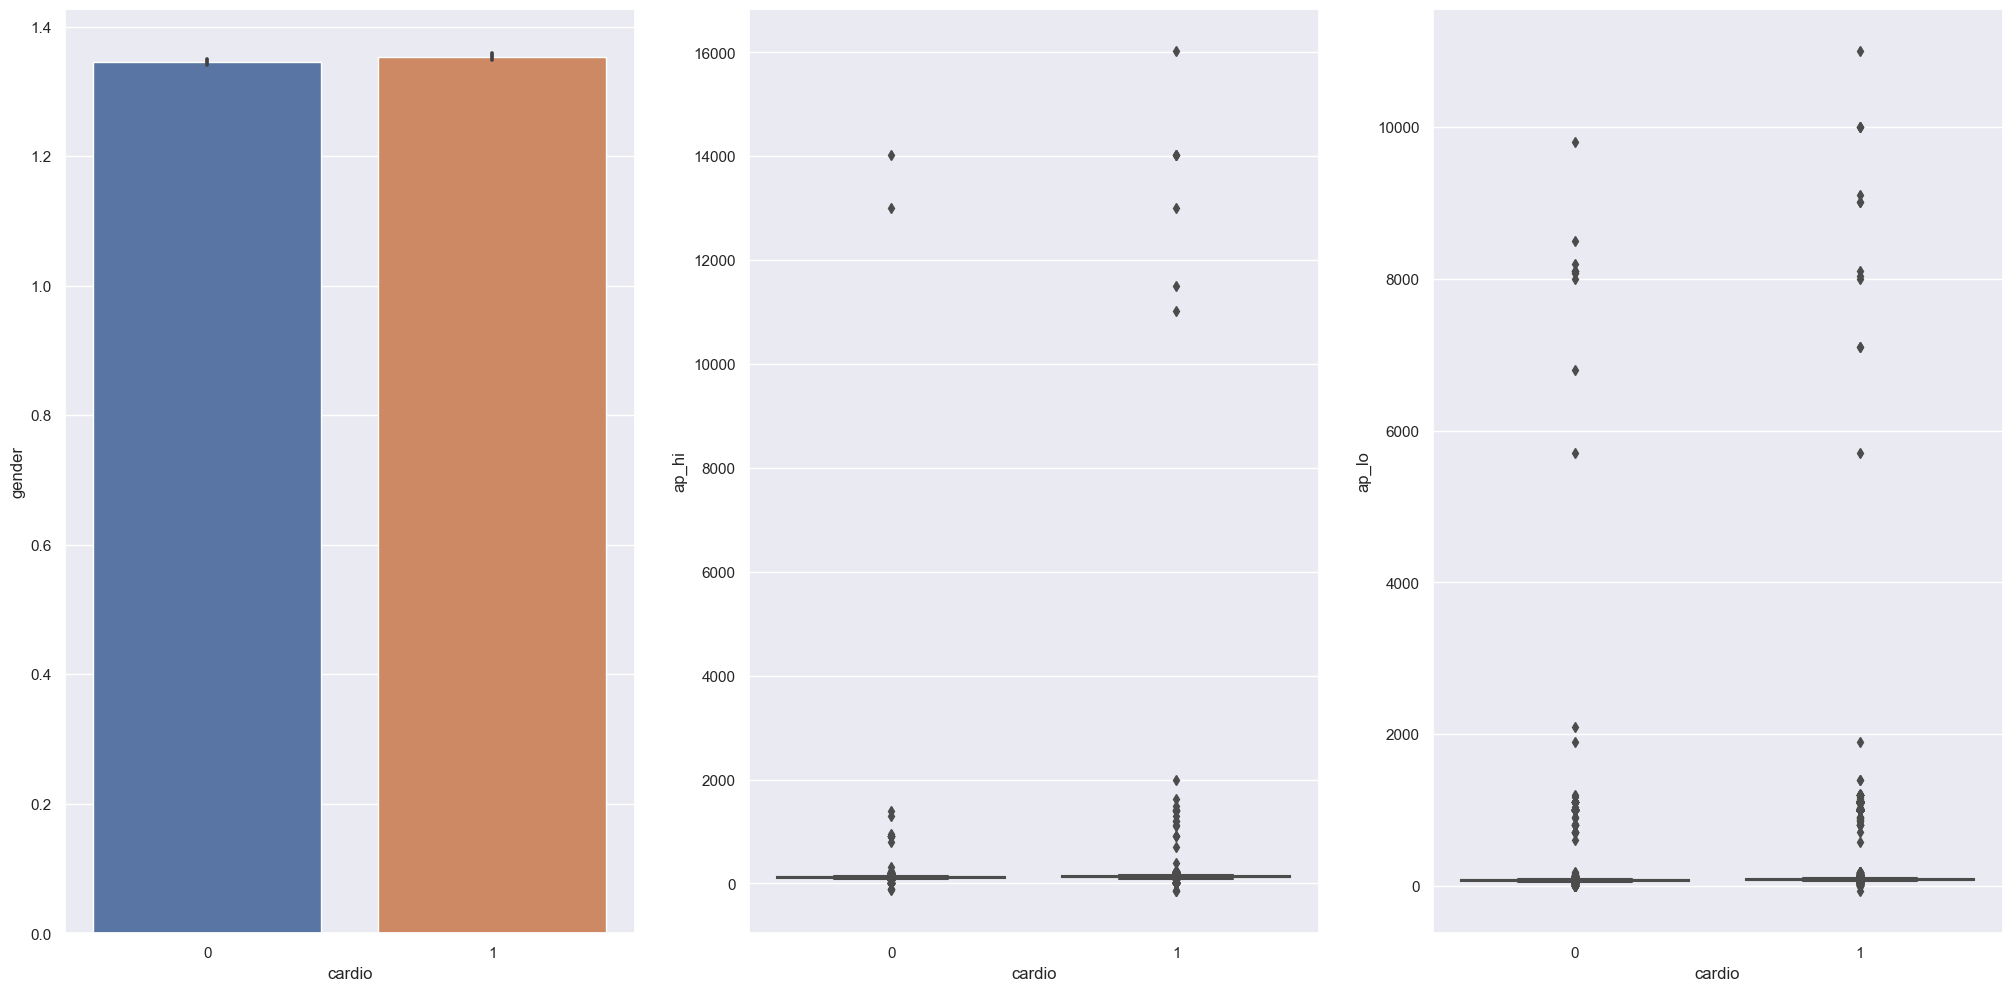

In [82]:
plt.subplot(1, 3, 1)
sns.barplot(x='cardio', y='gender', data=df1)

plt.subplot(1, 3, 2)
sns.boxplot(x='cardio', y='ap_hi', data=df1)

plt.subplot(1, 3, 3)
sns.boxplot(x='cardio', y='ap_lo', data=df1);

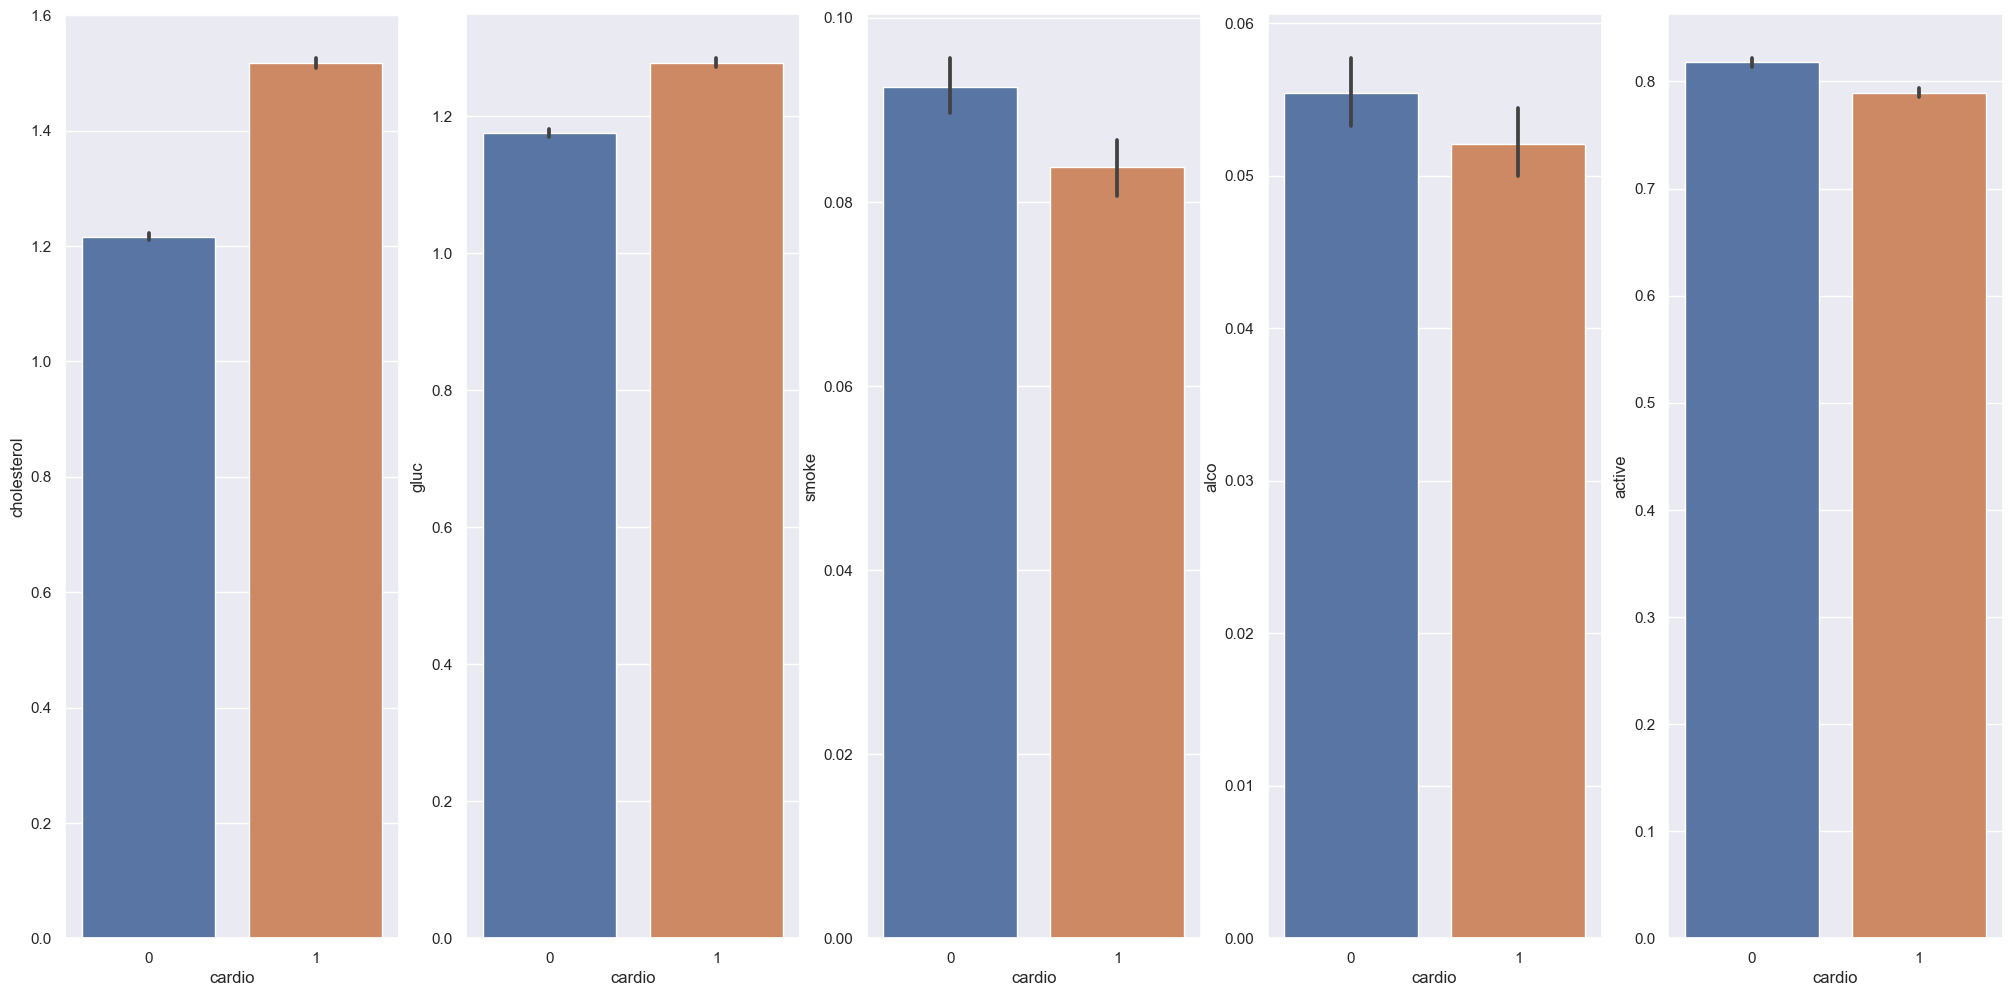

In [83]:
plt.subplot(1, 5, 1)
sns.barplot(x='cardio', y='cholesterol', data=df1)

plt.subplot(1, 5, 2)
sns.barplot(x='cardio', y='gluc', data=df1)

plt.subplot(1, 5, 3)
sns.barplot(x='cardio', y='smoke', data=df1)

plt.subplot(1, 5, 4)
sns.barplot(x='cardio', y='alco', data=df1)

plt.subplot(1, 5, 5)
sns.barplot(x='cardio', y='active', data=df1);

# 2.0. Feature Engineering

In [84]:
df2 = df1.copy()

## 2.1. Hypothesis Testing: mind map

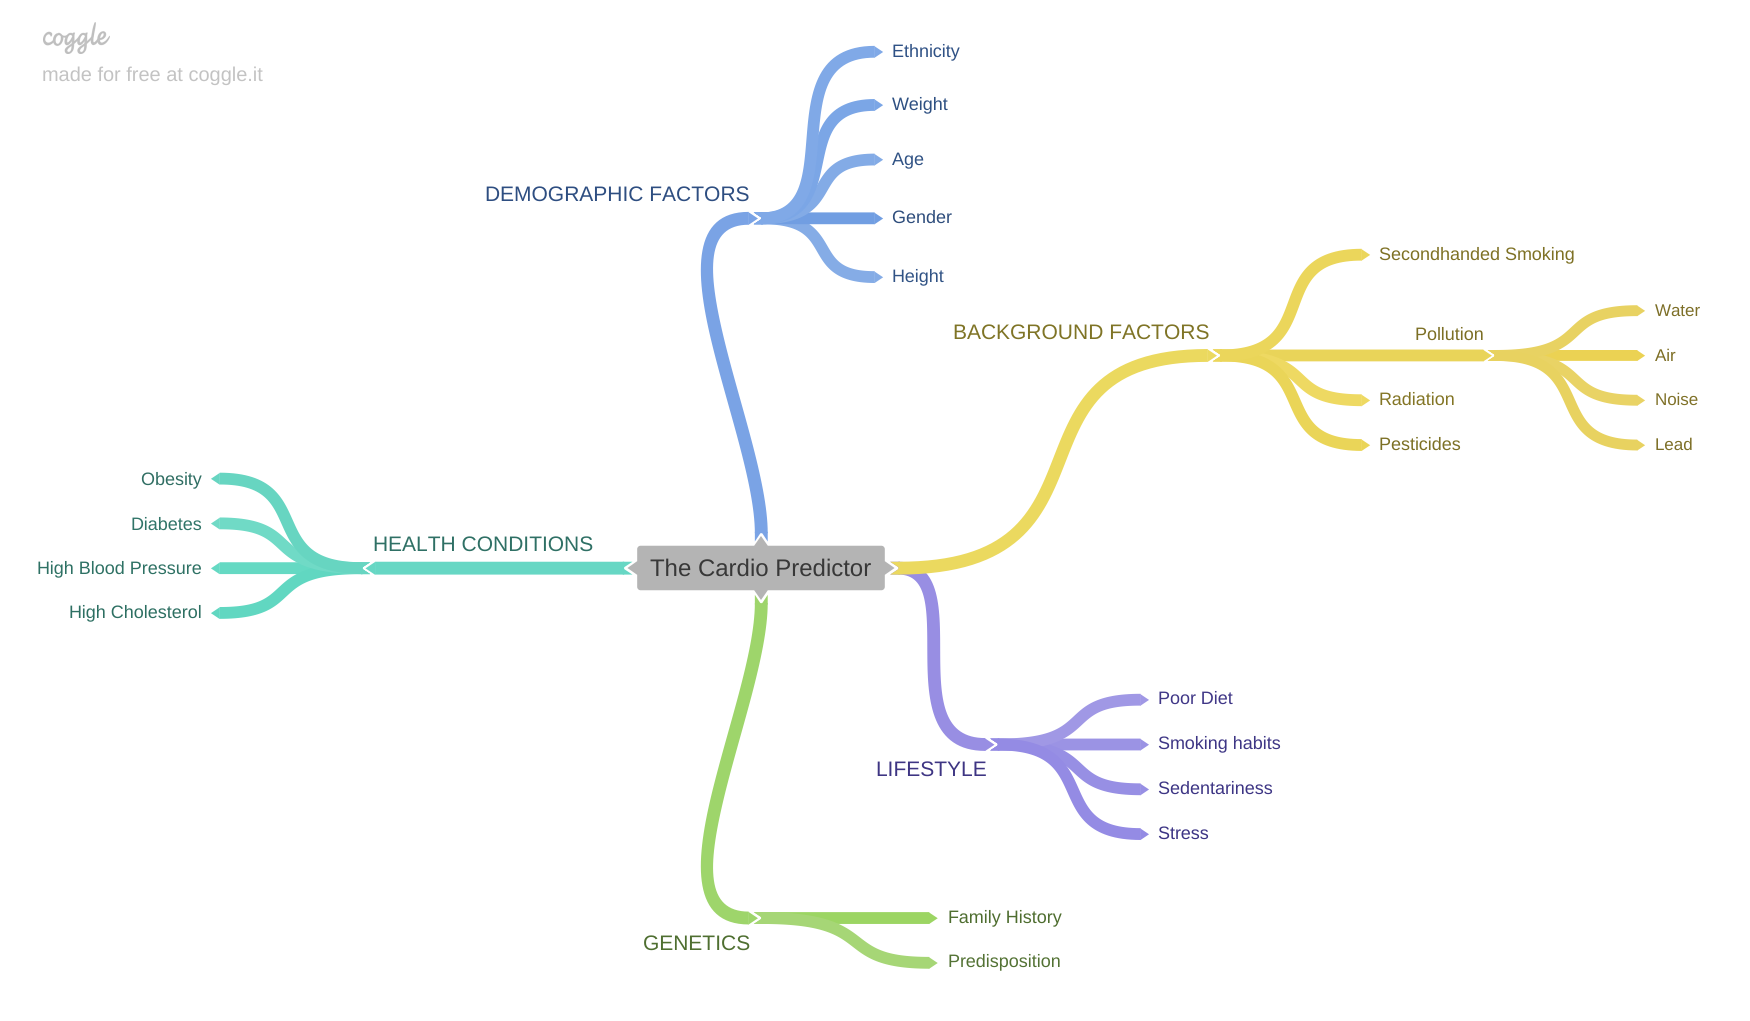

In [85]:
Image('../reports/figures/map_cardio.png')

## 2.2. Hypothesis Creation

In [86]:
df2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,1.68,62.00,110,80,1,1,0,0,1,0
1,1,55,1,1.56,85.00,140,90,3,1,0,0,1,1
2,2,52,1,1.65,64.00,130,70,3,1,0,0,0,1
3,3,48,2,1.69,82.00,150,100,1,1,0,0,1,1
4,4,48,1,1.56,56.00,100,60,1,1,0,0,0,0


### 2.2.1. Demographics Factors
- Age is positively correlated with the risk of cardiovascular disease.
- The incidence of cardiovascular disease is higher in males compared to females.
- Individuals who are overweight and short are at a higher risk of developing cardiovascular disease than those who are tall and underweight.

### 2.2.2. Background Factors
- The risk of cardiovascular disease is positively correlated with the BMI level.

### 2.2.3. Lifestyle
- Smoking is positively correlated with the risk of cardiovascular disease.
- Alcohol consumption is positively correlated with the risk of cardiovascular disease.
- A lack of physical activity is positively correlated with the risk of cardiovascular disease.

### 2.2.4. Genetics
- Certain ethnic groups have a higher incidence of cardiovascular disease.

### 2.2.5. Health Conditions
- High systolic blood pressure is positively correlated with the risk of cardiovascular disease.
- High diastolic blood pressure is positively correlated with the risk of cardiovascular disease.
- Elevated cholesterol levels are positively correlated with the risk of cardiovascular disease.
- High glucose levels are positively correlated with the risk of cardiovascular disease.

## 2.3. Final List of Hypothesis

**H01**: the incidence of cardiovascular disease is at least 30% disease higher in one of the genders.

**H02**: age is positively correlated with the risk of cardiovascular diseases.

**H03**: individuals who are overweight and short are at a higher risk of developing cardiovascular disease than those who are tall but underweight.

**H04**: people with Dwarfism condition are not necessarily prone to develop cardiovascular diseases.

**H05**: smoking is a predictor for cardiovascular diseases development.

**H06**: people who have high blood pressure are more prone to develop cardiovascular diseases than those with normal blood pressure.

**H07**: people who have high cholesterol levels are more prone to develop cardiovascular diseases than those with normal cholesterol levels.

**H08**: being physically active decreases the risk of developing cardiovascular diseases.

**H09**: being physically active, even as a smoker, do not decreases the risk of developing cardiovascular diseases.

**H10**: being physically active, even if the person continue drinking alcohol, decreases the risk of developing cardiovascular diseases.

## 2.4. Feature Engineering

In [87]:
df2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,1.68,62.00,110,80,1,1,0,0,1,0
1,1,55,1,1.56,85.00,140,90,3,1,0,0,1,1
2,2,52,1,1.65,64.00,130,70,3,1,0,0,0,1
3,3,48,2,1.69,82.00,150,100,1,1,0,0,1,1
4,4,48,1,1.56,56.00,100,60,1,1,0,0,0,0


In [88]:
# create BMI feature
'''
1 - underweight
2 - healthy weight
3 - overweight
4 - obese
'''
df2['bmi'] = df2['weight'] / (df2['height'] * df2['height'])
df2['bmi'] = df2['bmi'].apply(lambda x: 1 if x < 18.5 else 
                            2 if x >= 18.5 and x <= 24.9 else 
                            3 if x >= 25.0 and x <= 29.9 else
                            4)
df2['bmi'].value_counts()

3    24877
2    24748
4    19725
1      650
Name: bmi, dtype: int64

In [89]:
# create blood pressure feature
'''
1 - Regular
2 - Elevated
3 - High Blood Pressure Stage 1
4 - High Blood Pressure Stage 2
5 - Hypertensive Crisis
'''

df2['blood_pressure'] = (df2['ap_hi'] + df2['ap_lo']) / 2

df2['blood_pressure'] = df2['blood_pressure'].apply(lambda x: 1 if x < 120 else 
                                                        2 if x >= 120 and x <= 129 else 
                                                        3 if x >= 130 and x <= 139 else 
                                                        4 if x >= 140 and x <= 159 else 
                                                        5)

df2['blood_pressure'].value_counts()

1    60114
2     6000
3     2014
5     1092
4      780
Name: blood_pressure, dtype: int64

In [90]:
df2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,blood_pressure
0,0,50,2,1.68,62.00,110,80,1,1,0,0,1,0,2,1
1,1,55,1,1.56,85.00,140,90,3,1,0,0,1,1,4,1
2,2,52,1,1.65,64.00,130,70,3,1,0,0,0,1,2,1
3,3,48,2,1.69,82.00,150,100,1,1,0,0,1,1,3,2
4,4,48,1,1.56,56.00,100,60,1,1,0,0,0,0,2,1


# 3.0. Data Filtering

In [91]:
df3 = df2.copy()

In [92]:
# filtefing by rows
df3 = df3[(df3['ap_lo'] >= 20) & (df3['ap_lo'] <= 150)]
df3 = df3[(df3['ap_hi'] >= 40) & (df3['ap_hi'] <= 300)]

# filtering by columns
df3 = df3.drop('id', axis=1)

In [93]:
df3.shape

(68775, 14)

# 4.0. Exploratory Data Analysis

In [94]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response

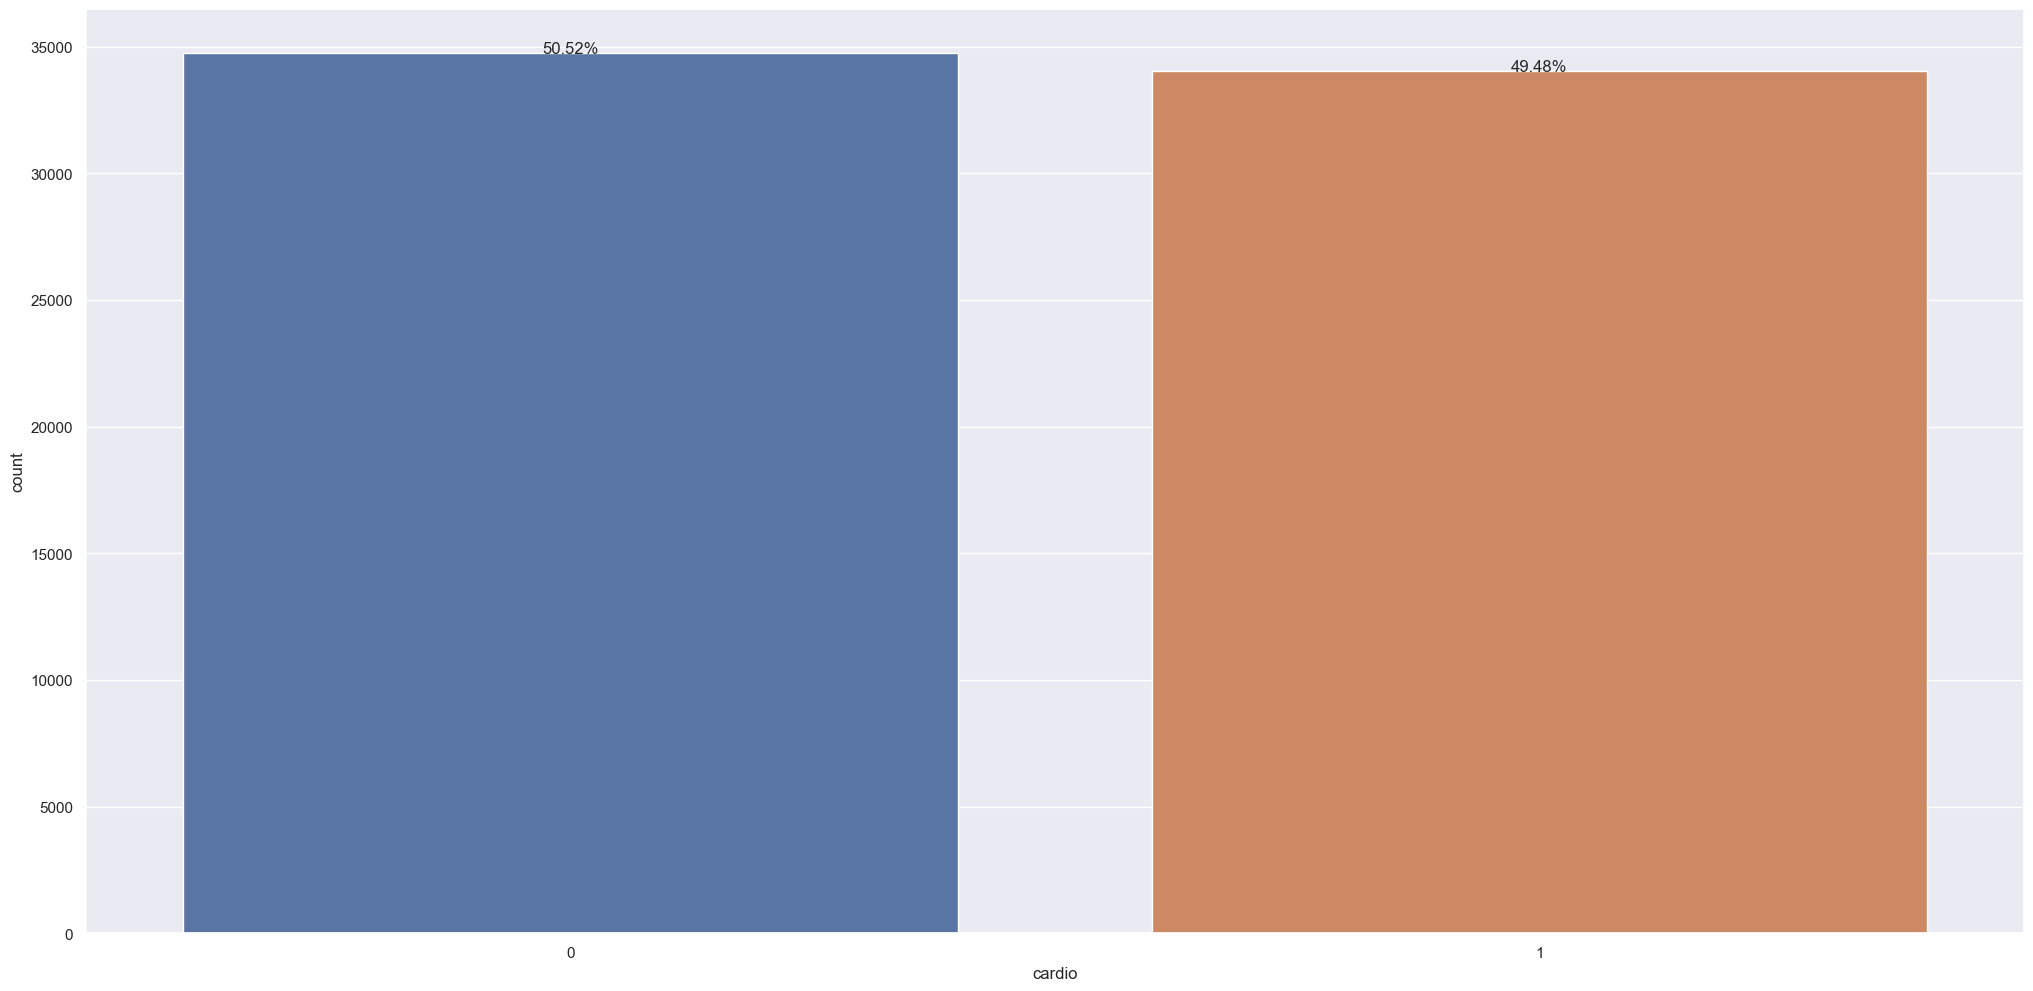

In [95]:
counts = df4['cardio'].value_counts()
ax = sns.countplot(x='cardio', data=df4)
total = counts.sum()

percentage(ax, total);

### 4.1.2. Numerical Variable

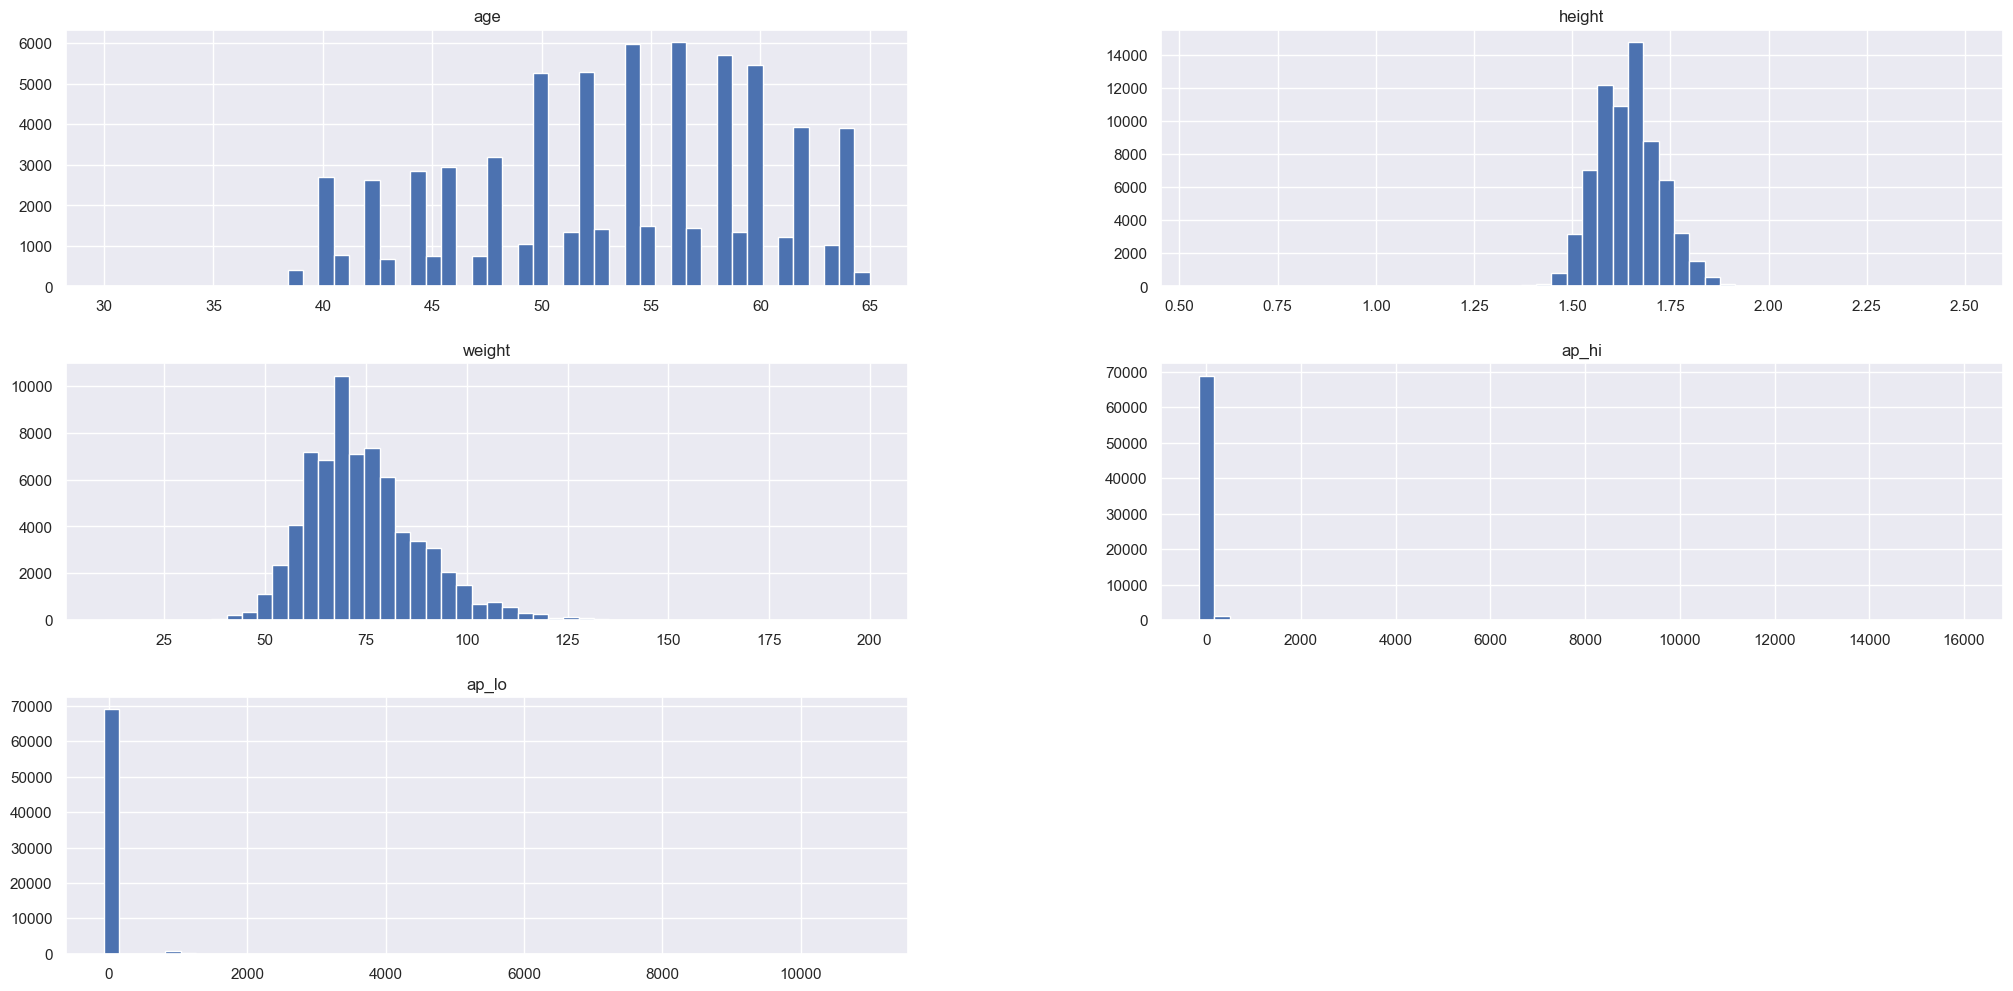

In [96]:
num_attributes.hist(bins=50);

### 4.1.3. Categorical Variable

In [97]:
df4.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,blood_pressure
0,50,2,1.68,62.00,110,80,1,1,0,0,1,0,2,1
1,55,1,1.56,85.00,140,90,3,1,0,0,1,1,4,1
2,52,1,1.65,64.00,130,70,3,1,0,0,0,1,2,1
3,48,2,1.69,82.00,150,100,1,1,0,0,1,1,3,2
4,48,1,1.56,56.00,100,60,1,1,0,0,0,0,2,1


In [98]:
cat_attributes.head()

,cholesterol,gluc,smoke,alco,active,gender
0,1,1,0,0,1,2
1,3,1,0,0,1,1
2,3,1,0,0,0,1
3,1,1,0,0,1,2
4,1,1,0,0,0,1


In [99]:
cat_attributes = pd.concat([cat_attributes, df4.iloc[:, [-2, -1]]], axis=1)
cat_attributes.head()

,cholesterol,gluc,smoke,alco,active,gender,bmi,blood_pressure
0,1,1,0,0,1,2,2.00,1.00
1,3,1,0,0,1,1,4.00,1.00
2,3,1,0,0,0,1,2.00,1.00
3,1,1,0,0,1,2,3.00,2.00
4,1,1,0,0,0,1,2.00,1.00


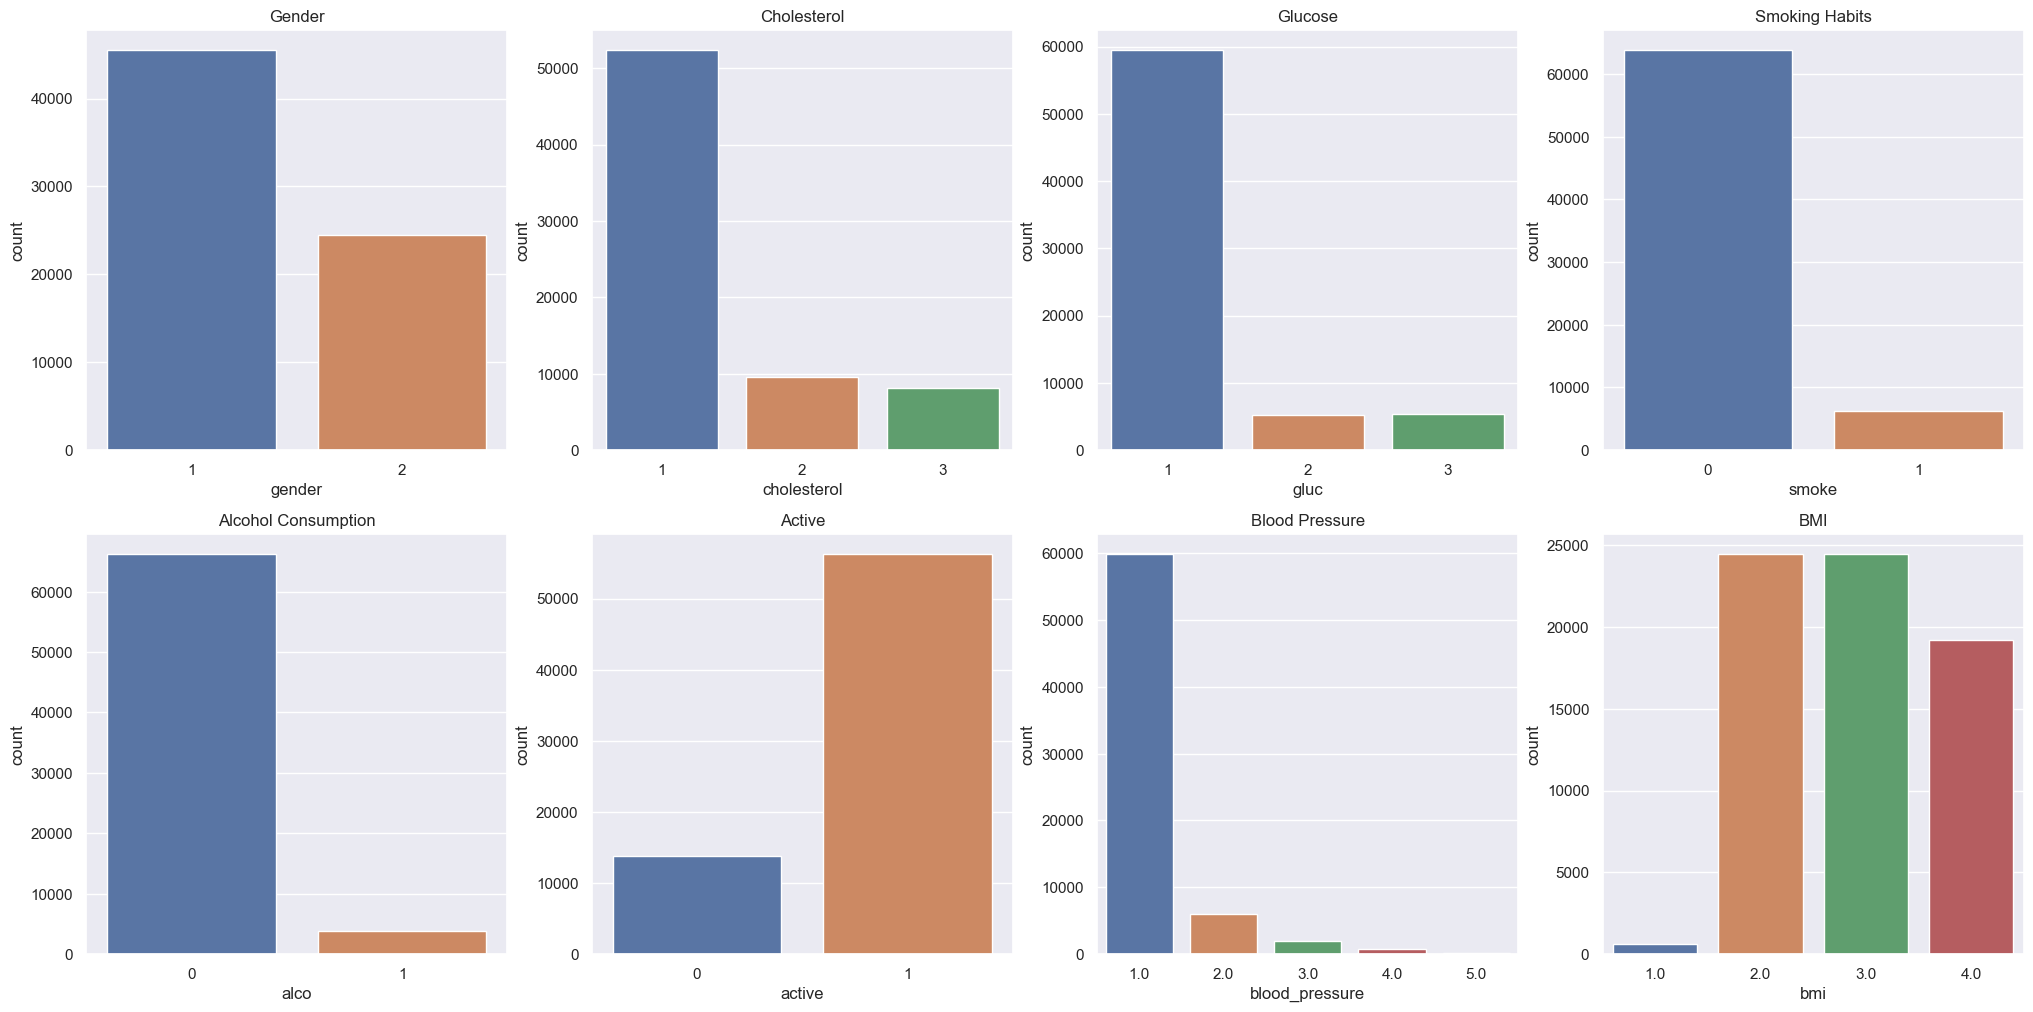

In [100]:
# gender
plt.subplot(2, 4, 1)
plt.title('Gender')
sns.countplot(x=cat_attributes['gender'])

# cholesterol
plt.subplot(2, 4, 2)
plt.title('Cholesterol')
sns.countplot(x=cat_attributes['cholesterol'])

# glucose
plt.subplot(2, 4, 3)
plt.title('Glucose')
sns.countplot(x=cat_attributes['gluc'])

# smoke
plt.subplot(2, 4, 4)
plt.title('Smoking Habits')
sns.countplot(x=cat_attributes['smoke'])

# alco
plt.subplot(2, 4, 5)
plt.title('Alcohol Consumption')
sns.countplot(x=cat_attributes['alco'])

# active
plt.subplot(2, 4, 6)
plt.title('Active')
sns.countplot(x=cat_attributes['active'])

# blood_pressure
plt.subplot(2, 4, 7)
plt.title('Blood Pressure')
sns.countplot(x=cat_attributes['blood_pressure'])

# bmi
plt.subplot(2, 4, 8)
plt.title('BMI')
sns.countplot(x=cat_attributes['bmi']);

## 4.2. Bivariate Analysis

### 4.2.1. **H01**: The incidence of cardiovascular disease is at least 30% disease higher in one of the genders.
**False**: a significant difference can't be observed.

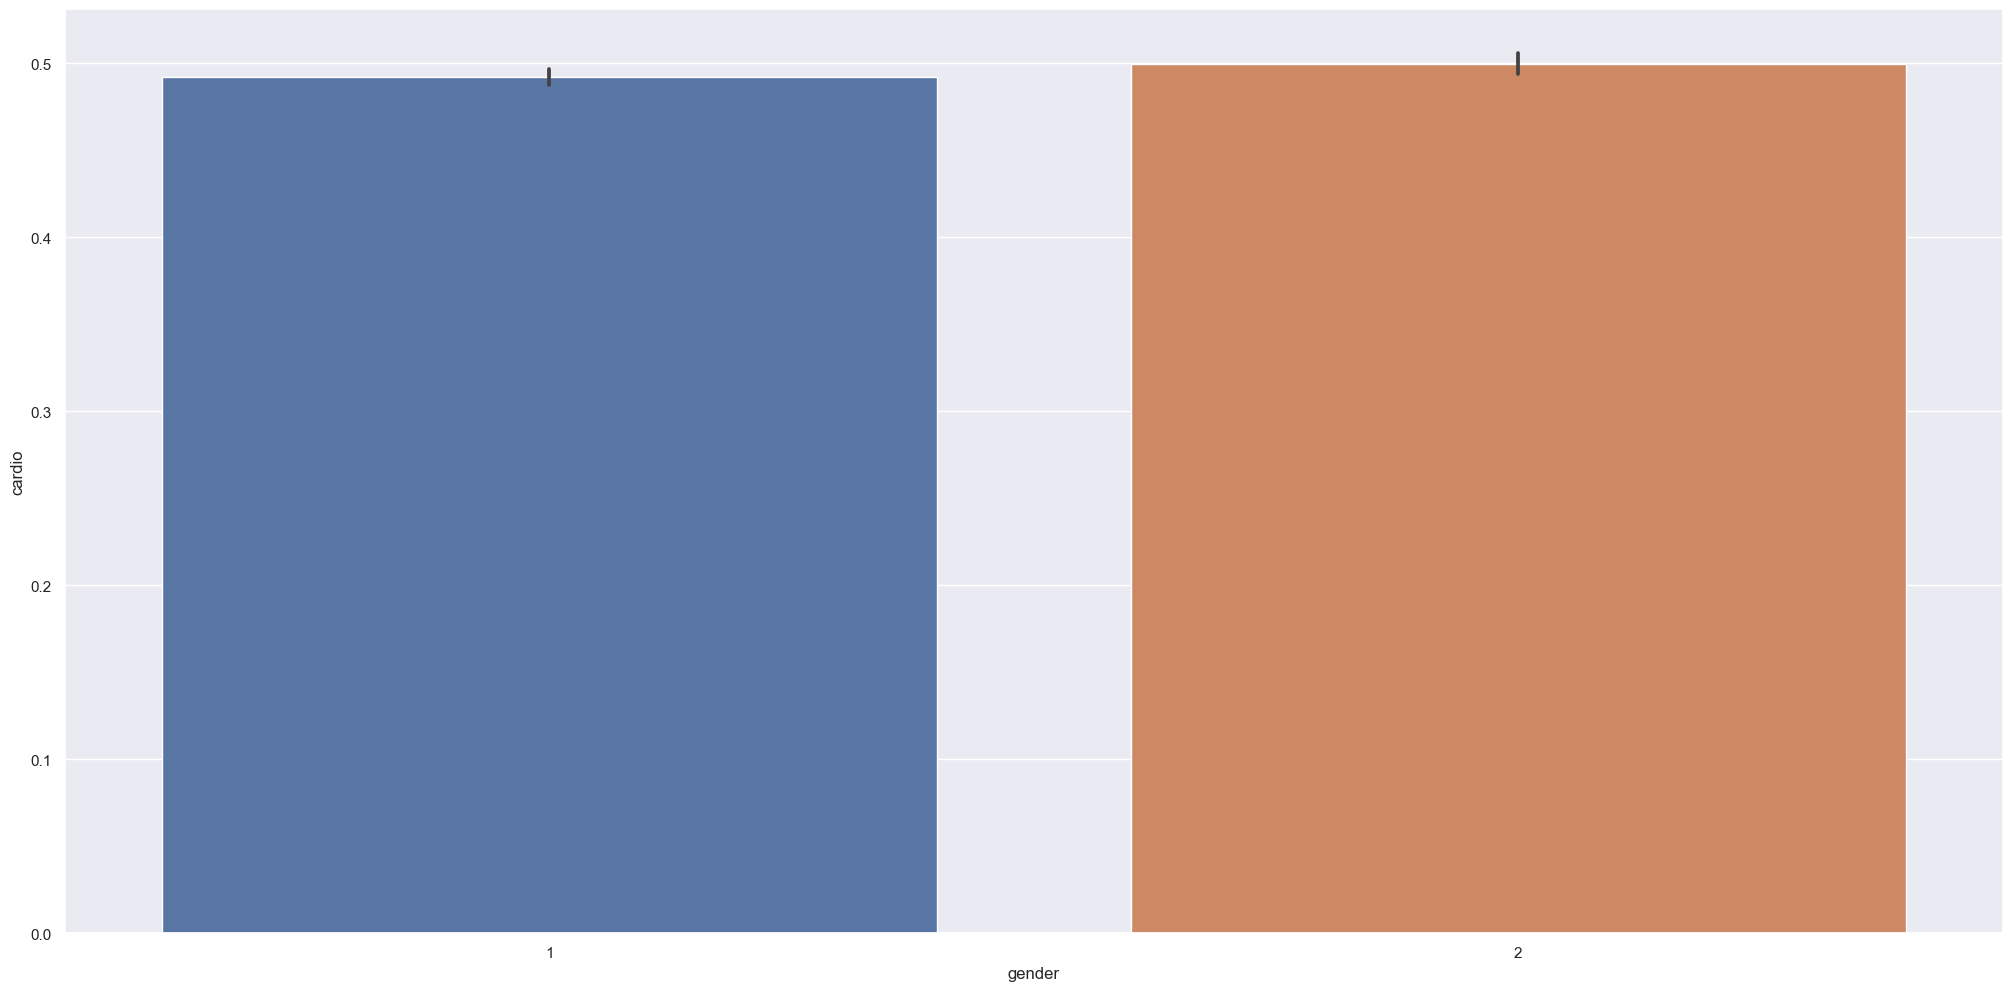

In [101]:
sns.barplot(x='gender', y='cardio', data=df4);

### 4.2.2. **H02**: Age is positively correlated with the risk of cardiovascular diseases.
**True**: age is positively correlated with the risk of cardiovascular diseases.

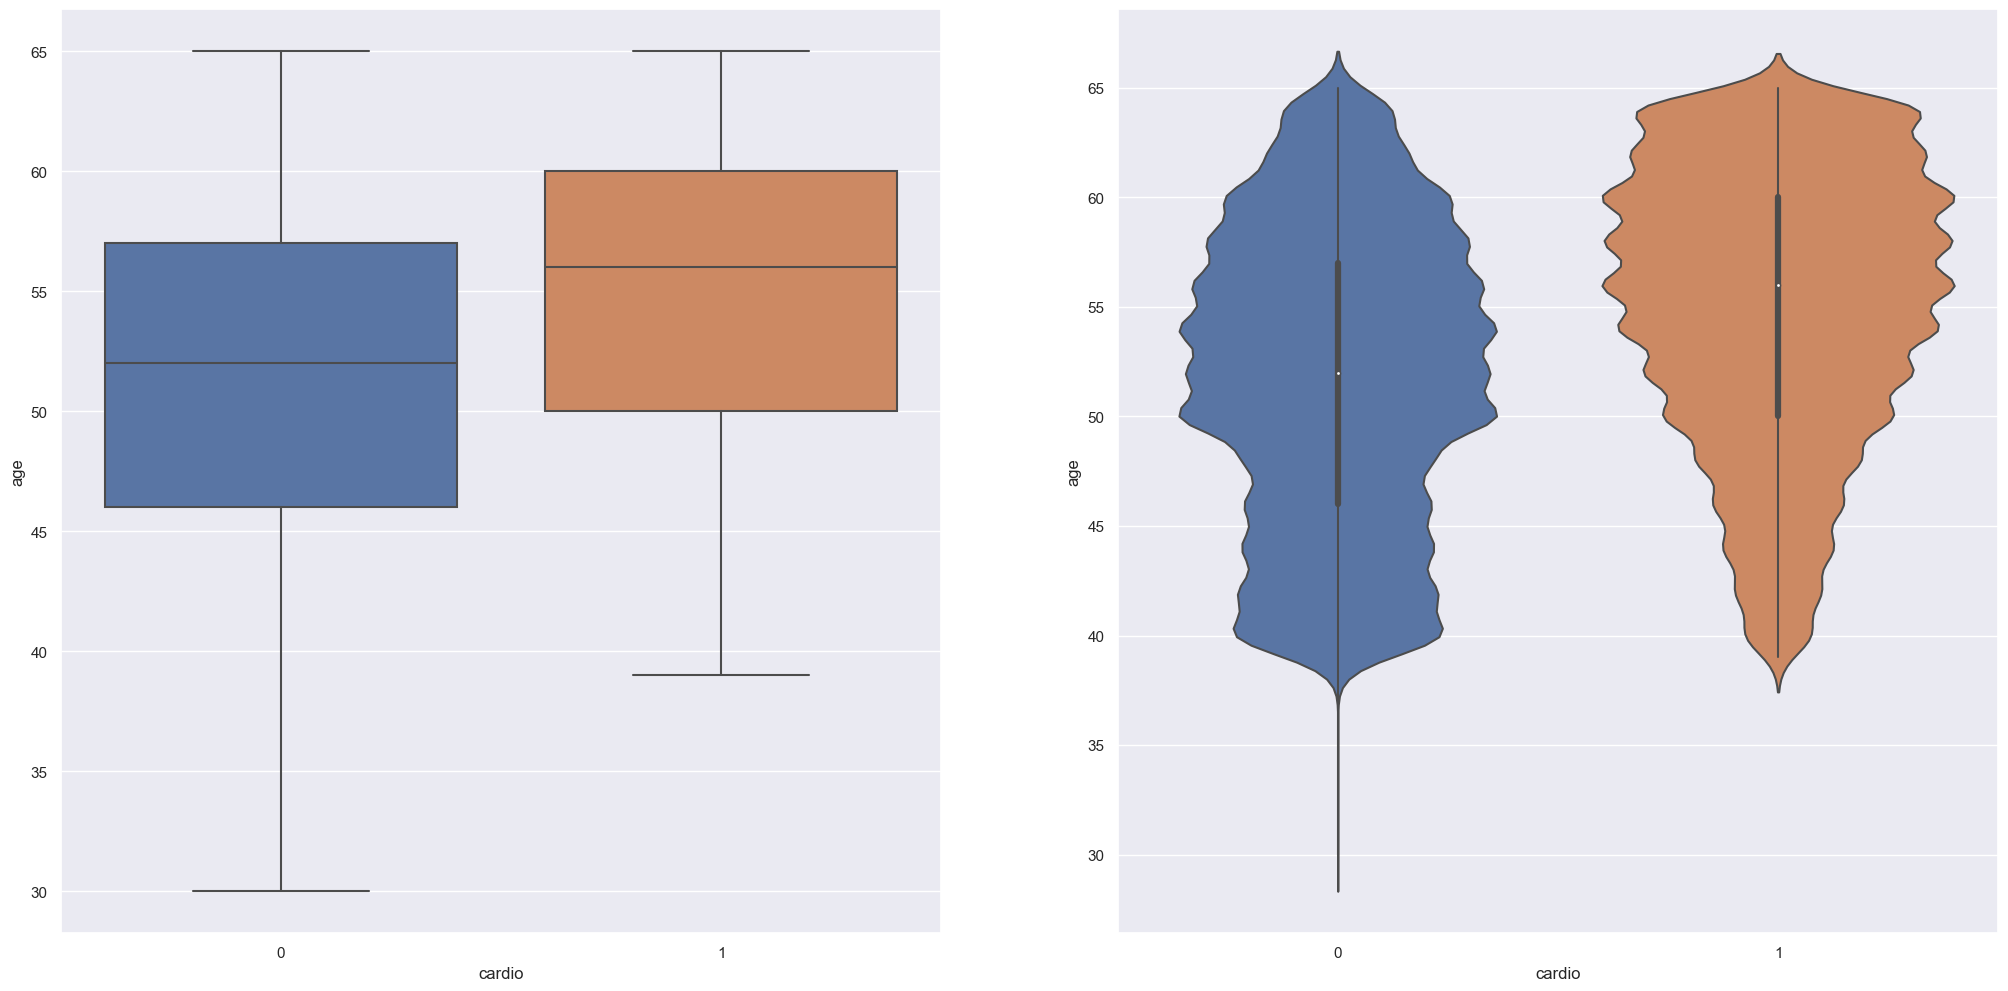

In [102]:
plt.subplot(1, 2, 1)
sns.boxplot(x="cardio", y="age", data=df4)

plt.subplot(1, 2, 2)
sns.violinplot(x="cardio", y="age", data=df4);

### 4.2.3. **H03**: Individuals who are overweight and short are at a higher risk of developing cardiovascular disease than those who are tall but underweight.

**True**: overweight and short individuals are more prone to develop cardiovascular diseases.

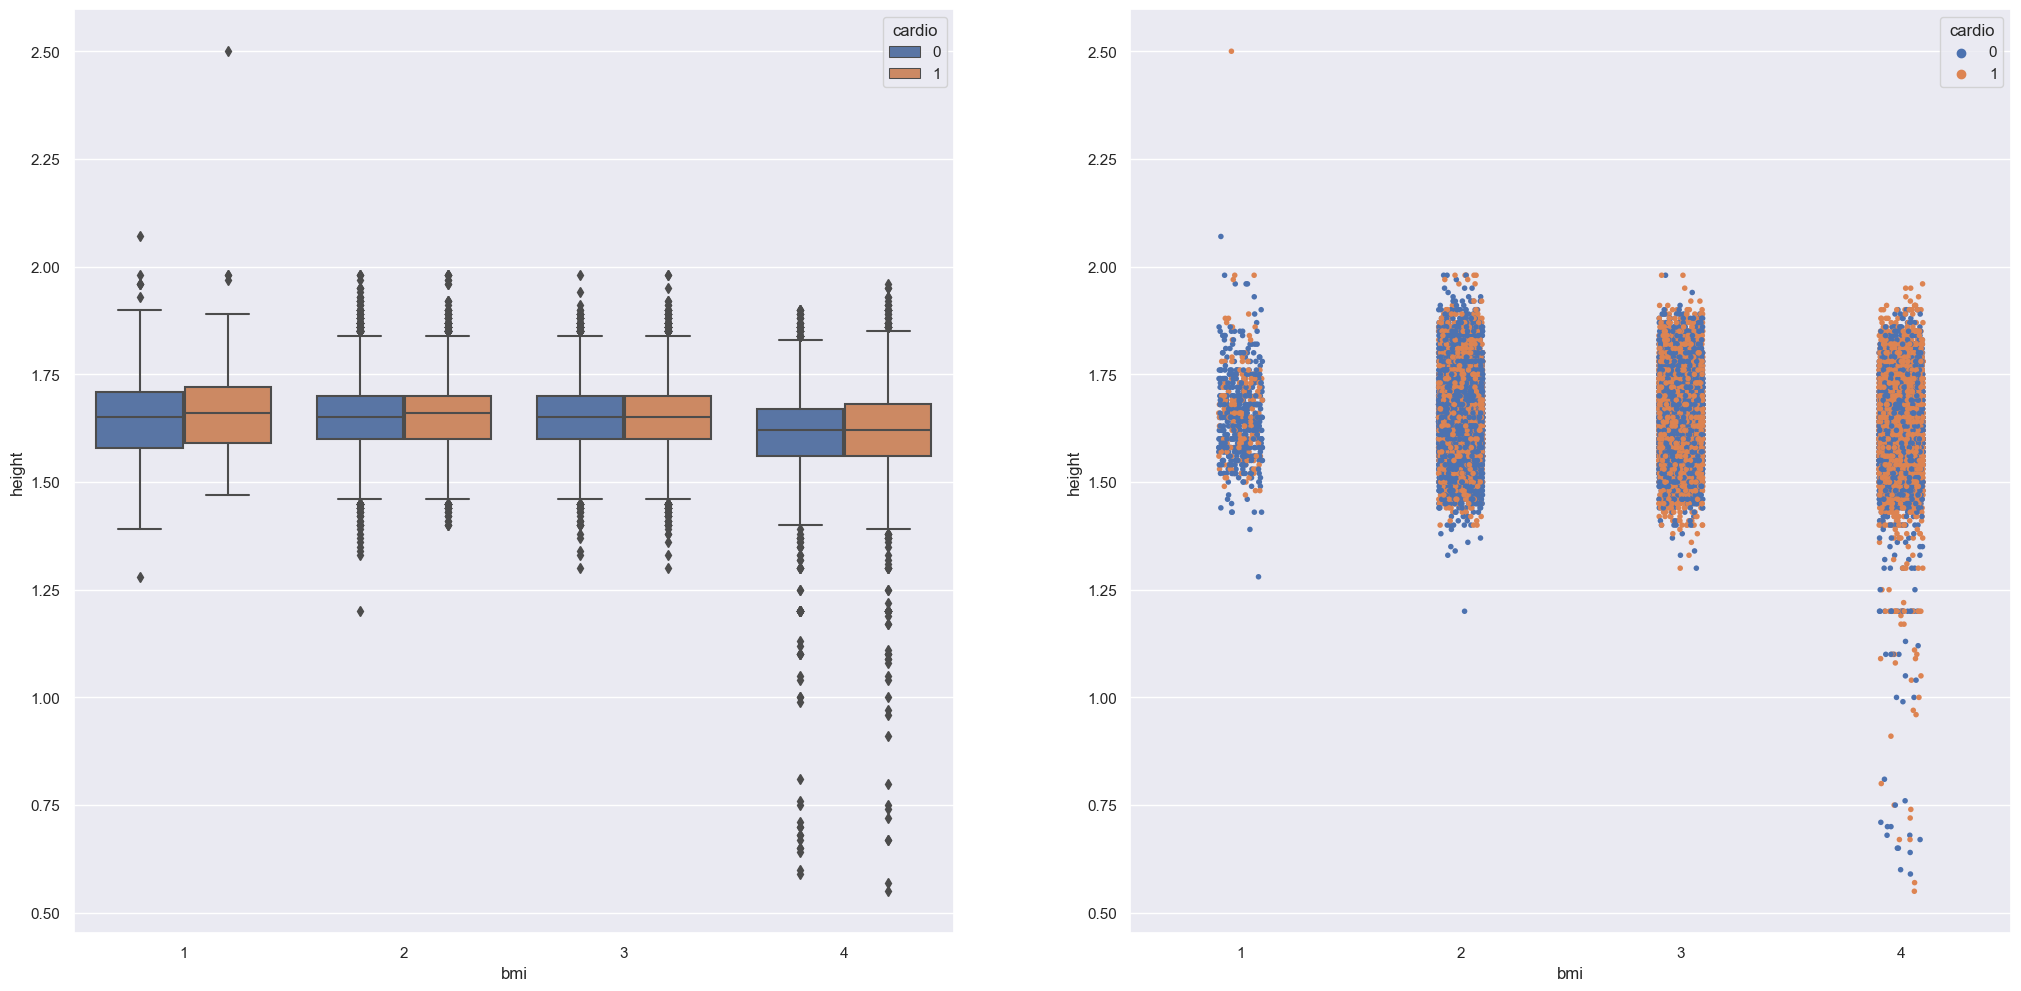

In [103]:
plt.subplot(1, 2, 1)
sns.boxplot(x='bmi', y='height', hue='cardio', data=df4)

plt.subplot(1, 2, 2)
sns.stripplot(x='bmi', y='height', hue='cardio', data=df4, jitter=True, size=4);

### 4.2.4. **H04**: People with Dwarfism condition are not necessarily prone to develop cardiovascular diseases.
**True**: although our data indicate that indeed individuals with dwarfism are not necessarily prone to develop cardiovascular diseases, the difference is minimal.

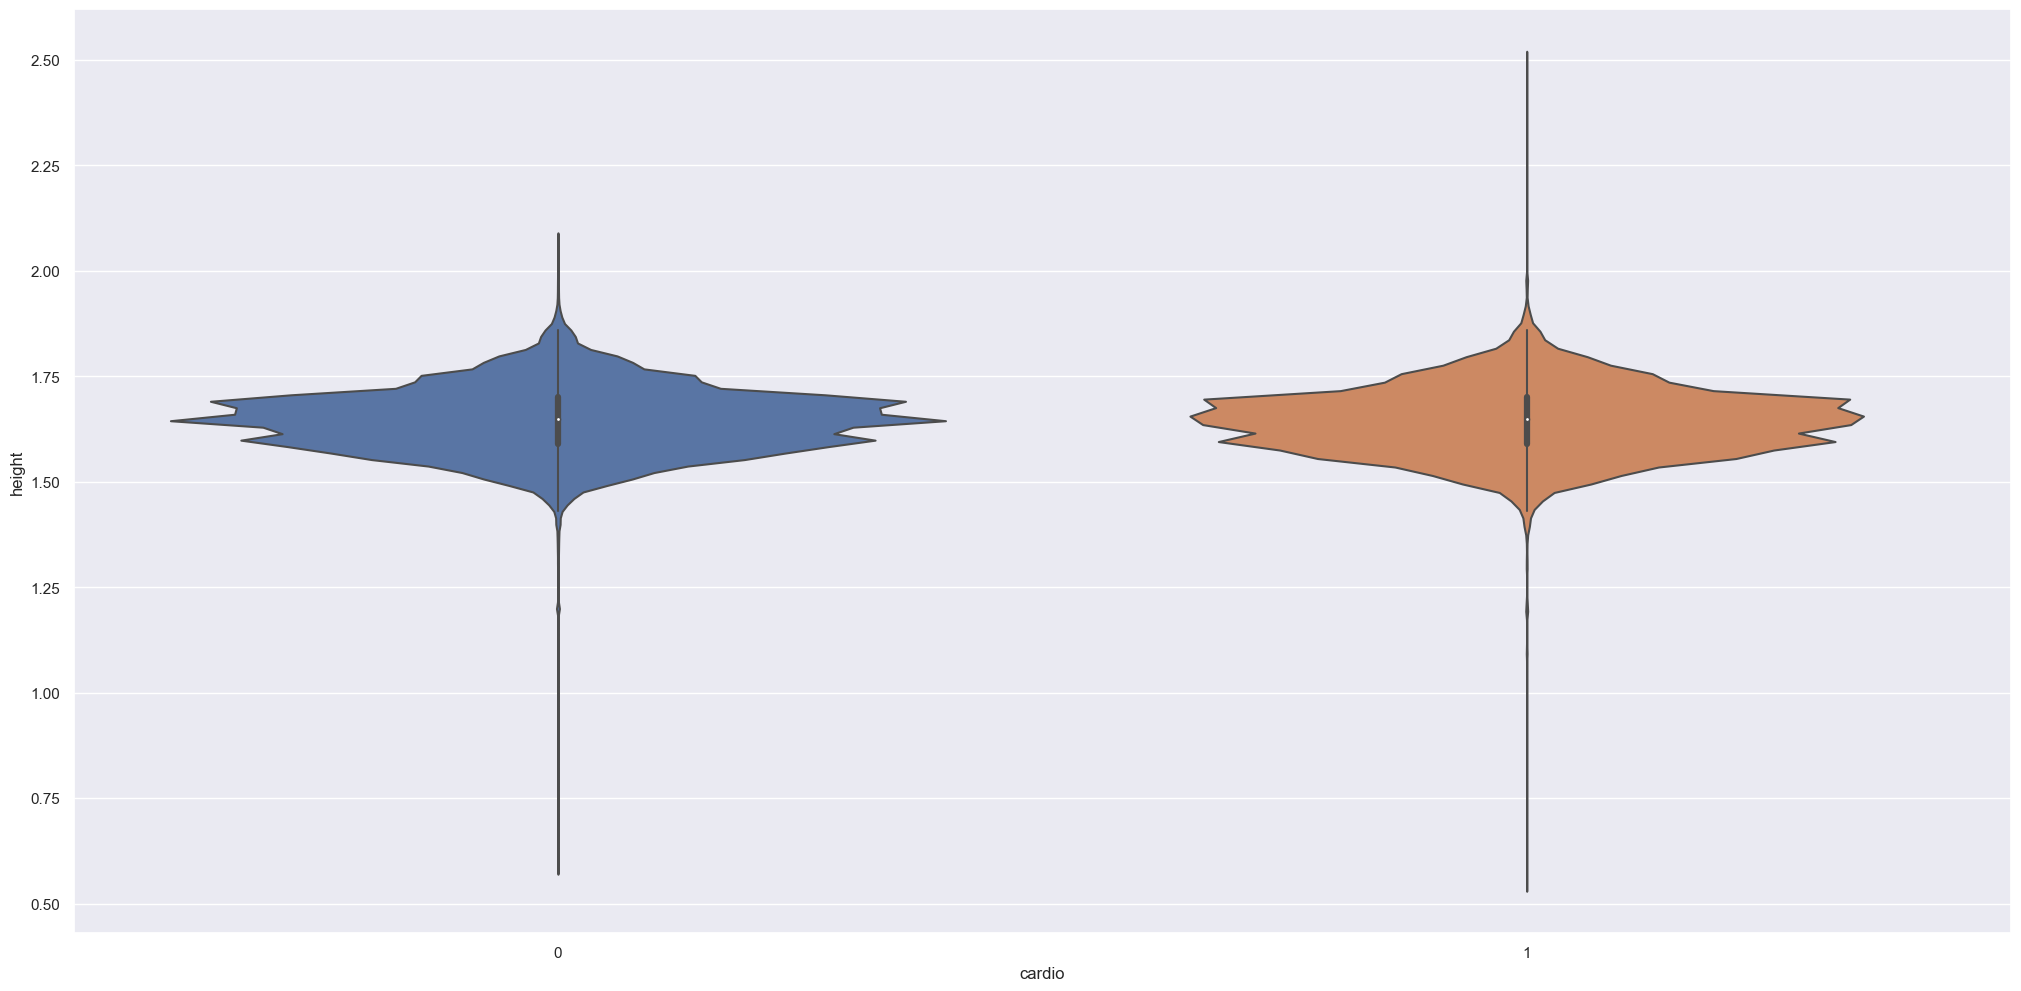

In [104]:
sns.violinplot(x='cardio', y='height', data=df4);

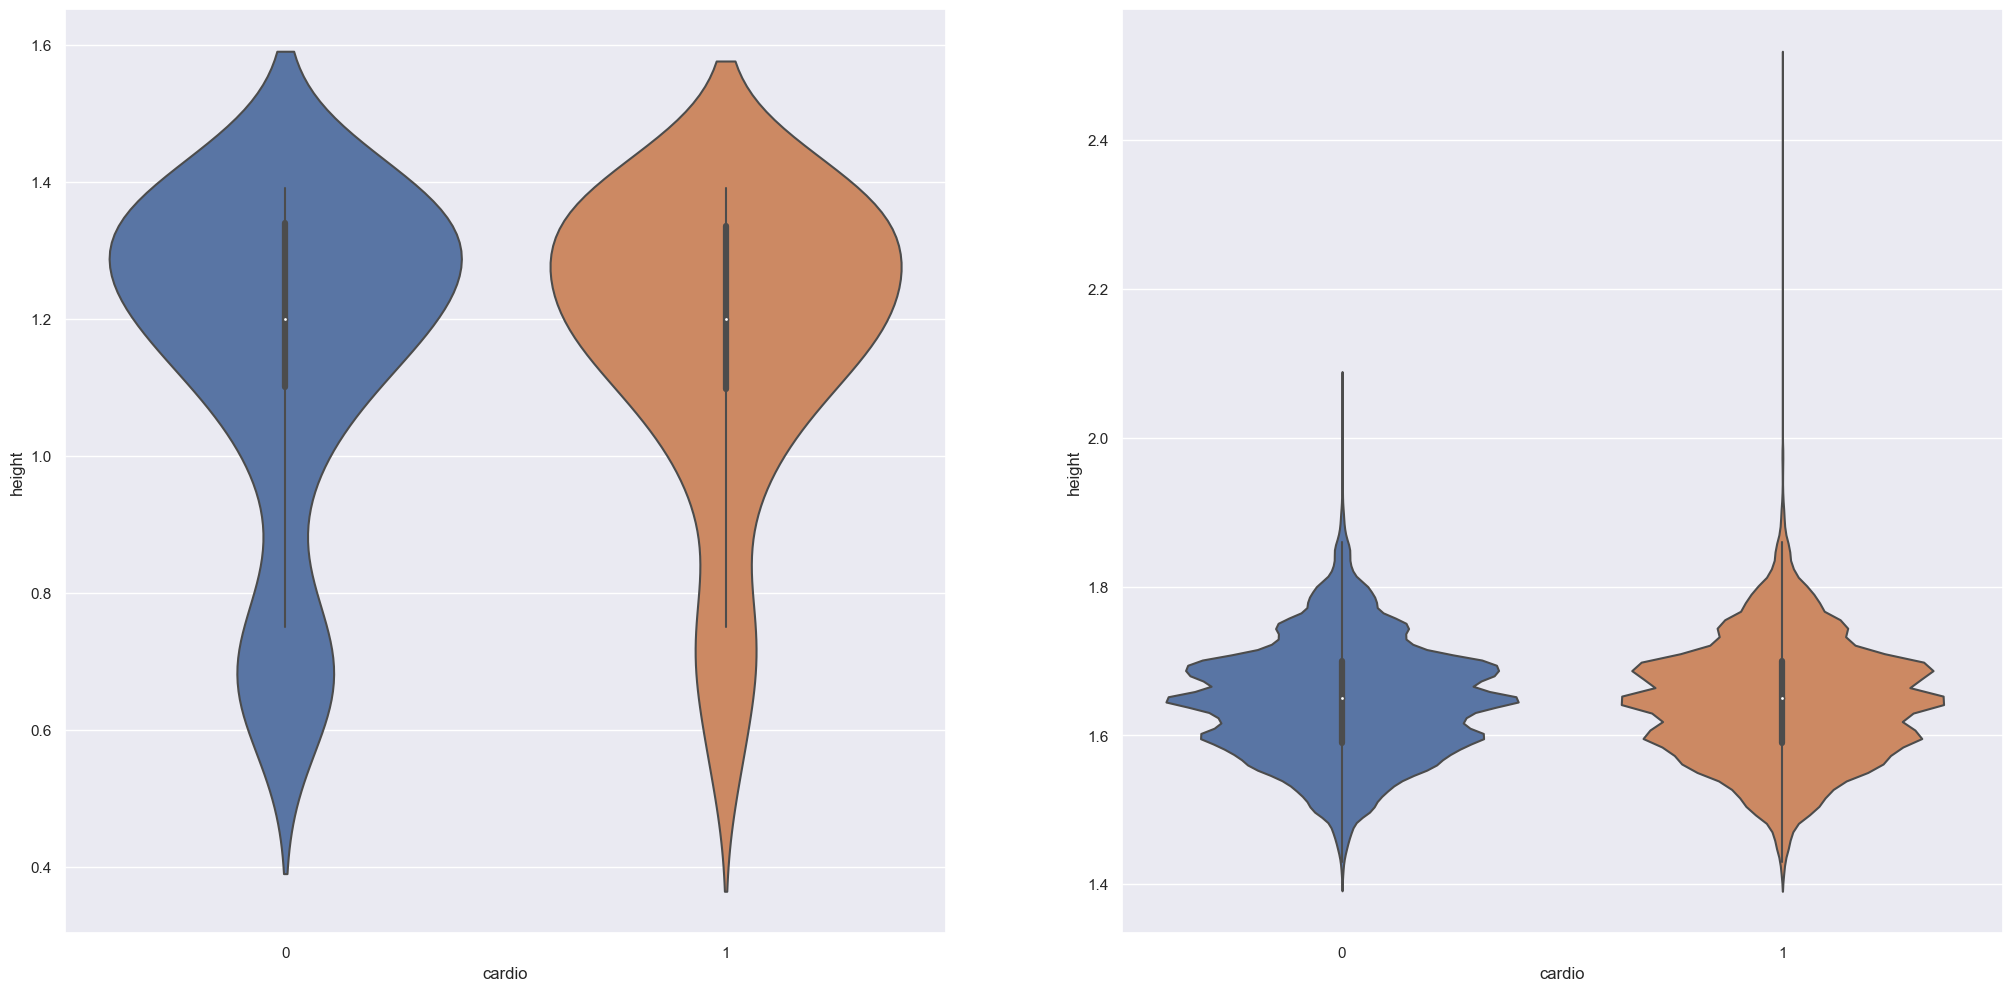

In [105]:
aux1 = df4.loc[(df4['height'] < 1.40)]
aux2 = df4.loc[(df4['height'] > 1.40)]

plt.subplot(1, 2, 1)
sns.violinplot(x='cardio', y='height', data=aux1)

plt.subplot(1, 2, 2)
sns.violinplot(x='cardio', y='height', data=aux2);

### 4.2.5. **H05**: Smoking is a predictor for cardiovascular diseases development.
**True**: not only smoking habit is a predictor for cardiovascular diseases development, people who develop cardiovascular diseases but do not smoke, are more likely to develop cardiovascular diseases later in life.

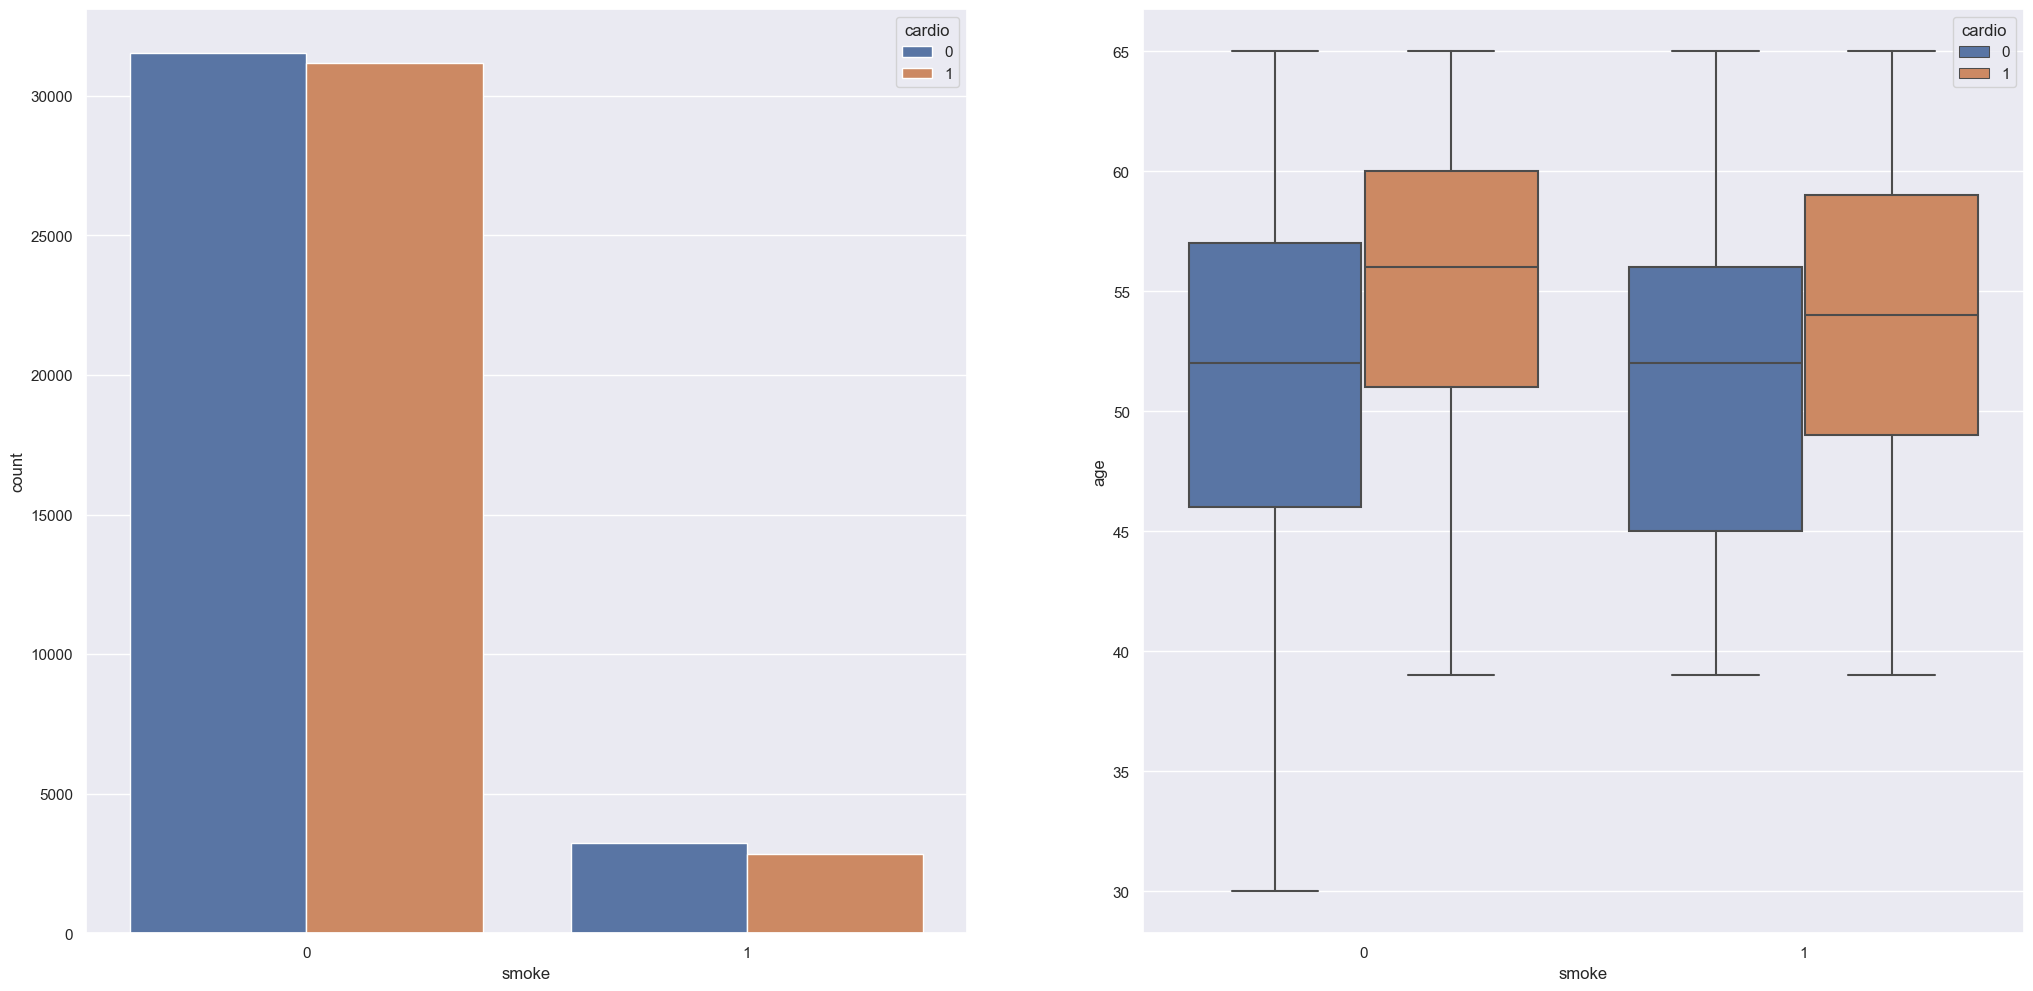

In [106]:
plt.subplot(1, 2, 1)
sns.countplot(x='smoke', hue='cardio', data=df4)

plt.subplot(1, 2, 2)
sns.boxplot(x='smoke', y='age', data=df4, hue='cardio');

### 4.2.6. **H06**: People who have high blood pressure are more prone to develop cardiovascular diseases than those with normal blood pressure.
**True**: Not only people who have high blood pressure are more prone to develop cardiovascular diseases.

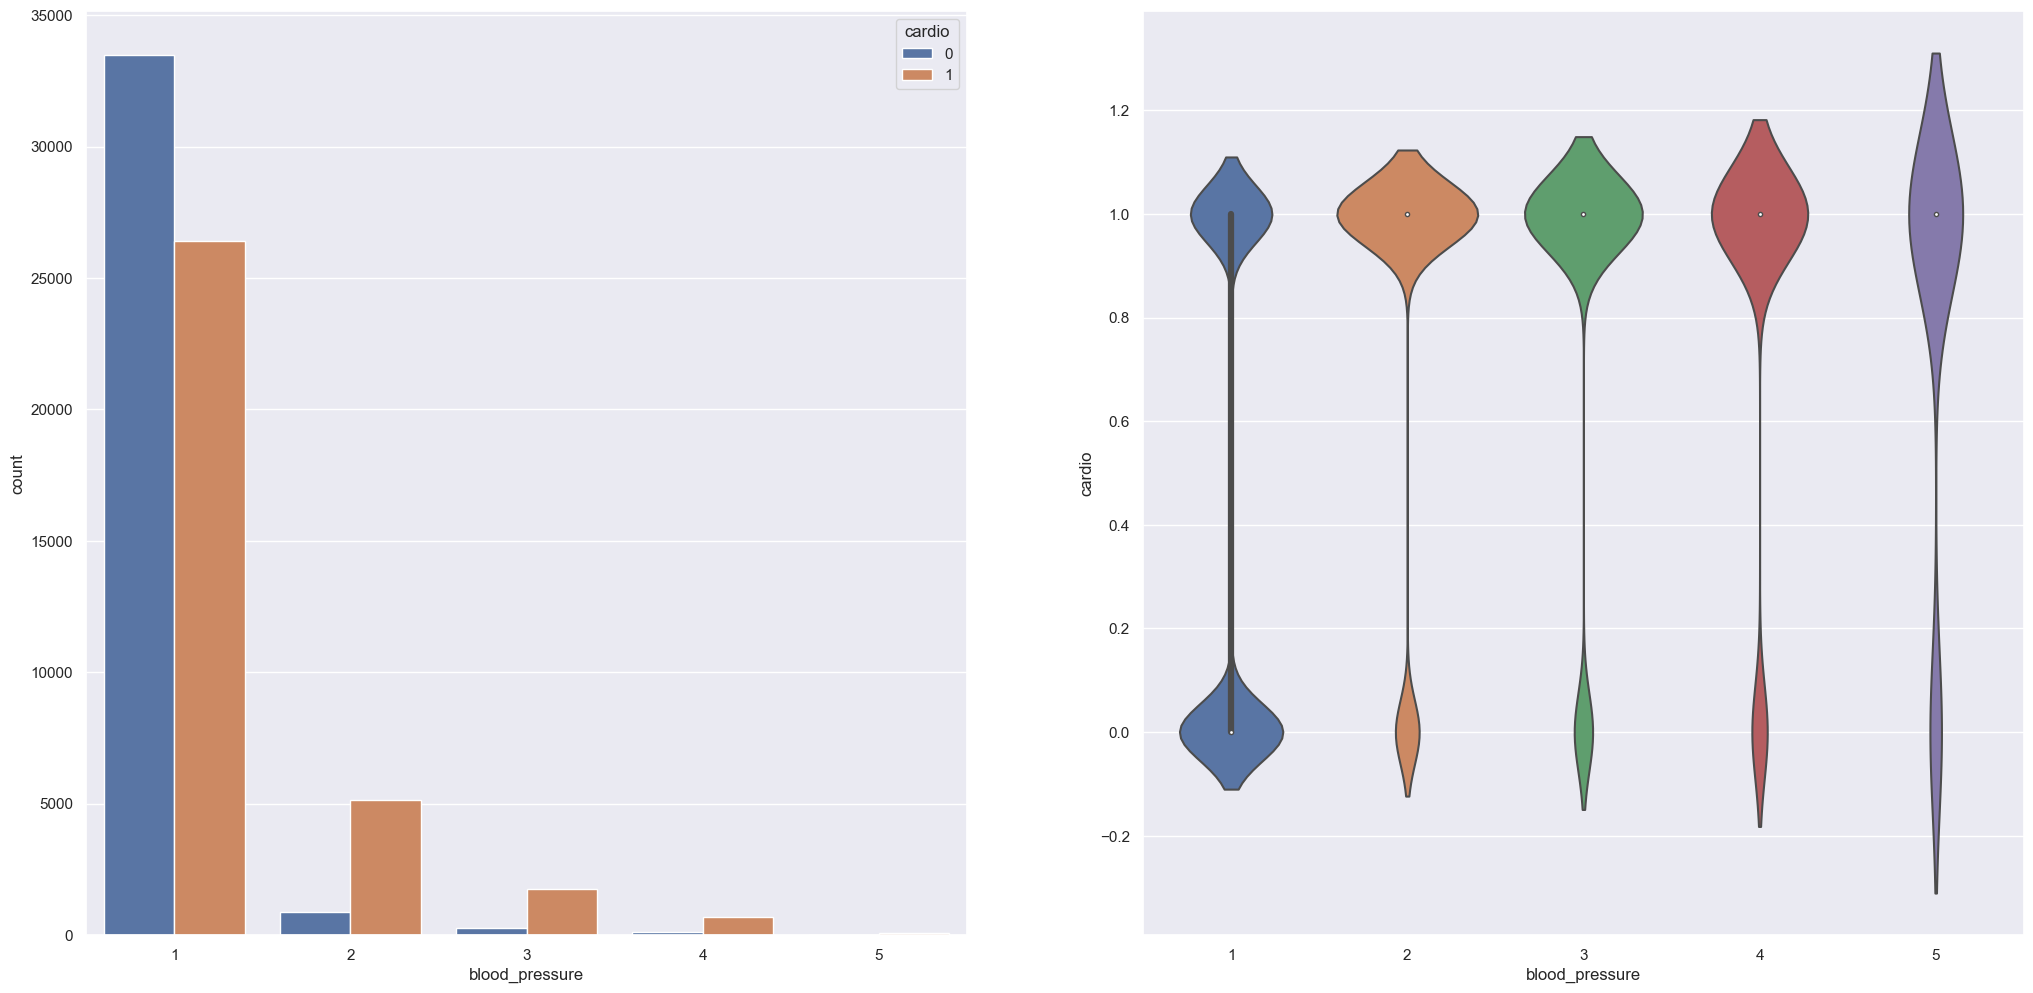

In [107]:
plt.subplot(1, 2, 1)
sns.countplot(x='blood_pressure', hue='cardio', data=df4)

plt.subplot(1, 2, 2)
sns.violinplot(x='blood_pressure', y='cardio', data=df4);

### 4.2.7. **H07**: People who have high cholesterol levels are more prone to develop cardiovascular diseases than those with normal cholesterol levels.
**True**: People who have high cholesterol levels are more prone to develop cardiovascular diseases than those with normal cholesterol levels.

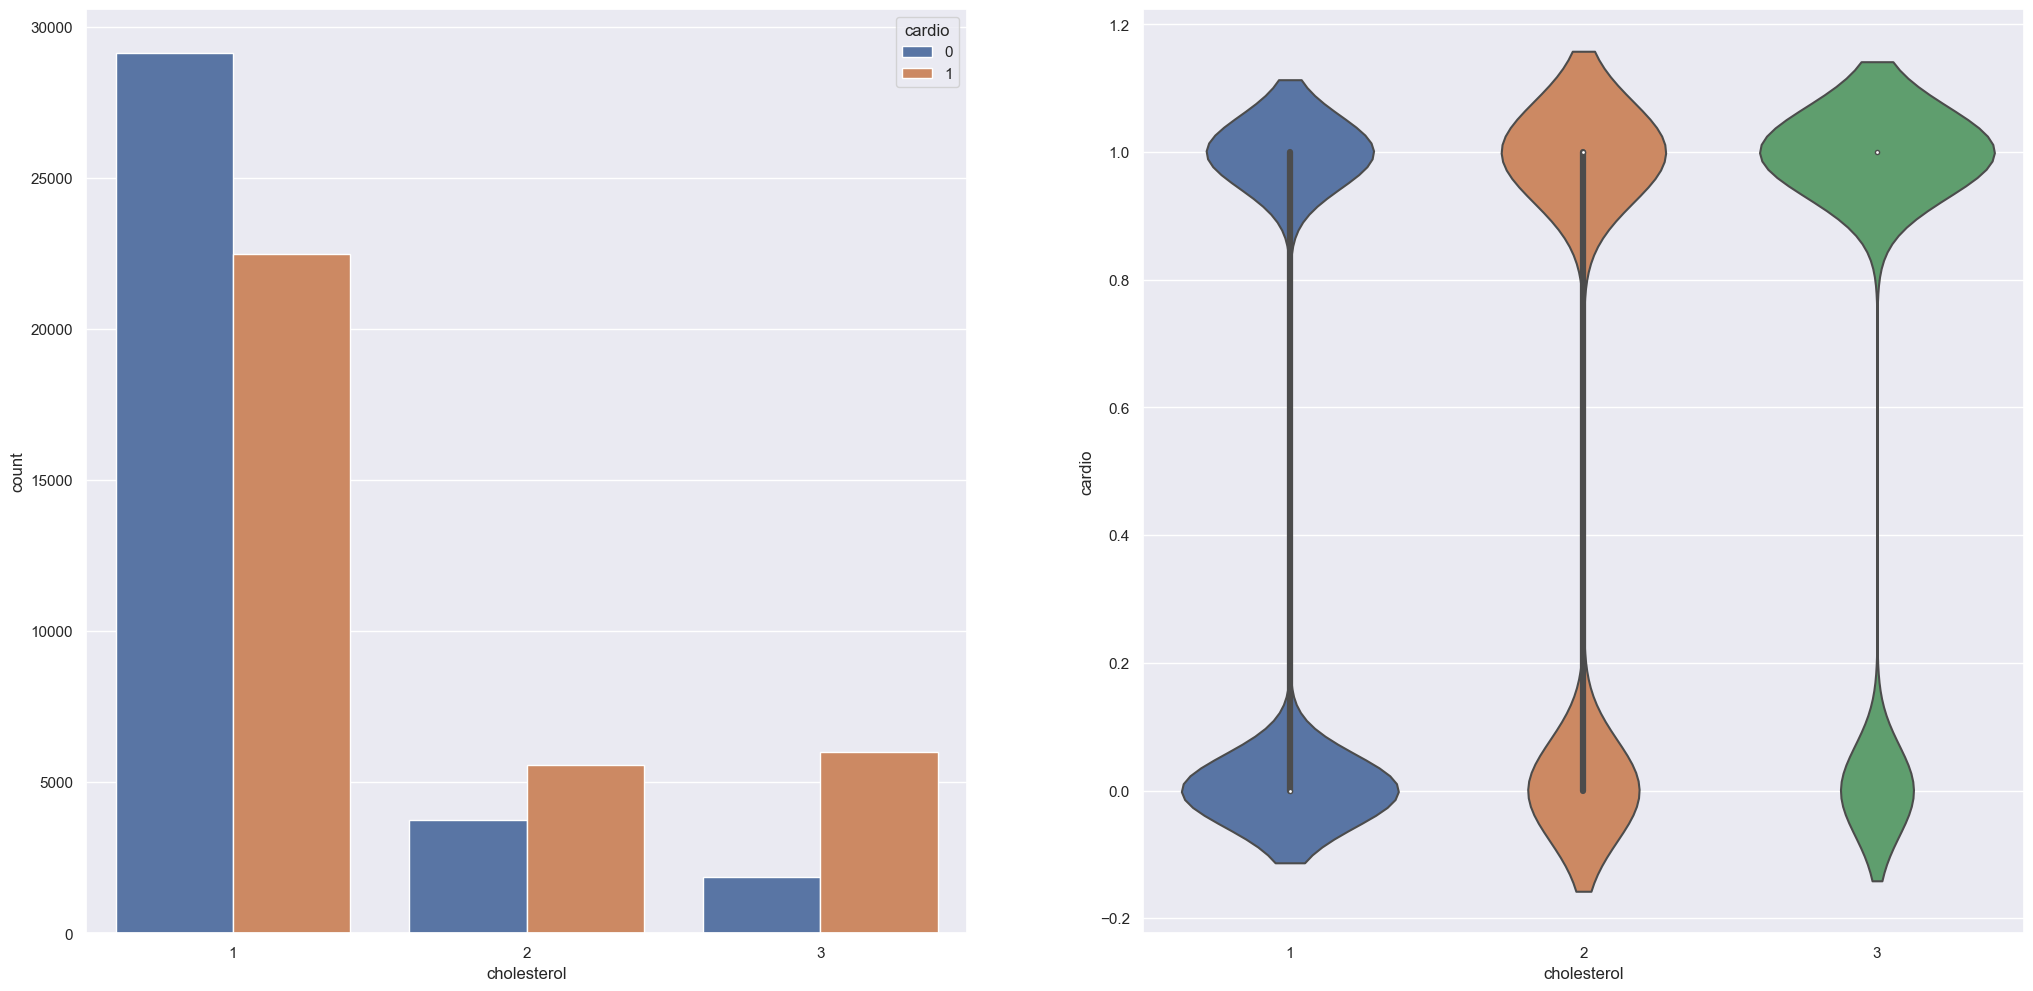

In [108]:
plt.subplot(1, 2, 1)
sns.countplot(x='cholesterol', hue='cardio', data=df4)

plt.subplot(1, 2, 2)
sns.violinplot(x='cholesterol', y='cardio', data=df4);

### 4.2.8. **H08**: Being physically active decreases the risk of developing cardiovascular diseases.
**True**: Being physically active decreases the risk of developing cardiovascular diseases.

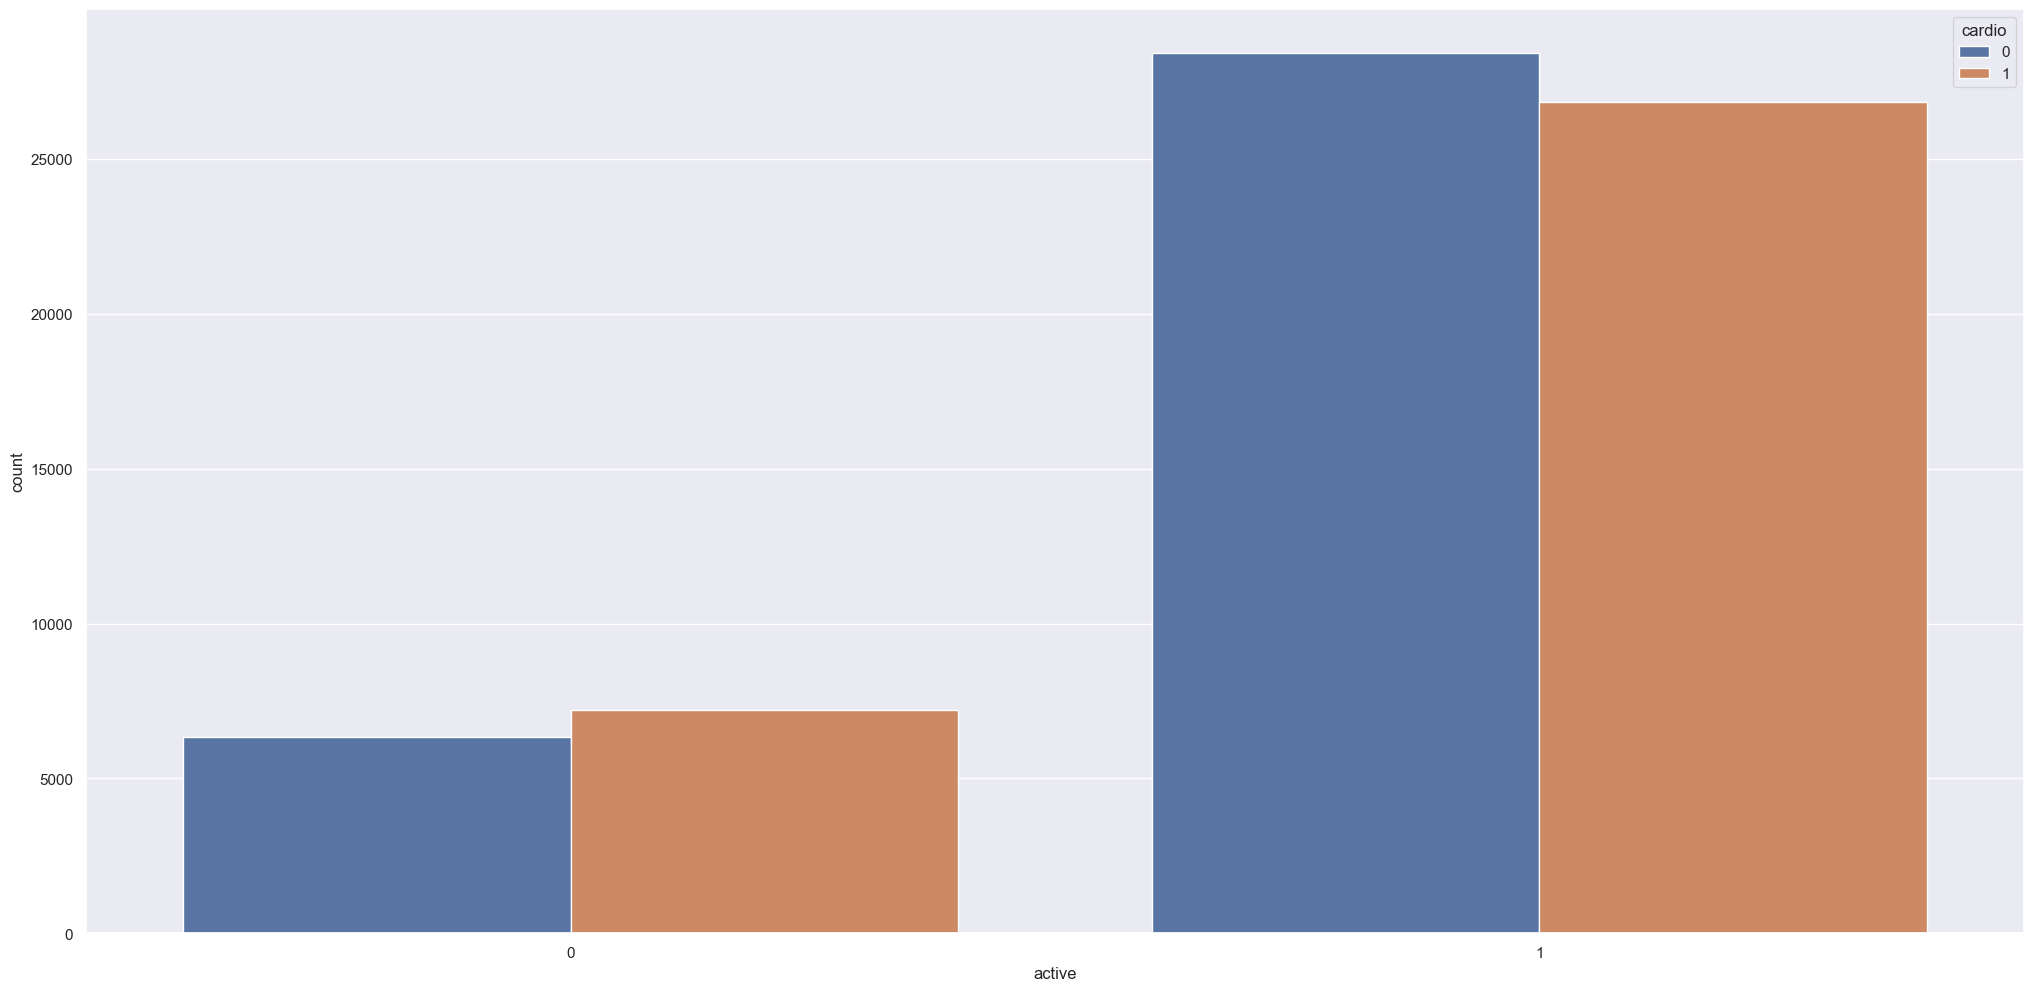

In [109]:
sns.countplot(x='active', hue='cardio', data=df4);

### 4.2.9. **H09**: Being physically active, even as a smoker, do not decreases the risk of developing cardiovascular diseases.
**False**: Being physically active, even if the person is a smoker, decreases the risk of developing cardiovascular diseases.

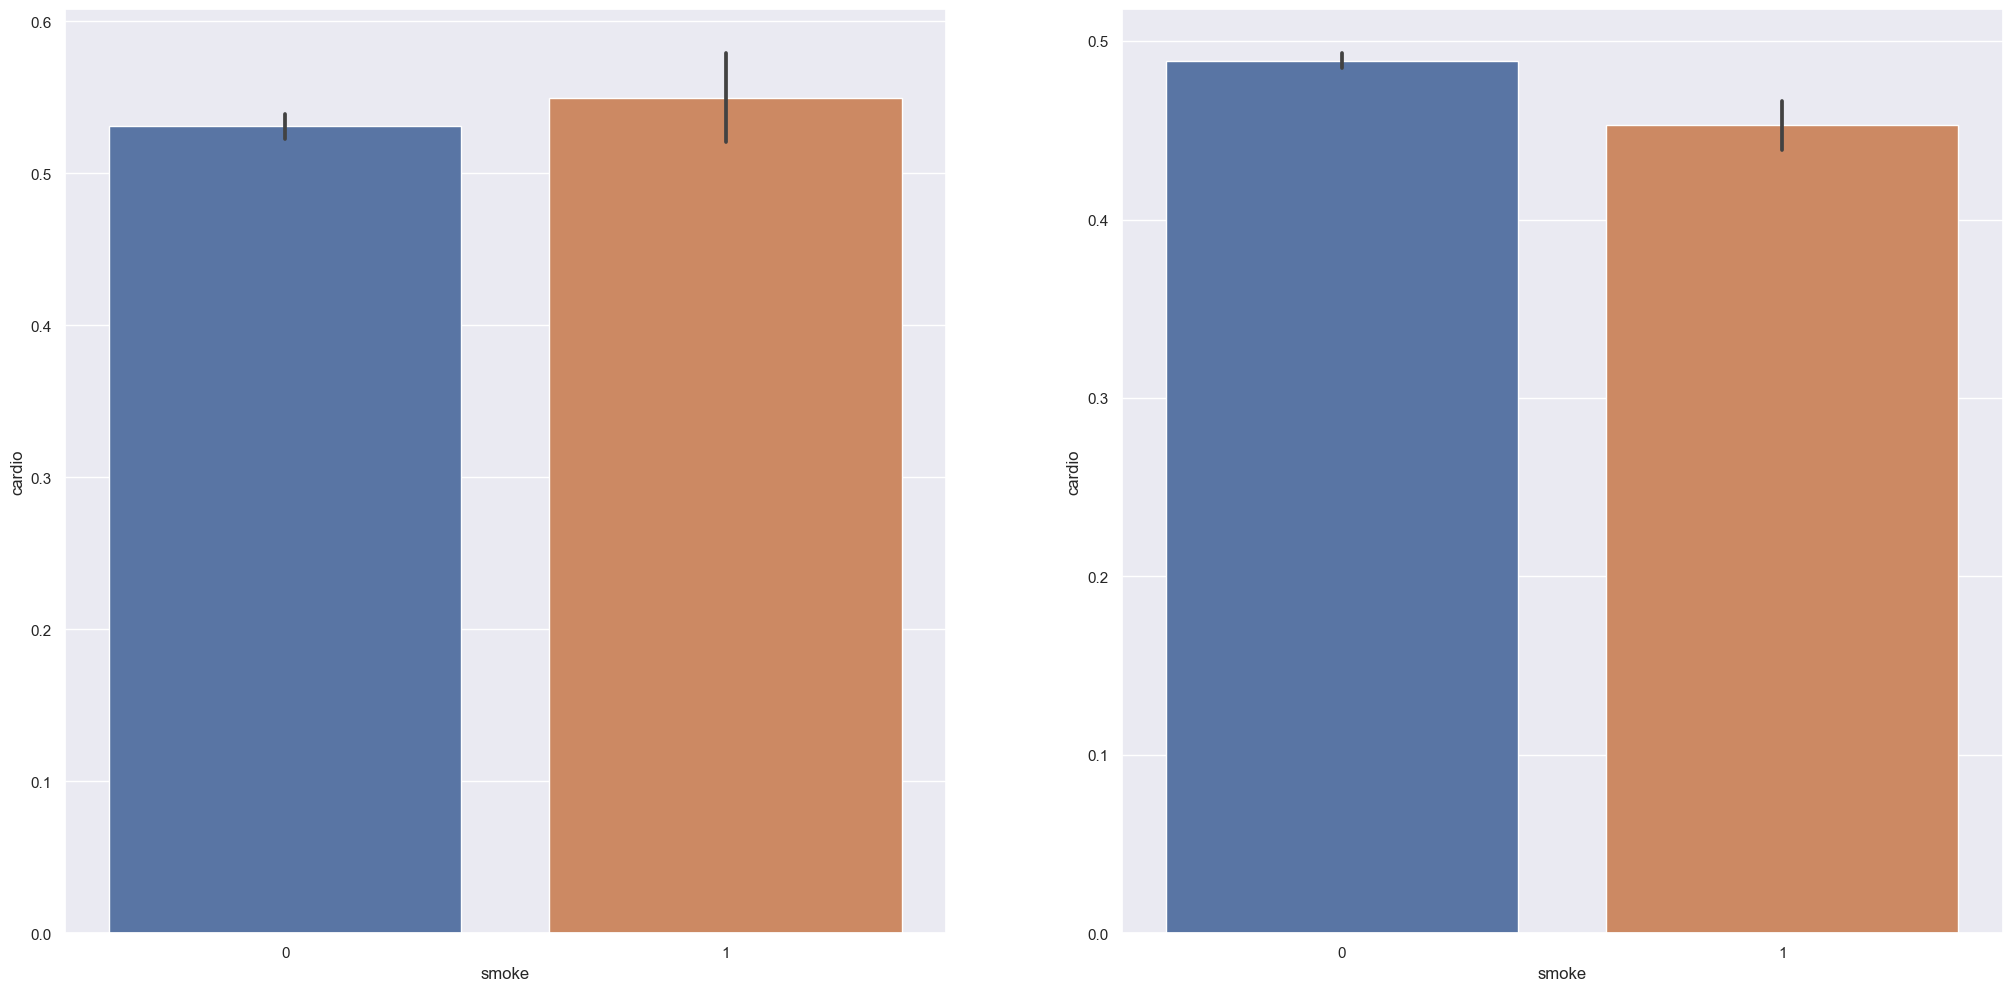

In [110]:
aux1 = df4.loc[(df4['active'] == 0)]
aux2 = df4.loc[(df4['active'] == 1)]

plt.subplot(1, 2, 1)
sns.barplot(x='smoke', y='cardio', data=aux1)

plt.subplot(1, 2, 2)
sns.barplot(x='smoke', y='cardio', data=aux2);



### 4.2.10. **H10**: Being physically active, even if the person continue drinking alcohol, decreases the risk of developing cardiovascular diseases.
**True**: Being physically active, even if the person continue drinking alcohol, decreases the risk of developing cardiovascular diseases.

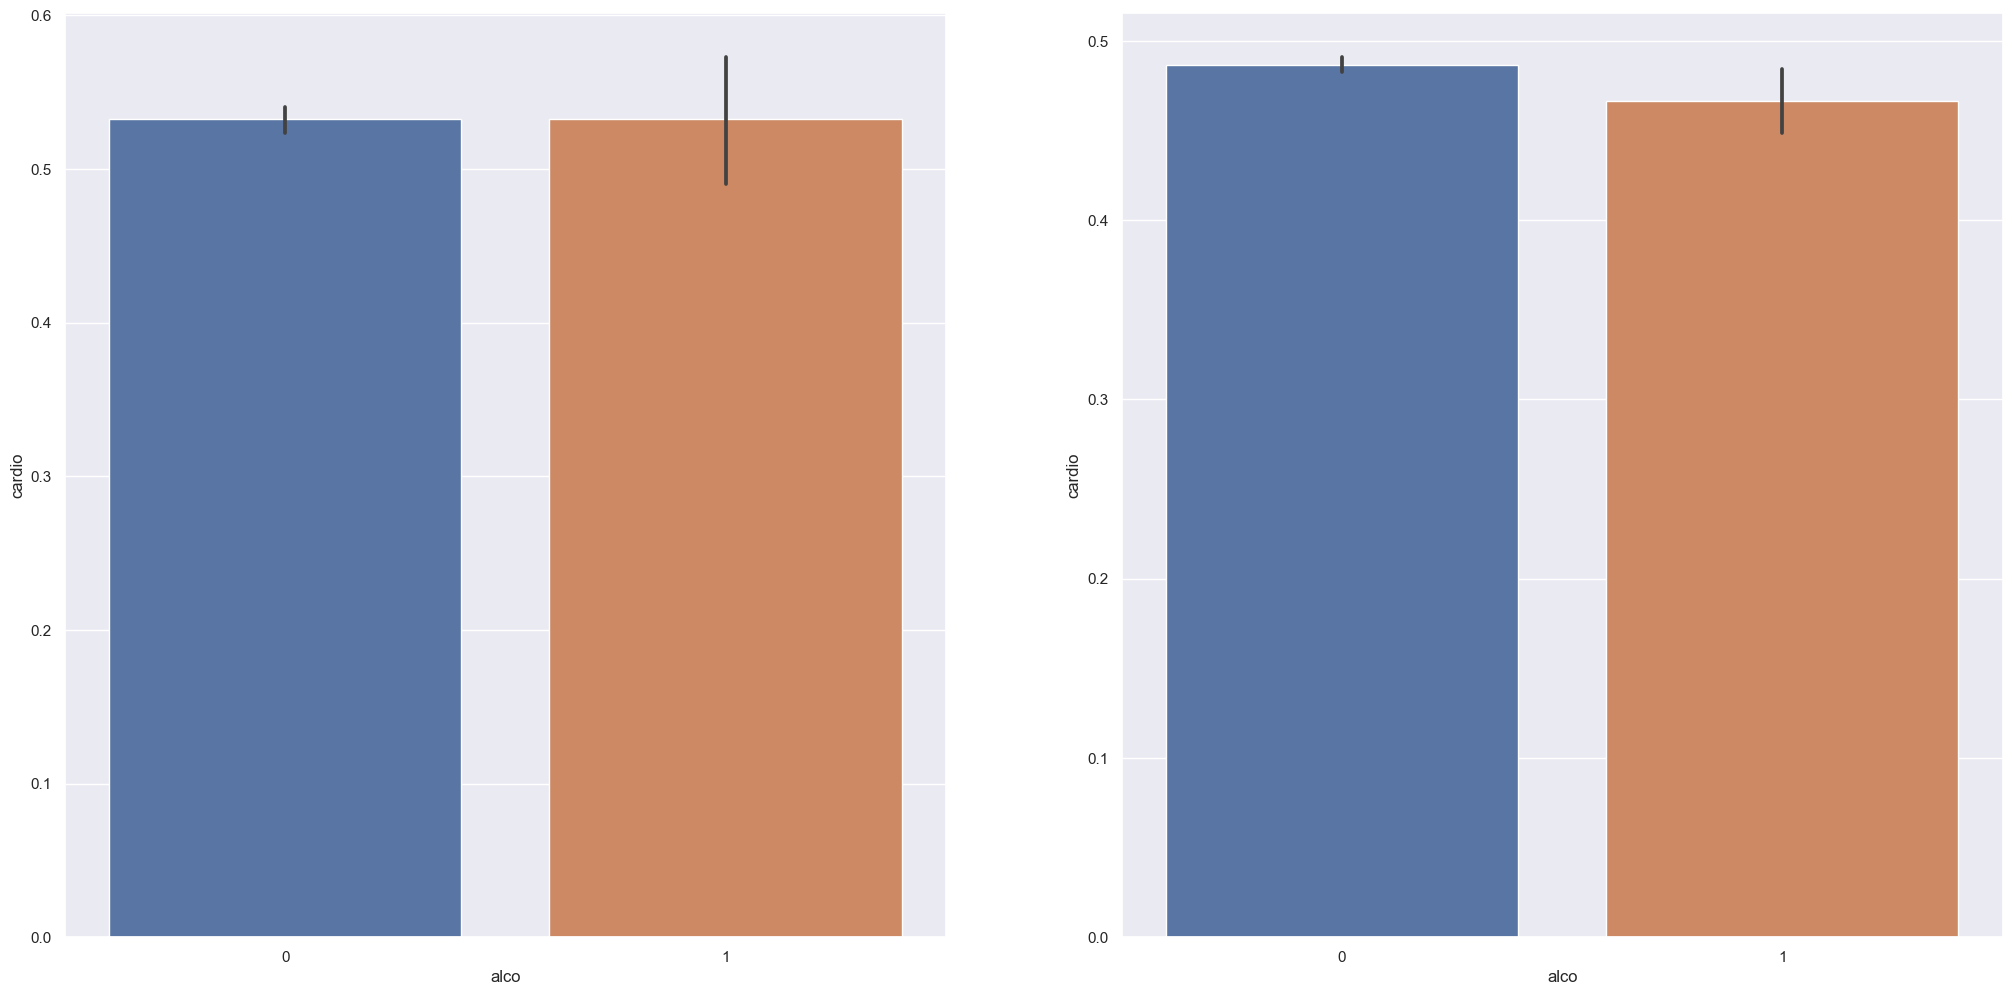

In [111]:
aux1 = df4.loc[(df4['active'] == 0)]
aux2 = df4.loc[(df4['active'] == 1)]

plt.subplot(1, 2, 1)
sns.barplot(x='alco', y='cardio', data=aux1)

plt.subplot(1, 2, 2)
sns.barplot(x='alco', y='cardio', data=aux2);


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

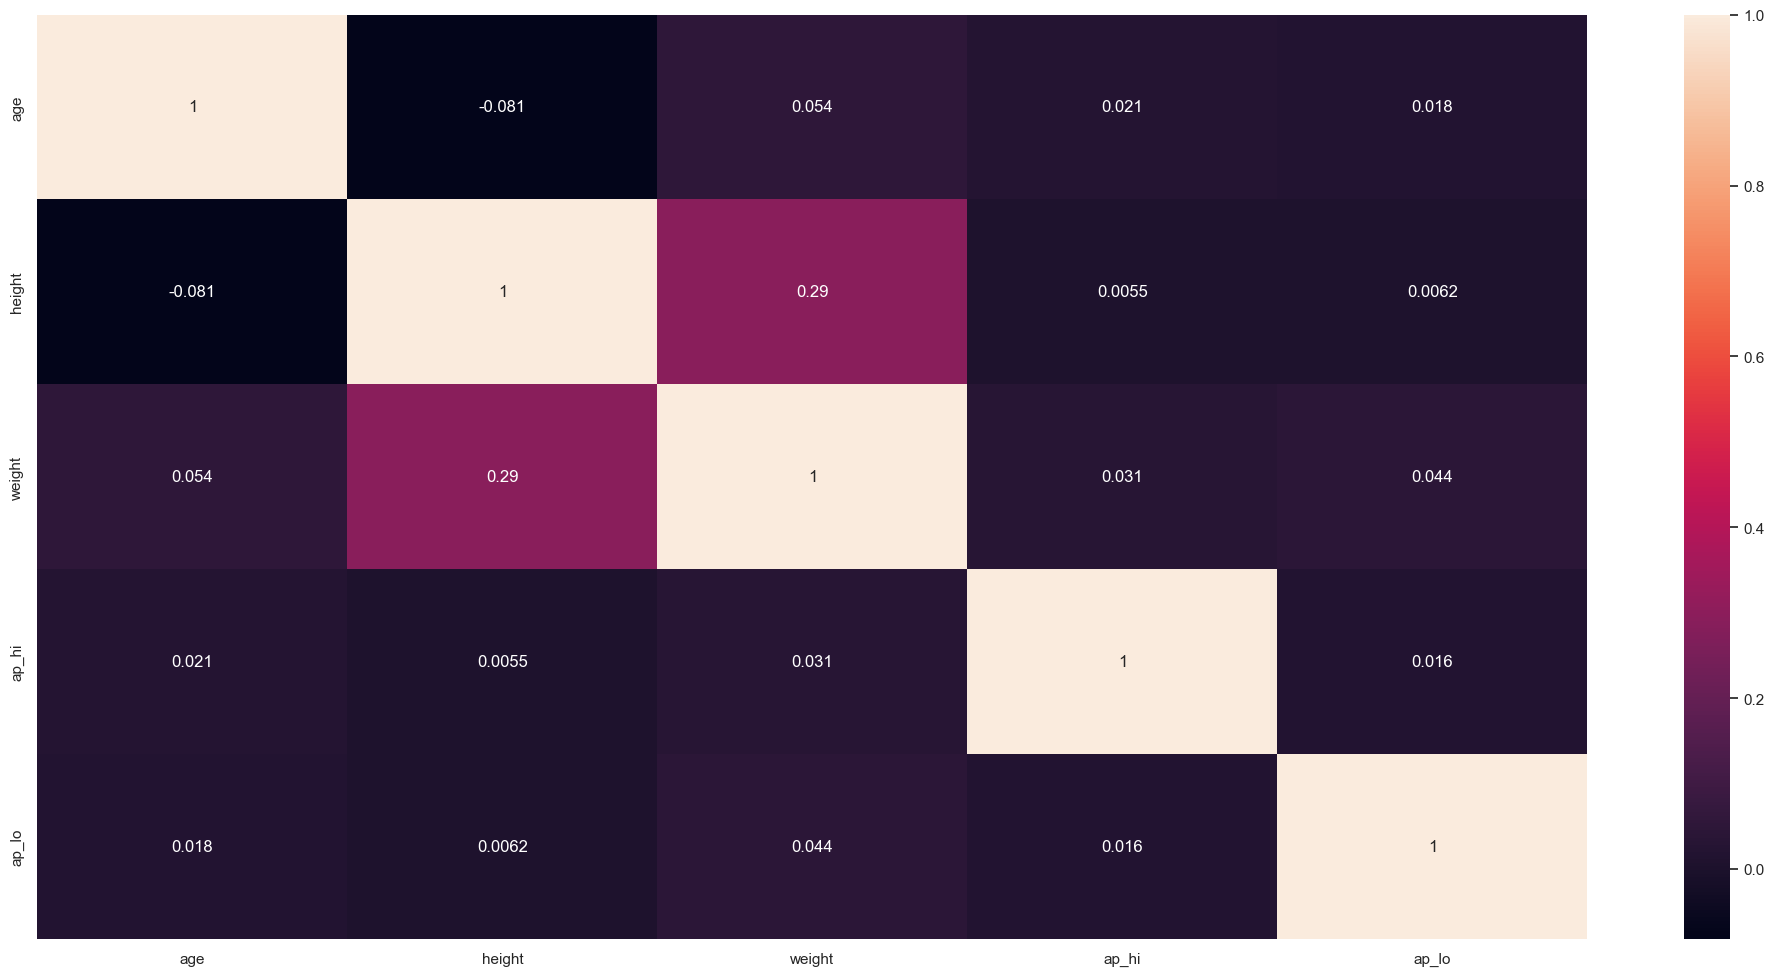

In [112]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

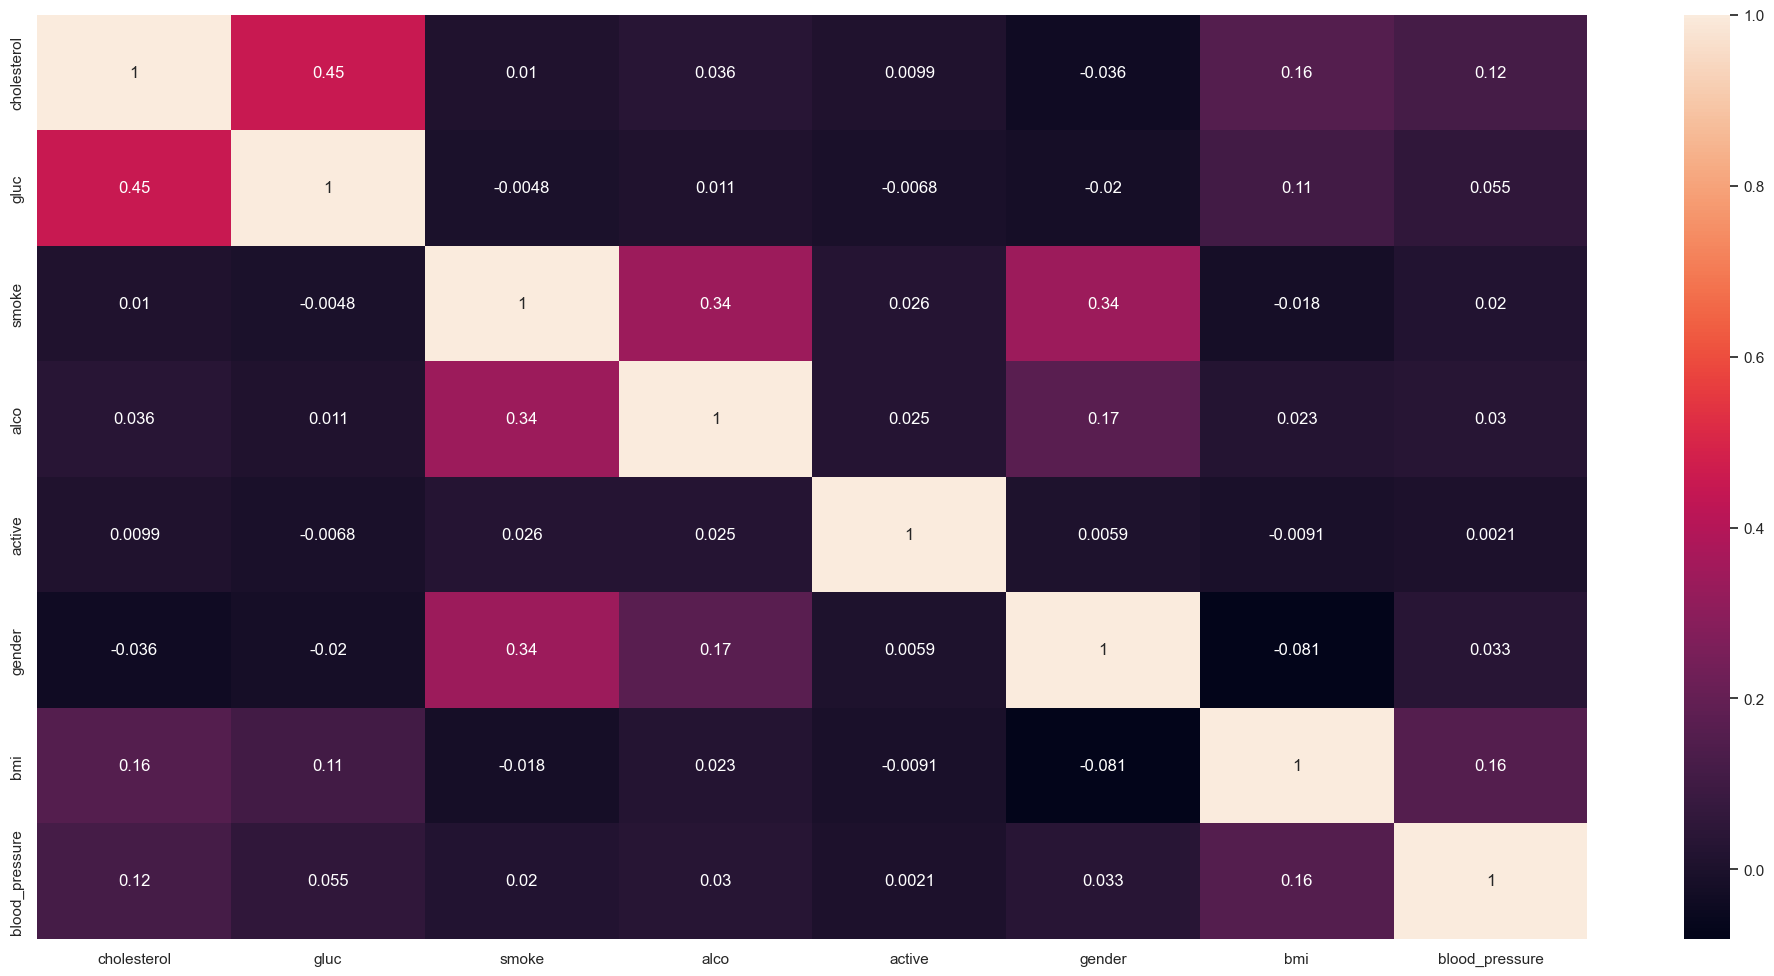

In [113]:
correlation = cat_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5.0. Data Preparation

In [114]:
df5 = df4.copy()

## 5.1. Rescaling

In [115]:
num_attributes.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], dtype='object')

In [116]:
cat_attributes.columns

Index(['cholesterol', 'gluc', 'smoke', 'alco', 'active', 'gender', 'bmi',
       'blood_pressure'],
      dtype='object')

In [117]:
rs = RobustScaler()
# height
df5['height'] = rs.fit_transform(df5[['height']].values)

# weight
df5['weight'] = rs.fit_transform(df5[['weight']].values)

mms = MinMaxScaler()
df5['bmi'] = rs.fit_transform(df5[['bmi']].values)

# age -> novo
df5['age'] = mms.fit_transform(df5[['age']].values)

# ap_hi
df5['ap_hi'] = mms.fit_transform(df5[['ap_hi']].values)

# ap_lo
df5['ap_lo'] = mms.fit_transform(df5[['ap_lo']].values)

## 5.2. Transformation

In [118]:
# Although most of the categorical data is represented as ordinal numbers,
# it is good to encode binary data when they are assigned to represent yes and no.

le = LabelEncoder()
df5['smoke'] = le.fit_transform(df5['smoke'])

df5['alco'] = le.fit_transform(df5['alco'])

df5['active'] = le.fit_transform(df5['active'])

df5['gender'] = le.fit_transform(df5['gender'])

In [119]:
df5.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,blood_pressure
0,0.57,1,0.27,-0.59,0.28,0.46,1,1,0,0,1,0,-0.50,1
1,0.71,0,-0.82,0.76,0.44,0.54,3,1,0,0,1,1,0.50,1
2,0.63,0,0.00,-0.47,0.39,0.38,3,1,0,0,0,1,-0.50,1
3,0.51,1,0.36,0.59,0.50,0.62,1,1,0,0,1,1,0.00,2
4,0.51,0,-0.82,-0.94,0.22,0.31,1,1,0,0,0,0,-0.50,1


# 6.0. Feature Selection

In [120]:
df6 = df5.copy()

## 6.1. Feature Selection With Boruta Algorithm

In [121]:
X = df6.drop('cardio', axis=1).copy()
y = df6['cardio']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split remaining data into validation set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### 6.1.2. Extra Trees

In [122]:
# extraTreesClassifier

x_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define model
et = ExtraTreesClassifier(n_estimators = 250, n_jobs=-1)

# define boruta
boruta_et = BorutaPy(et, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	9
Iteration:

In [123]:
cols_selected_et = boruta_et.support_.tolist()

# best features according to ExtraTreesClassifier
x_train_et = X_train
cols_selected_boruta_et = x_train_et.iloc[:, cols_selected_et].columns.to_list()

# not selected boruta
cols_not_selected_boruta_et = list(np.setdiff1d(x_train_et.columns, cols_selected_boruta_et))

In [124]:
# model definition
extratrees = ExtraTreesClassifier(n_estimators=250, random_state = 0, n_jobs = -1)

# data preparation
extratrees.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
          feature  importance
0          height        0.21
0          weight        0.21
0             age        0.16
0           ap_hi        0.16
0           ap_lo        0.08
0     cholesterol        0.05
0  blood_pressure        0.04
0             bmi        0.03
0            gluc        0.02
0          gender        0.01
0          active        0.01
0           smoke        0.01
0            alco        0.01


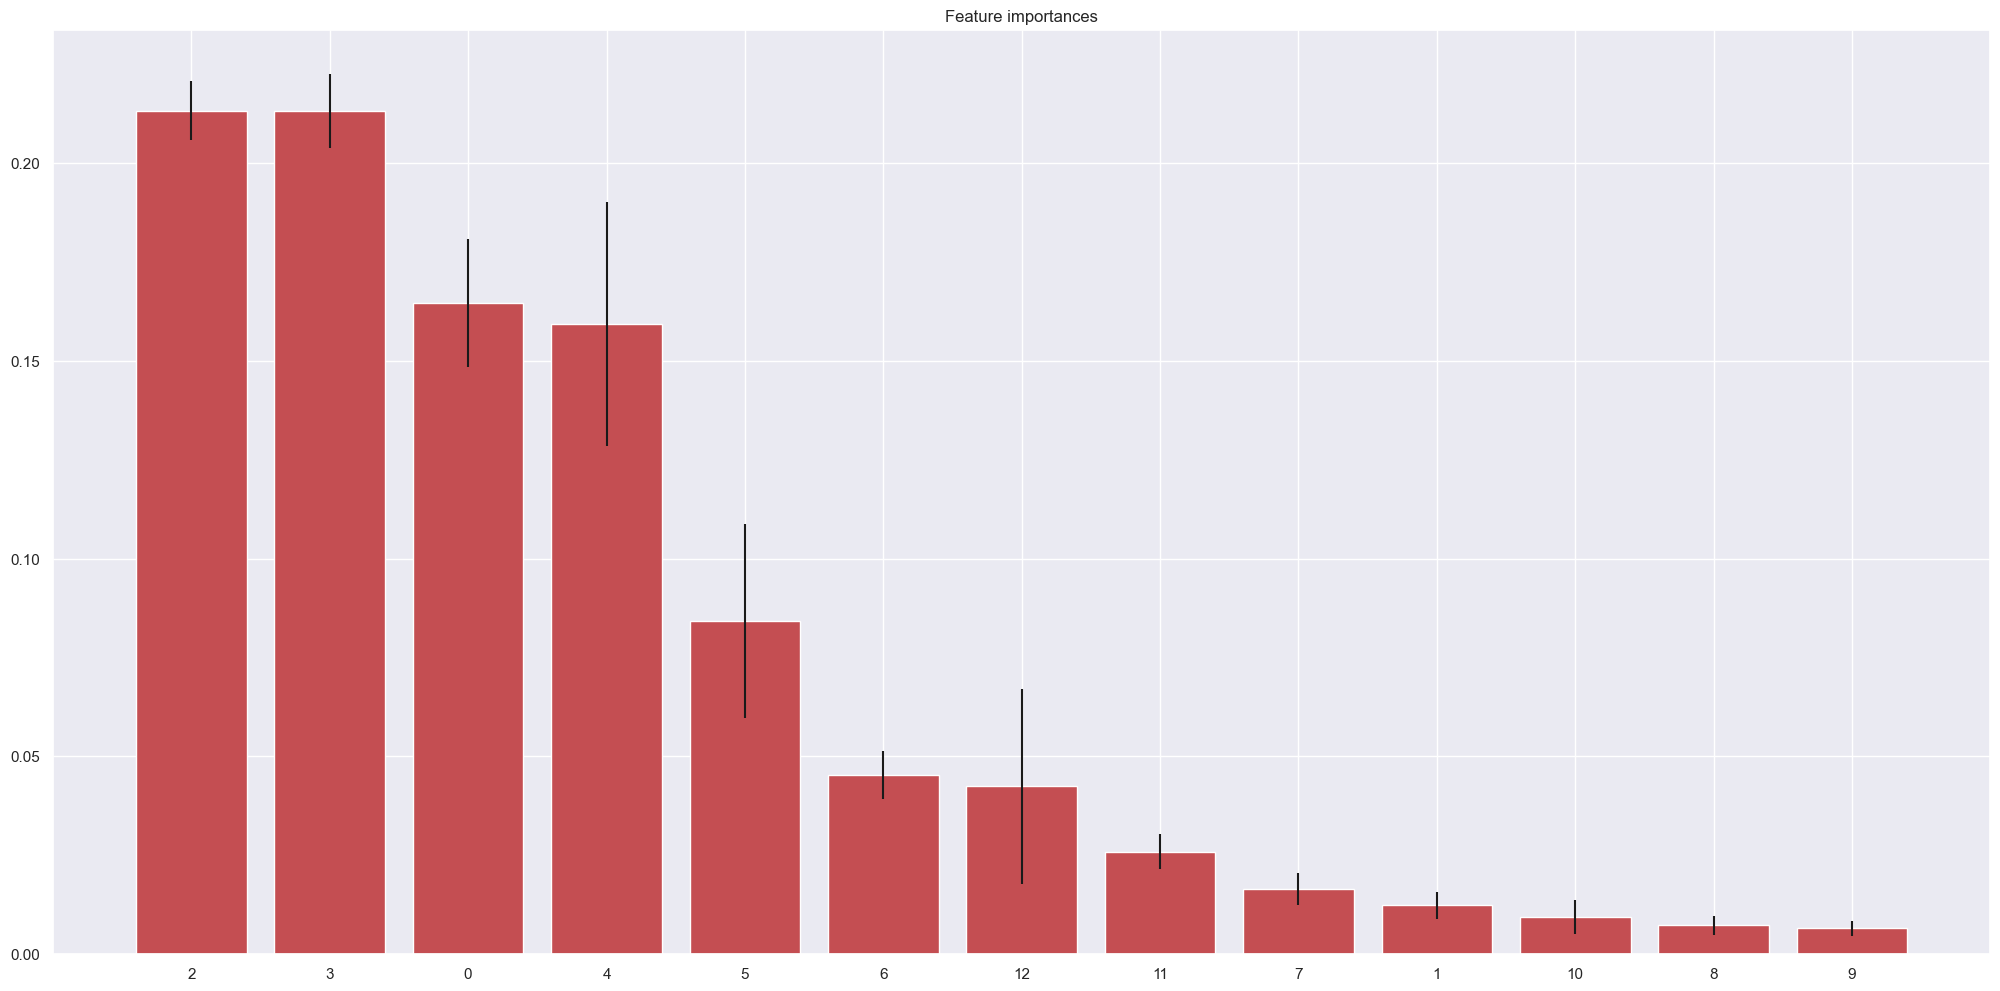

In [125]:
importances = extratrees.feature_importances_
std = np.std([tree.feature_importances_ for tree in extratrees.estimators_], axis=0)
indexes = np.argsort(importances)[::-1]

# feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_et, extratrees.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
plt.xticks(range(x_train_n.shape[1]), indexes)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

### 6.1.3. Random Forest

In [126]:
# randomForestClassifier

x_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define model
rf = RandomForestClassifier(n_estimators = 250, n_jobs=-1)

# define Boruta
boruta_rf = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	11


In [127]:
cols_selected_rf = boruta_et.support_.tolist()

# best features according to ExtraTreesClassifier
x_train_rf = X_train
cols_selected_boruta_rf = x_train_et.iloc[:, cols_selected_rf].columns.to_list()

# not selected boruta
cols_not_selected_boruta_rf = list(np.setdiff1d(x_train_rf.columns, cols_selected_boruta_rf))

In [128]:
# model definition
randomforest = RandomForestClassifier(n_estimators=250, random_state = 0, n_jobs = -1)

# data preparation
randomforest.fit(x_train_n, y_train_n)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
          feature  importance
0          weight        0.21
0          height        0.20
0             age        0.17
0           ap_hi        0.16
0           ap_lo        0.09
0     cholesterol        0.04
0  blood_pressure        0.03
0             bmi        0.03
0            gluc        0.02
0          gender        0.02
0          active        0.02
0           smoke        0.01
0            alco        0.01


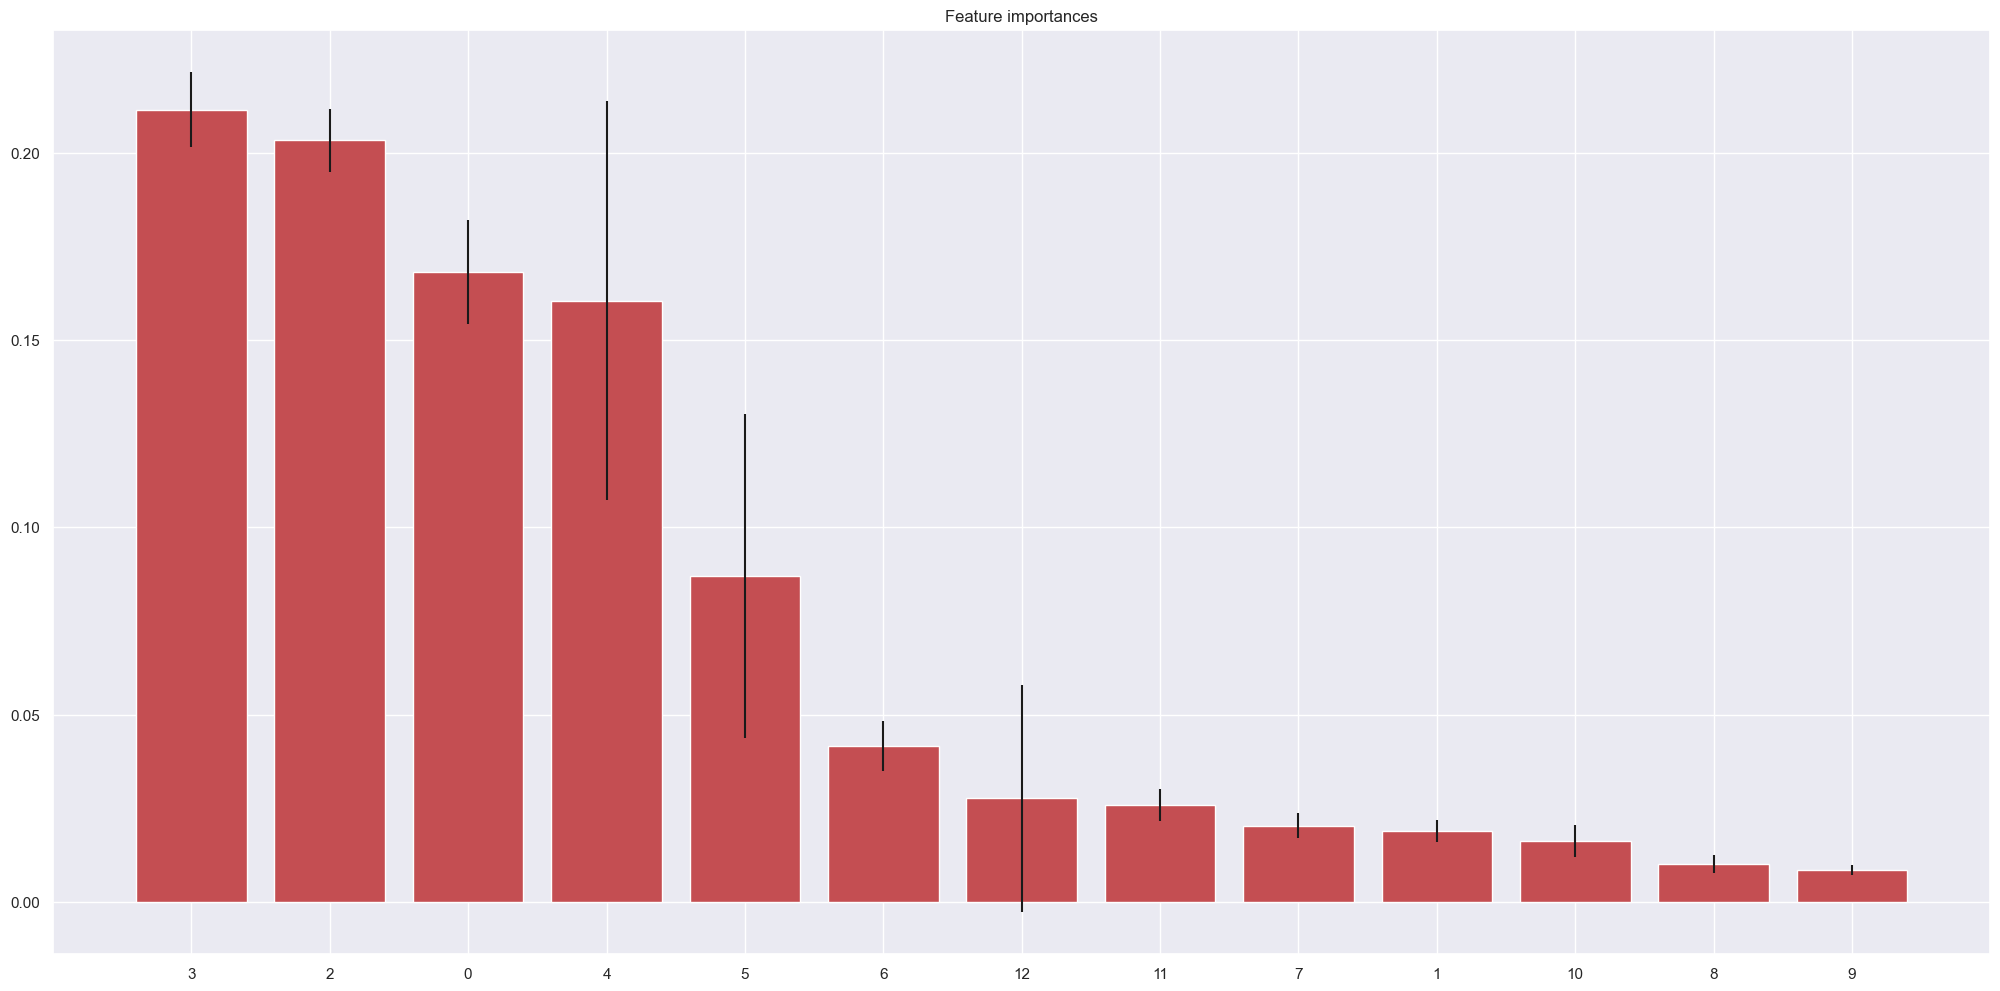

In [129]:
importances = randomforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforest.estimators_], axis=0)
indexes = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_rf, randomforest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
plt.xticks(range(x_train_n.shape[1]), indexes)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.2. Manual Feature Selection

In [130]:
# cols_selected_boruta = ['weight', 'height', 'age', 'ap_hi', 'ap_lo', 'bmi']
cols_selected_boruta = ['ap_hi','ap_lo','age','weight','height','blood_pressure','bmi','cholesterol']
feat_to_add = ['cardio']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [131]:
X_train = X_train[cols_selected_boruta]
X_test = X_test[cols_selected_boruta]
X_val = X_val[cols_selected_boruta]

# 7.0. Machine Learning Modelling

## 7.1. Average Model

Accuracy: 0.4889502762430939
Kappa Score: -0.022090286769223866
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      3492
           1       0.48      0.49      0.49      3386

    accuracy                           0.49      6878
   macro avg       0.49      0.49      0.49      6878
weighted avg       0.49      0.49      0.49      6878



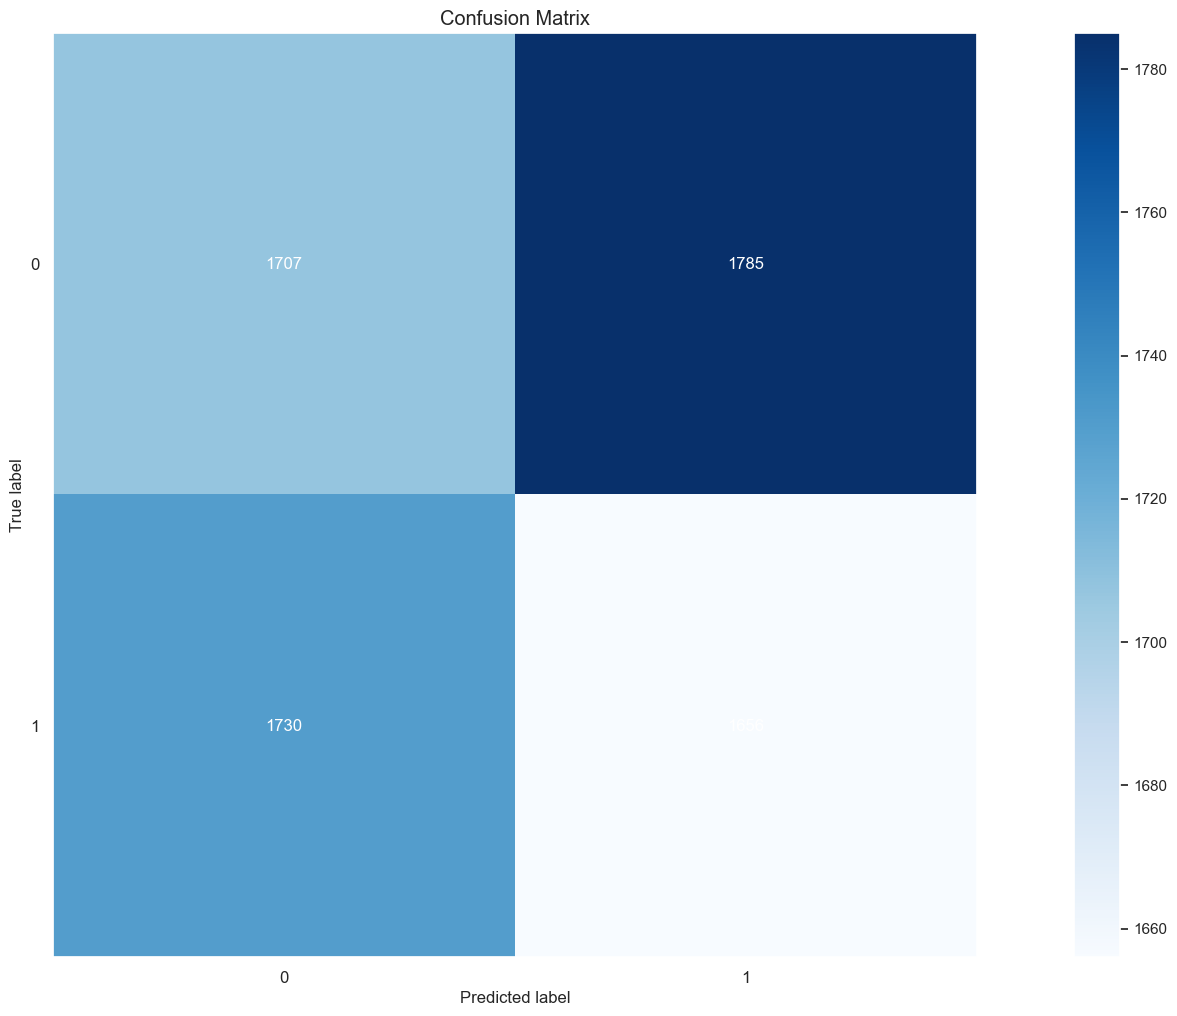

In [132]:
cardio = y_test.drop_duplicates().sort_values().tolist()
random_test = X_test.shape[0]
cardio_weights = df1['cardio'].value_counts( normalize=True ).sort_index().tolist()

# prediction
yhat_random = random.choices(cardio, k=random_test, weights=cardio_weights)

# performance
baseline = ml_performance('Average Model', y_test, yhat = yhat_random)

# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print( 'Accuracy: {}'.format(acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print( 'Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False);

## 7.2. Logistic Regression

Training set score: 0.726
Test set score: 0.730


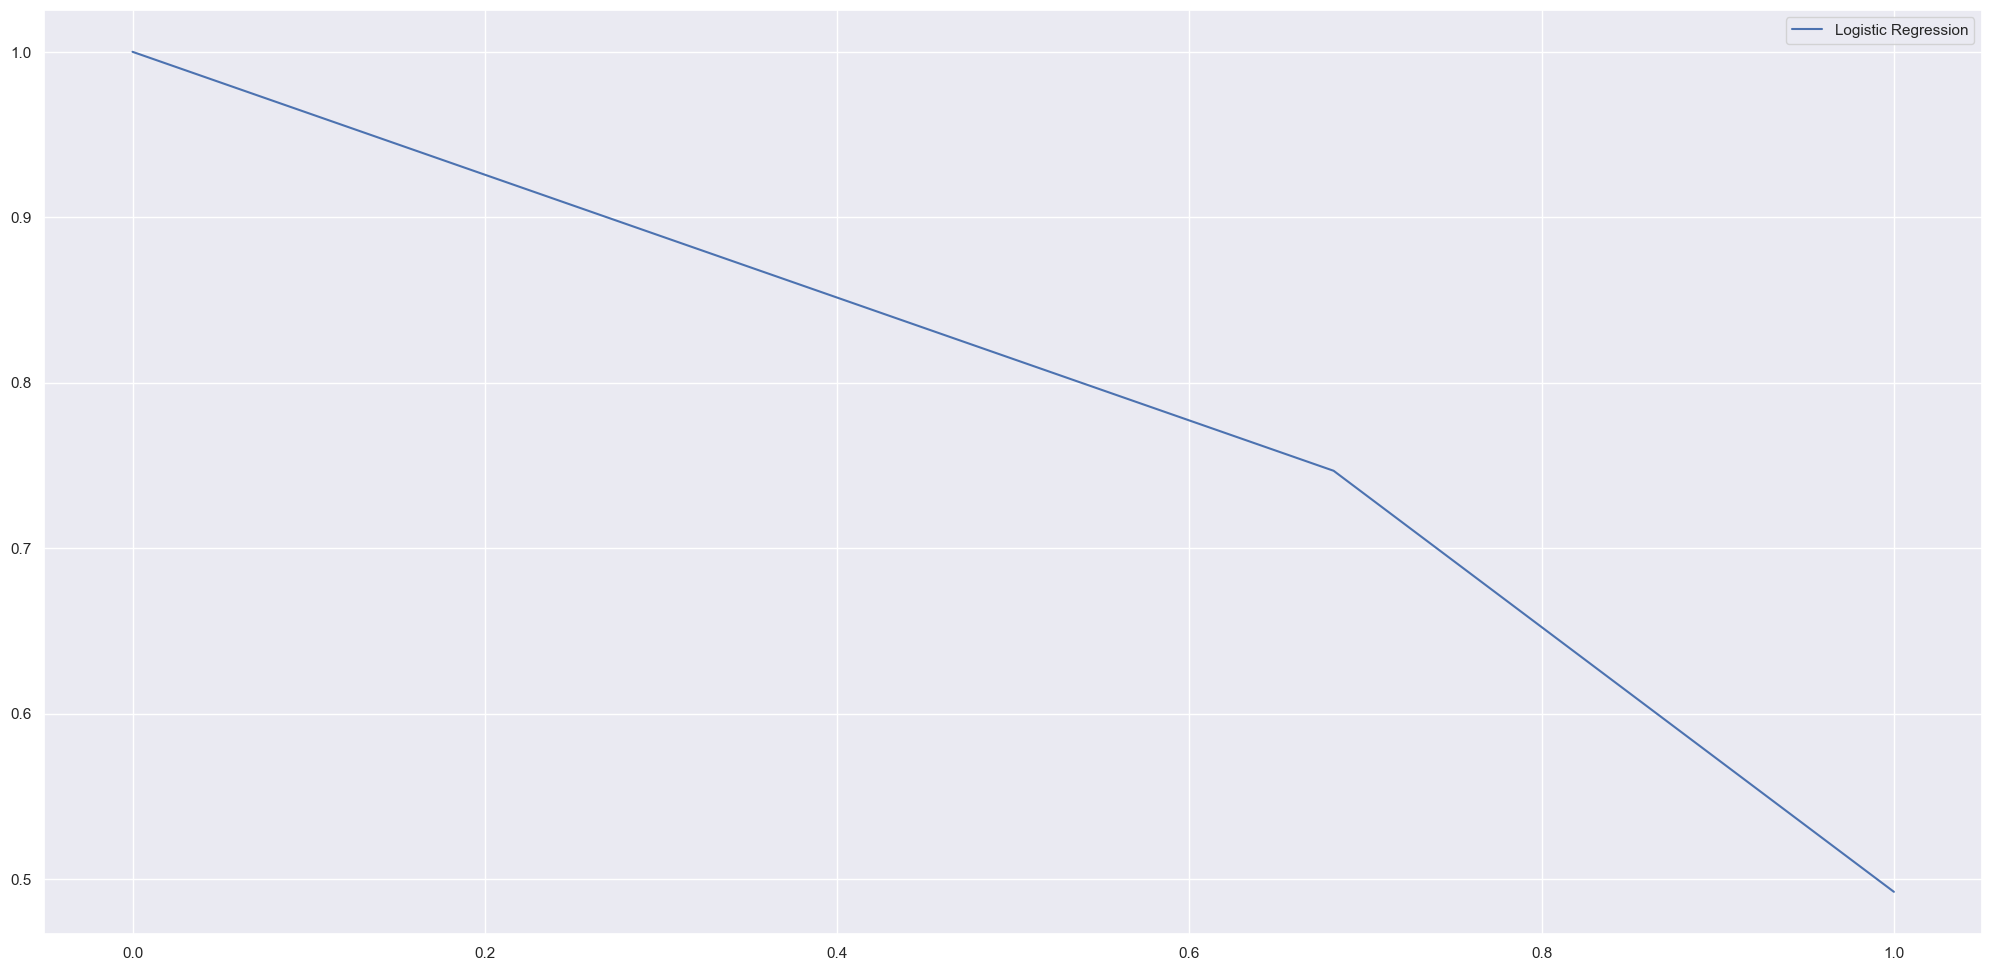

In [133]:
logreg = LogisticRegression(C=100, max_iter = 400)
yhat = logreg.fit(X_train, y_train).predict(X_test)

# performance
lr = ml_performance('Logistic Regression', y_test, yhat)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

# Precision-Recall curve
precision, recall, thresholds = m.precision_recall_curve(y_test, yhat)
sns.lineplot(x=recall, y=precision, label='Logistic Regression');

              precision    recall  f1-score   support

           0       0.72      0.78      0.74      3492
           1       0.75      0.68      0.71      3386

    accuracy                           0.73      6878
   macro avg       0.73      0.73      0.73      6878
weighted avg       0.73      0.73      0.73      6878



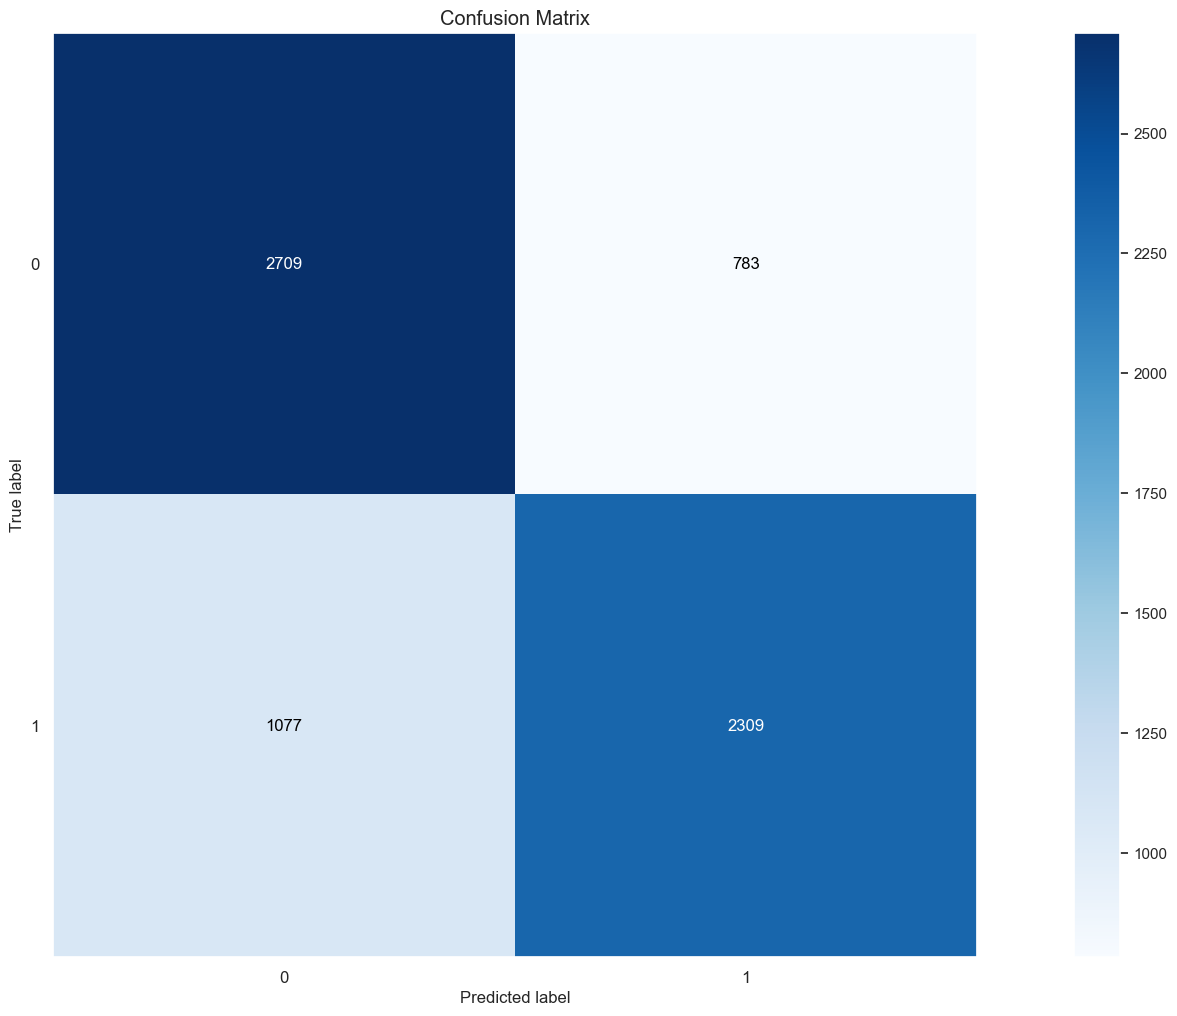

In [134]:
# Classification report
print(m.classification_report(y_test, yhat))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False);

## 7.3. Support Vector Machine

Training set score: 0.724
Test set score: 0.728


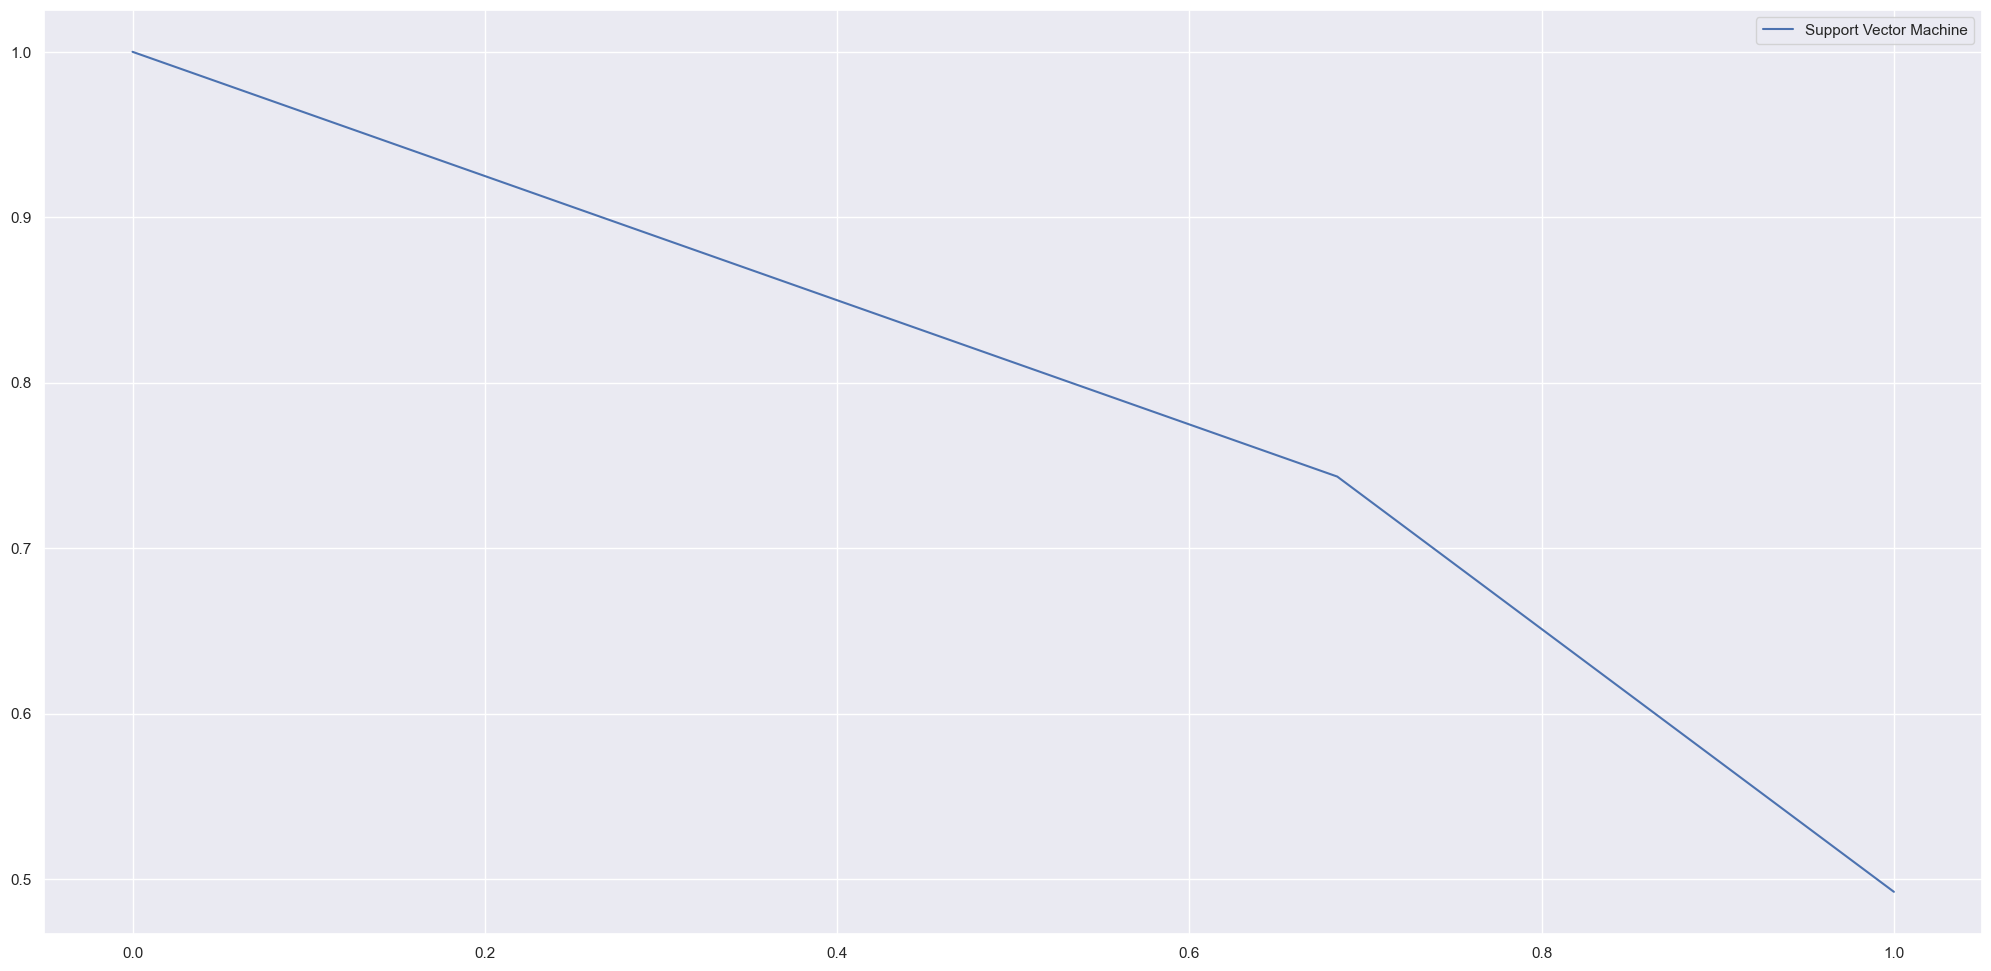

In [135]:
from sklearn.calibration import CalibratedClassifierCV
svm = LinearSVC(class_weight = 'balanced', C=0.01, random_state=42).fit(X_train, y_train)
svm = CalibratedClassifierCV(svm, method='sigmoid')
yhat = svm.fit(X_train, y_train).predict(X_test)


# performance
s_v_m = ml_performance('Support Vector Machine', y_test, yhat)
print("Training set score: {:.3f}".format(svm.score(X_train, y_train)))
print("Test set score: {:.3f}".format(svm.score(X_test, y_test)))

# Precision-Recall curve
precision, recall, thresholds = m.precision_recall_curve(y_test, yhat)
sns.lineplot(x=recall, y=precision, label='Support Vector Machine');

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      3492
           1       0.74      0.68      0.71      3386

    accuracy                           0.73      6878
   macro avg       0.73      0.73      0.73      6878
weighted avg       0.73      0.73      0.73      6878



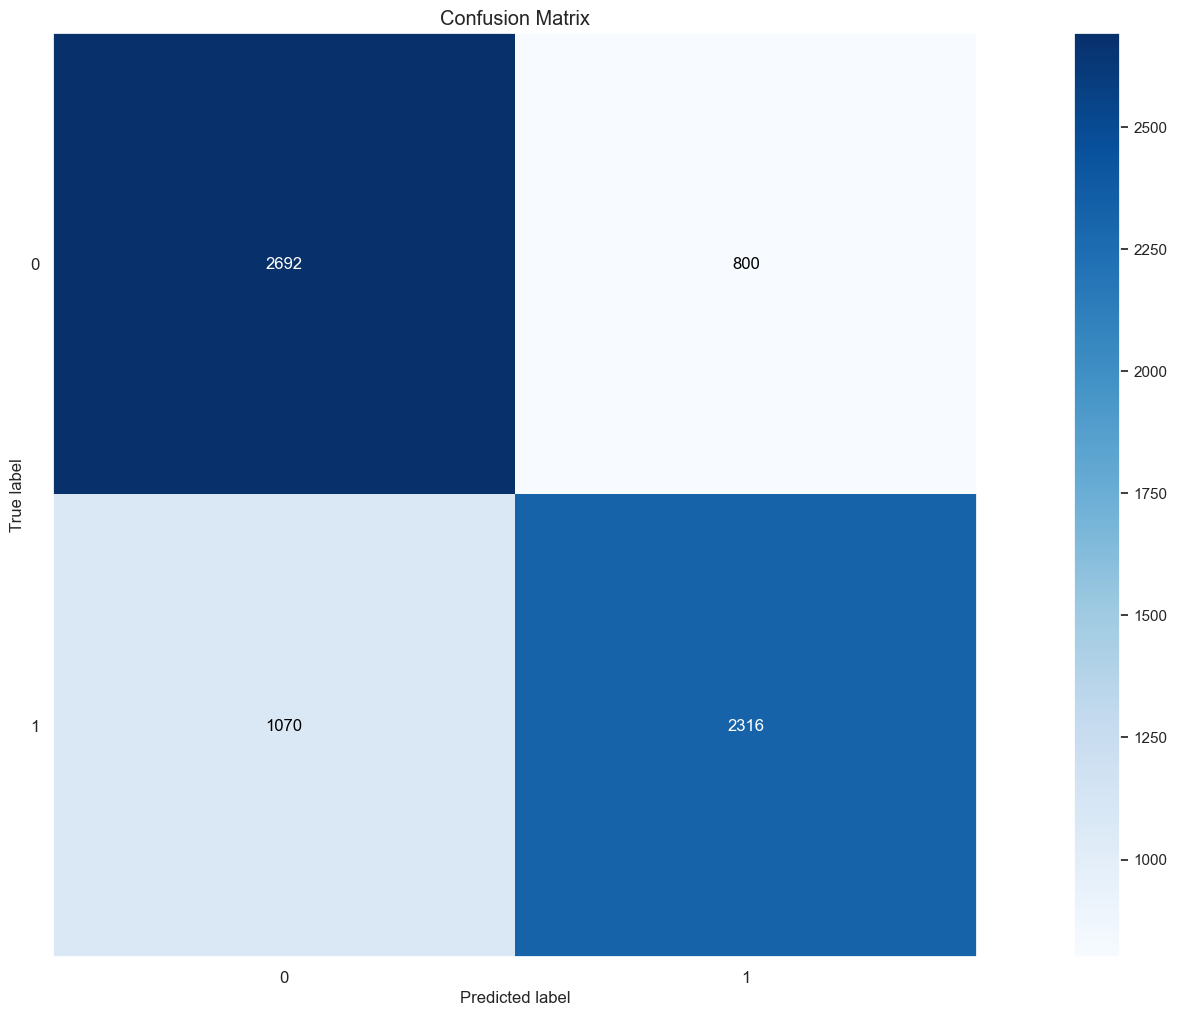

In [136]:
# Classification report
print(m.classification_report(y_test, yhat))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False);

## 7.3. K-Nearest Neighbors

Training set score: 0.761
Test set score: 0.690


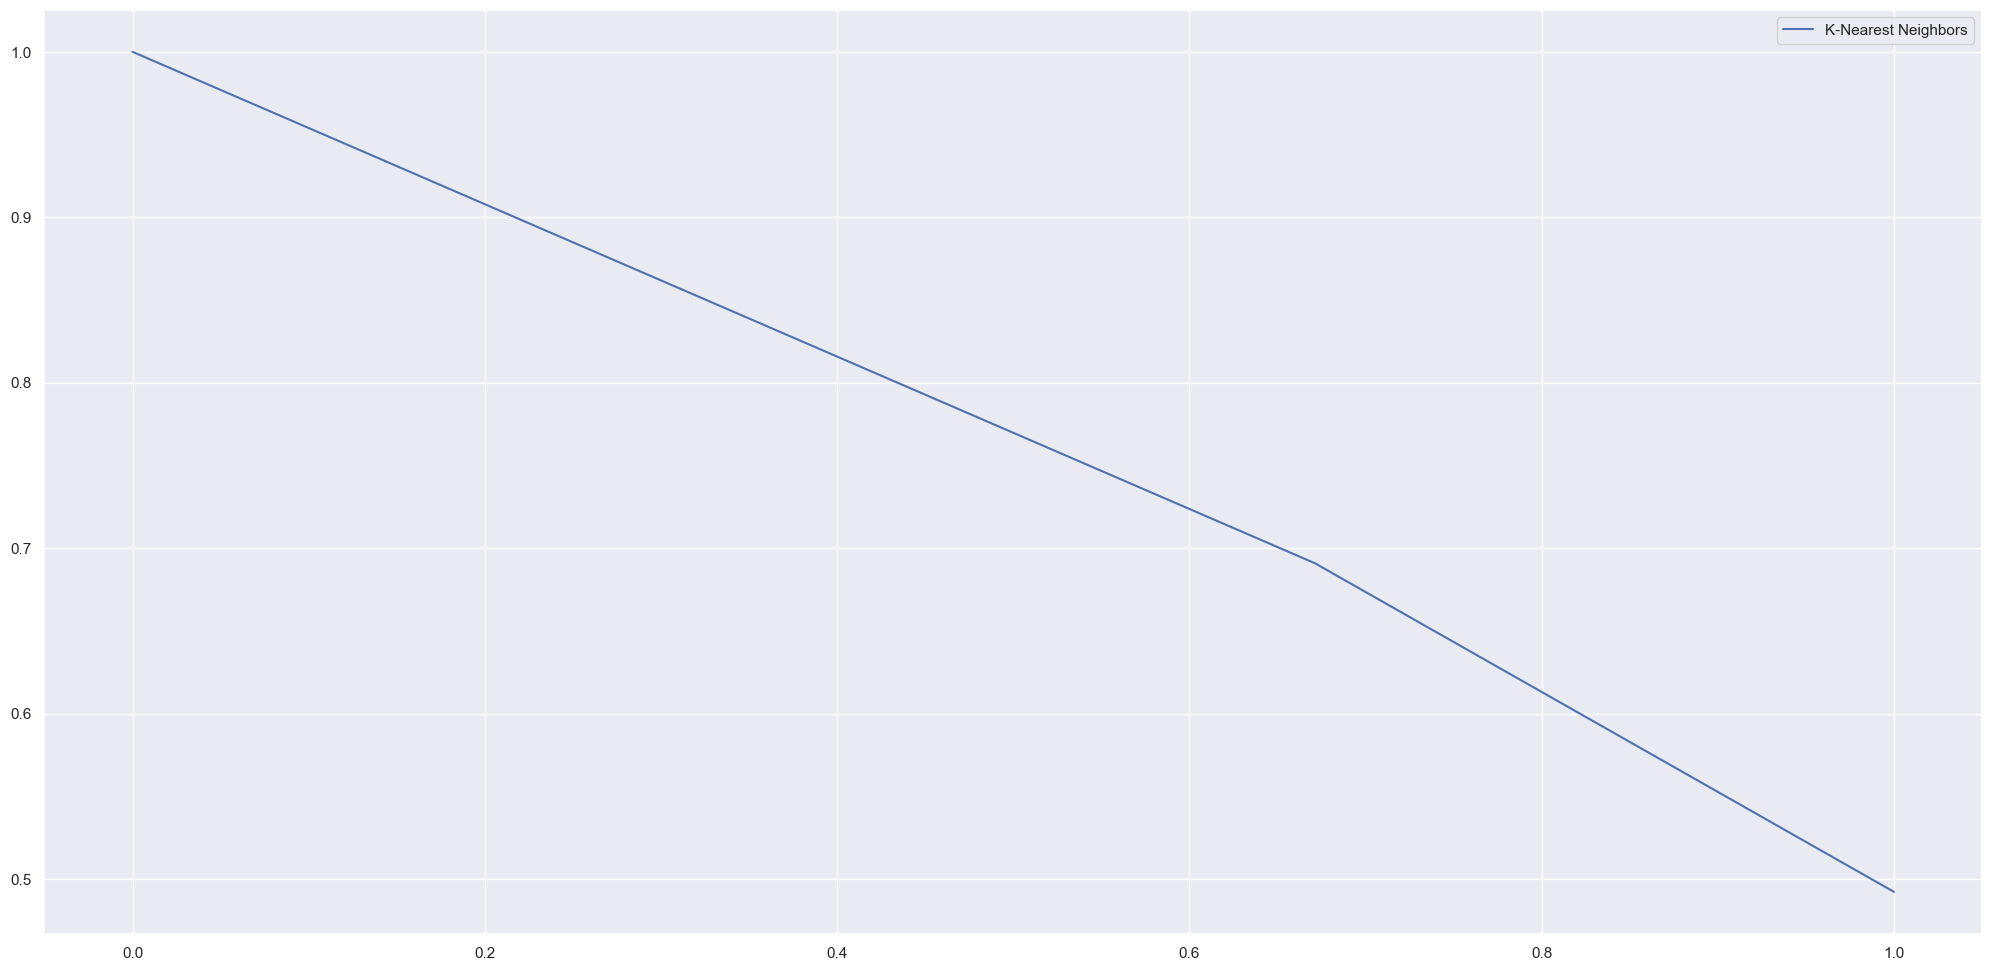

In [137]:
knn = KNeighborsClassifier(n_neighbors=7)
yhat = knn.fit(X_train, y_train).predict(X_test)

# performance
k_nn = ml_performance('k-Nearest Neighbors', y_test, yhat)
print("Training set score: {:.3f}".format(knn.score(X_train, y_train)))
print("Test set score: {:.3f}".format(knn.score(X_test, y_test)))

# Precision-Recall curve
precision, recall, thresholds = m.precision_recall_curve(y_test, yhat)
sns.lineplot(x=recall, y=precision, label='K-Nearest Neighbors');


              precision    recall  f1-score   support

           0       0.69      0.71      0.70      3492
           1       0.69      0.67      0.68      3386

    accuracy                           0.69      6878
   macro avg       0.69      0.69      0.69      6878
weighted avg       0.69      0.69      0.69      6878



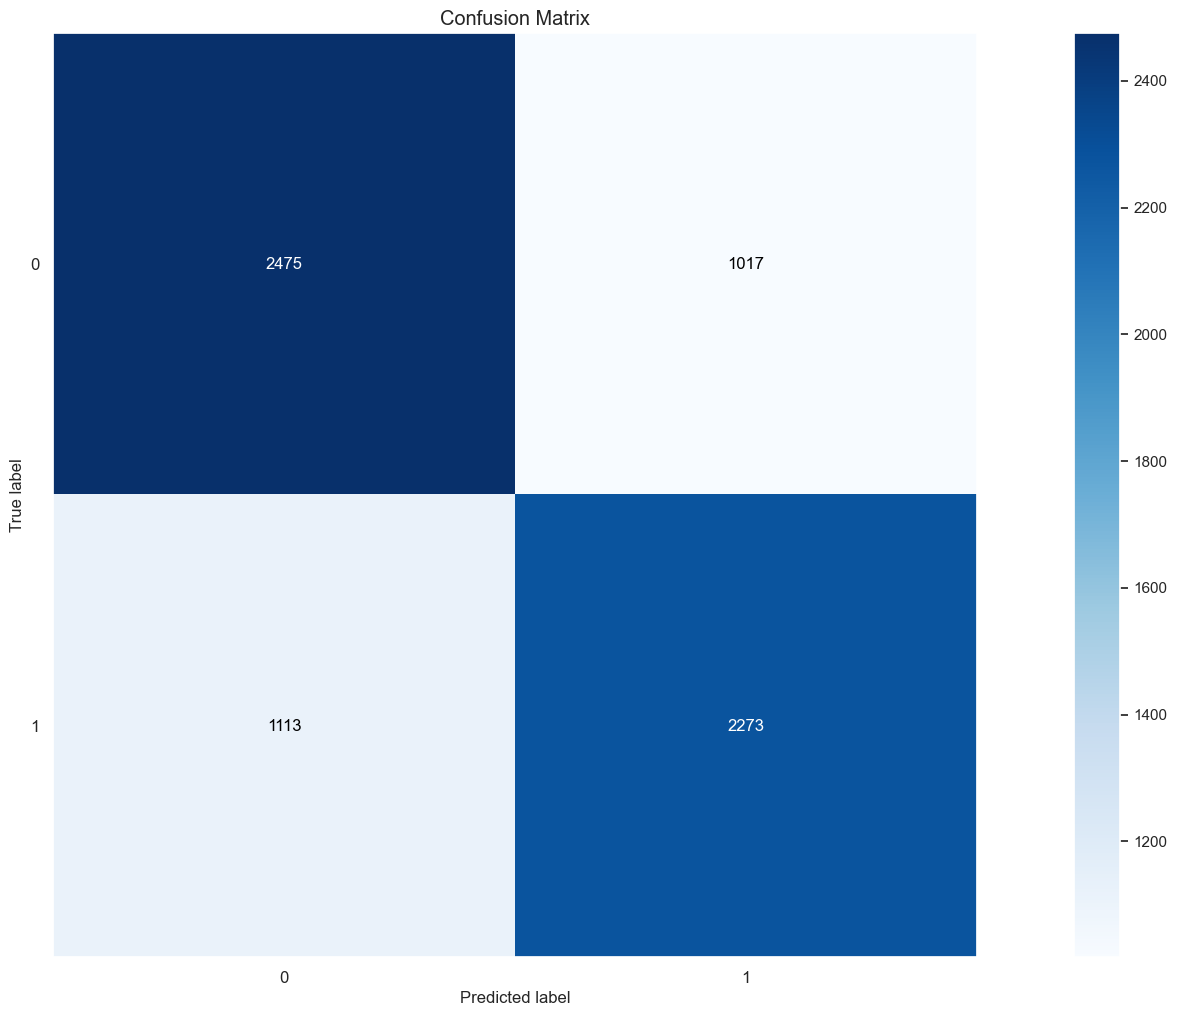

In [138]:
# Classification report
print(m.classification_report(y_test, yhat))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False);

## 7.4 Decision Tree

Accuracy on training set: 0.736
Accuracy on test set: 0.735


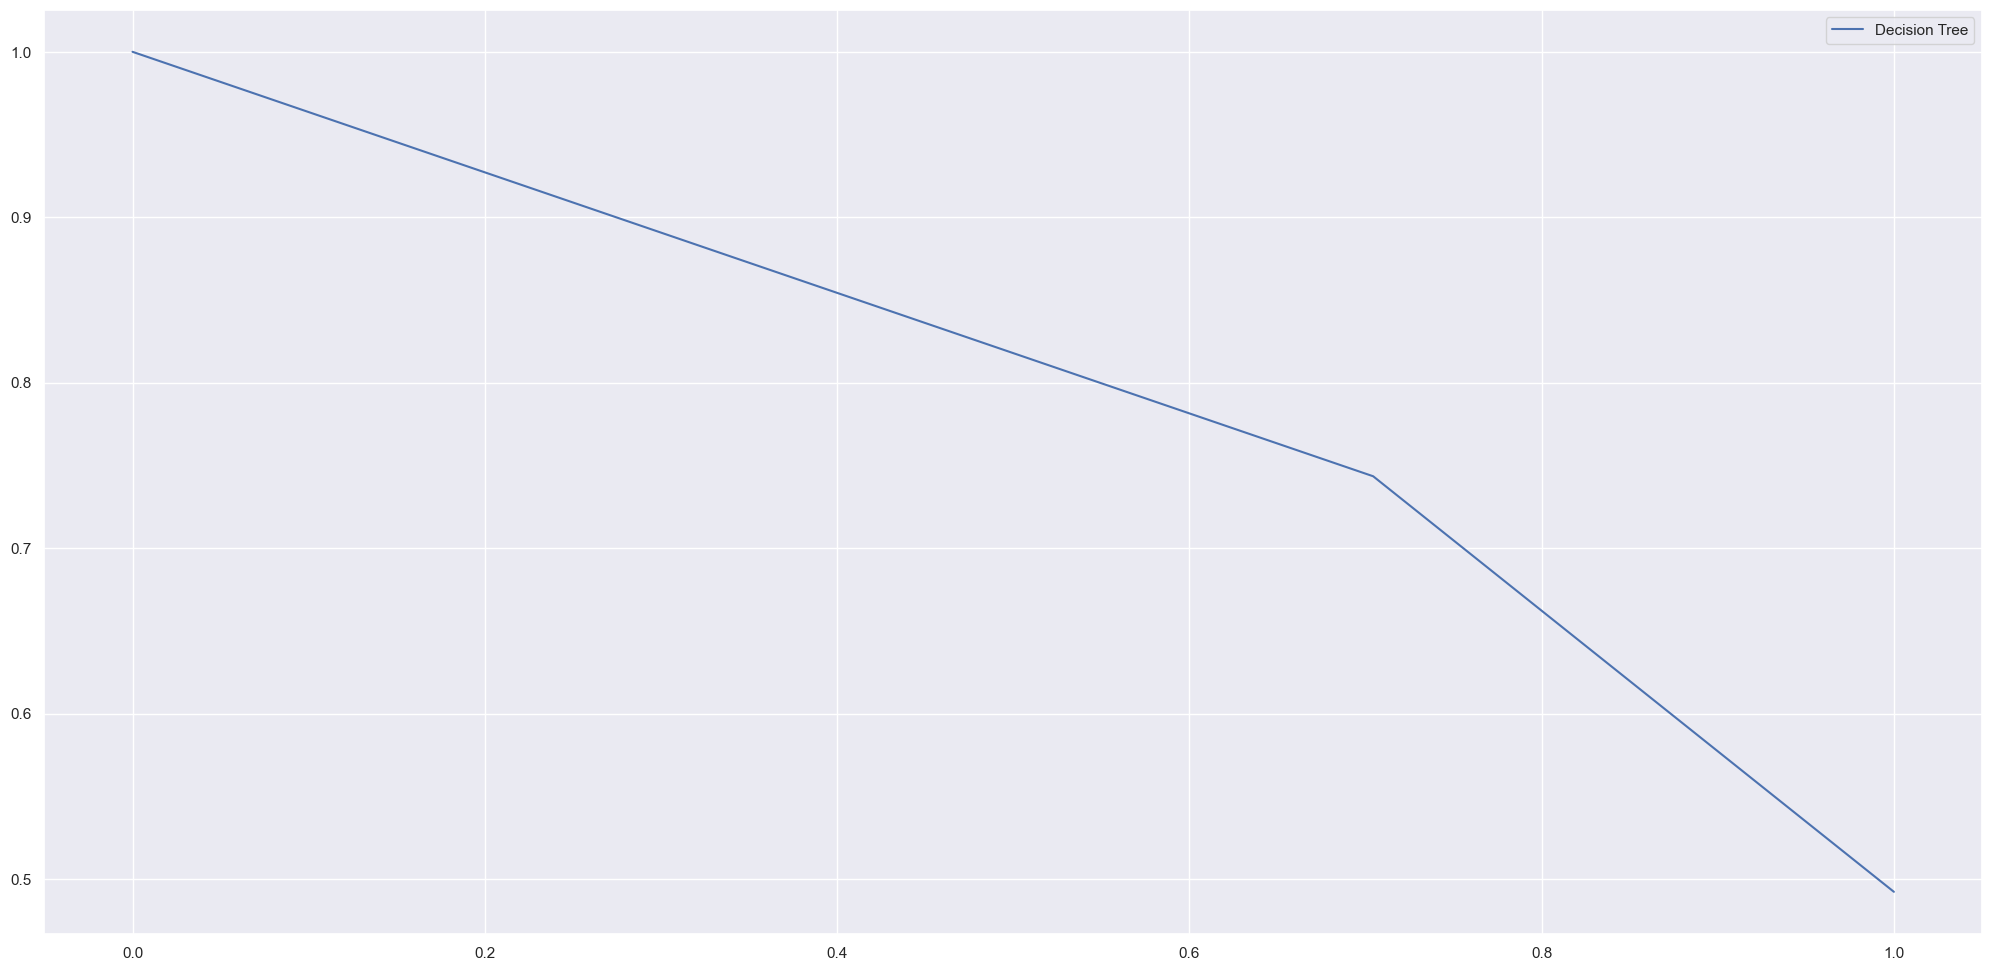

In [139]:
dt = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 2, random_state=42)
dt.fit(X_train, y_train)
yhat = dt.predict(X_test)

# performance
dtc = ml_performance('Decision Tree', y_test, yhat)
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

# Precision-Recall curve
precision, recall, thresholds = m.precision_recall_curve(y_test, yhat)
sns.lineplot(x=recall, y=precision, label='Decision Tree');

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      3492
           1       0.74      0.70      0.72      3386

    accuracy                           0.73      6878
   macro avg       0.74      0.73      0.73      6878
weighted avg       0.74      0.73      0.73      6878



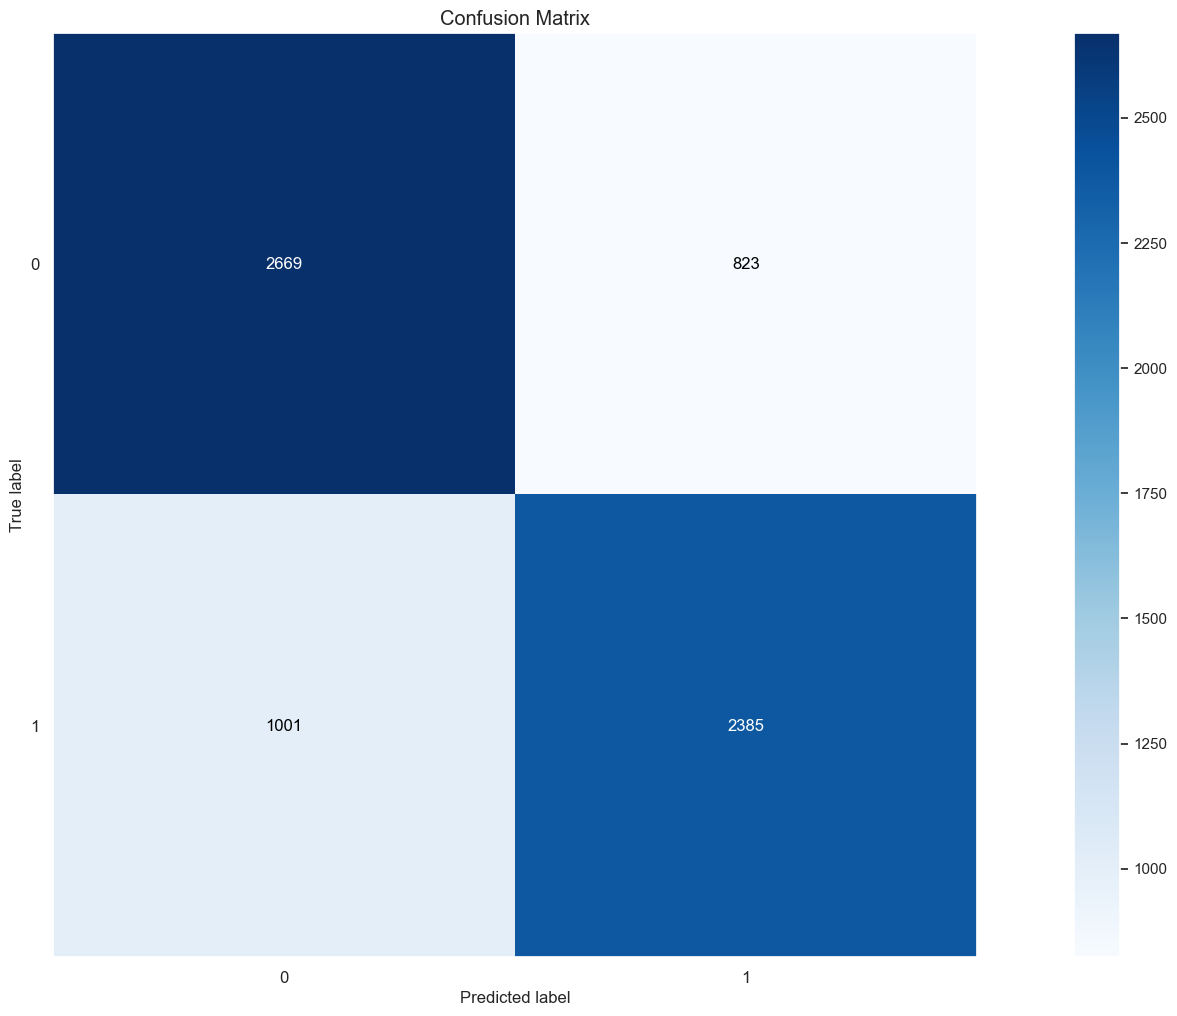

In [140]:
# Classification report
print(m.classification_report(y_test, yhat))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False);

## 7.5. Random Forest

Accuracy on training set: 0.934
Accuracy on test set: 0.684


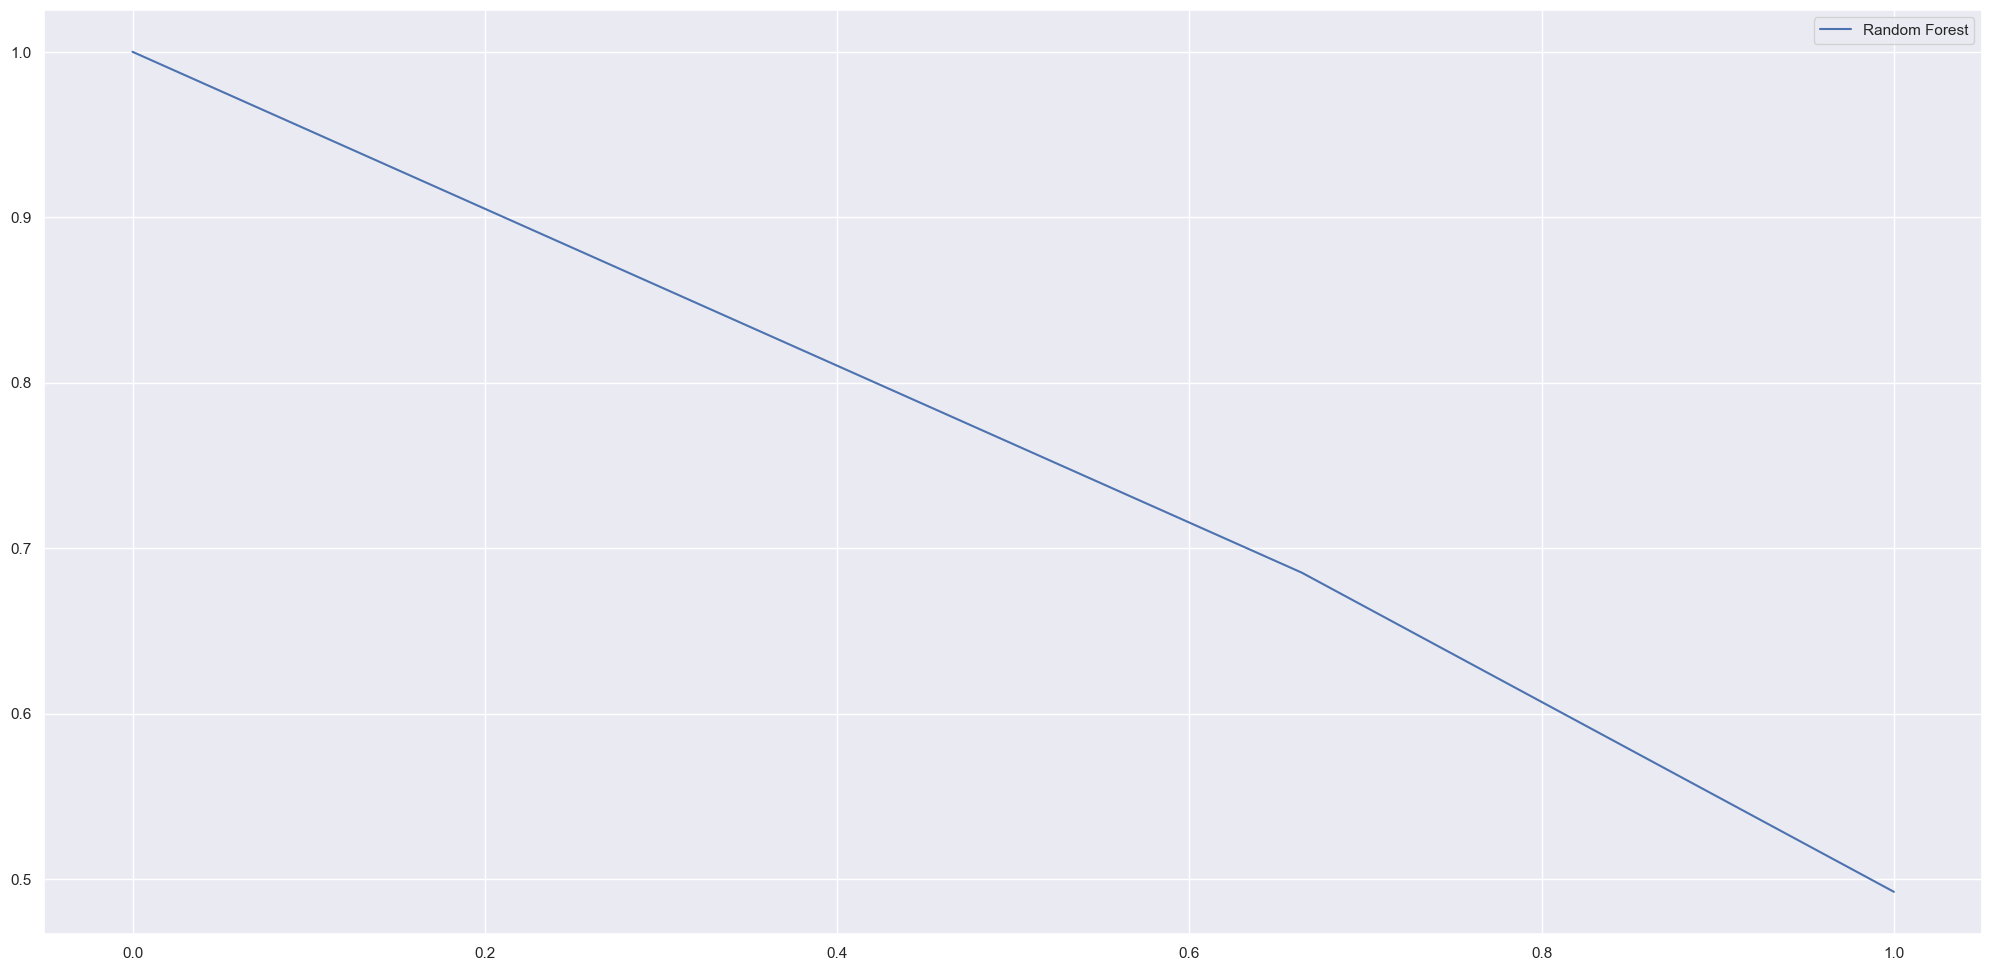

In [141]:
rf = RandomForestClassifier(n_estimators = 10, n_jobs = -1, random_state=42)
rf.fit(X_train, y_train)
yhat = rf.predict(X_test)

# performance
rfc = ml_performance('Random Forest', y_test, yhat)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

# Precision-Recall curve
precision, recall, thresholds = m.precision_recall_curve(y_test, yhat)
sns.lineplot(x=recall, y=precision, label='Random Forest');

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3492
           1       0.69      0.66      0.67      3386

    accuracy                           0.68      6878
   macro avg       0.68      0.68      0.68      6878
weighted avg       0.68      0.68      0.68      6878



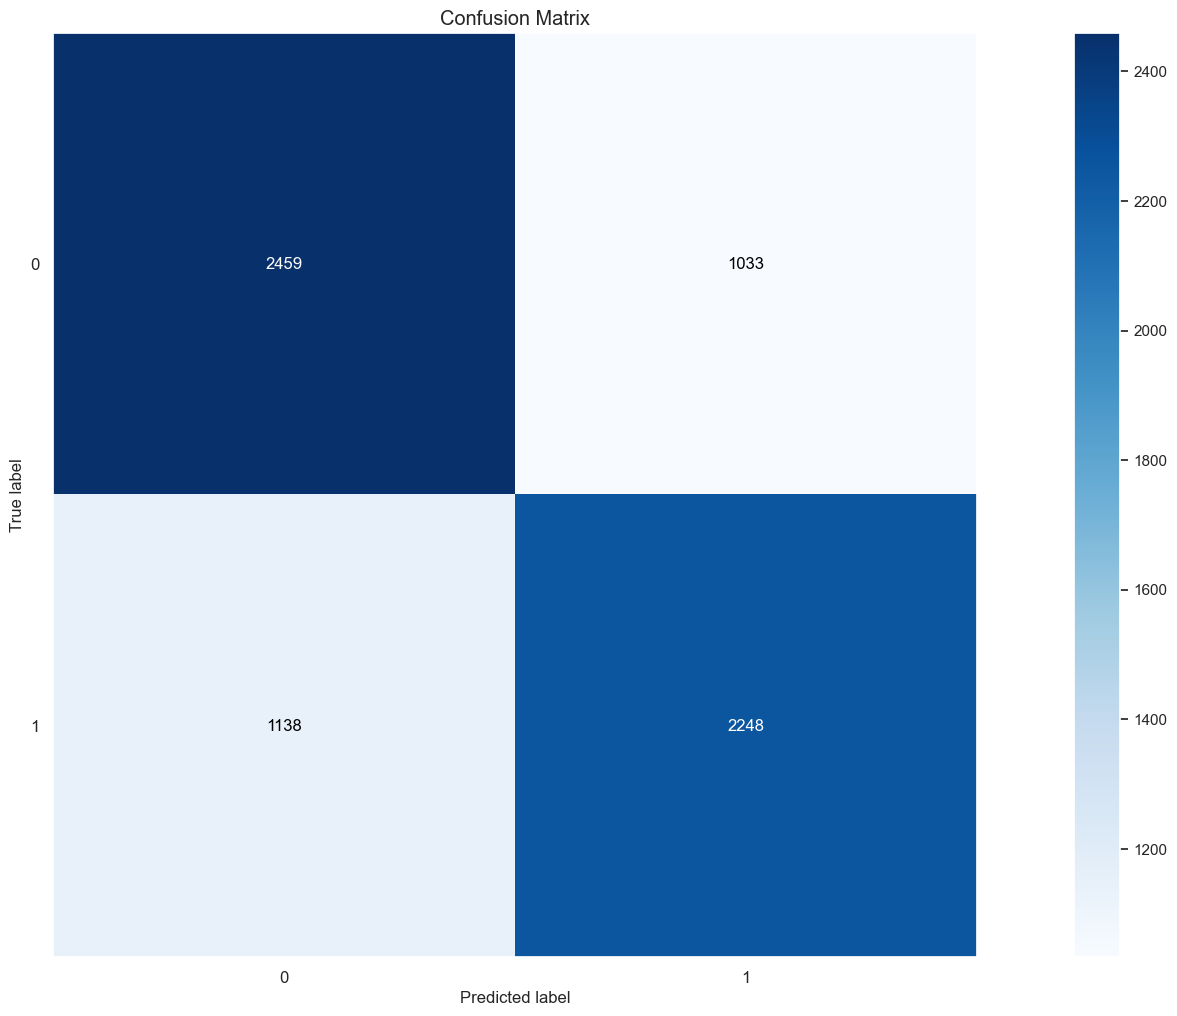

In [142]:
# Classification report
print(m.classification_report(y_test, yhat))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False);

## 7.6. XGBoost

Accuracy on training set: 0.751
Accuracy on test set: 0.737


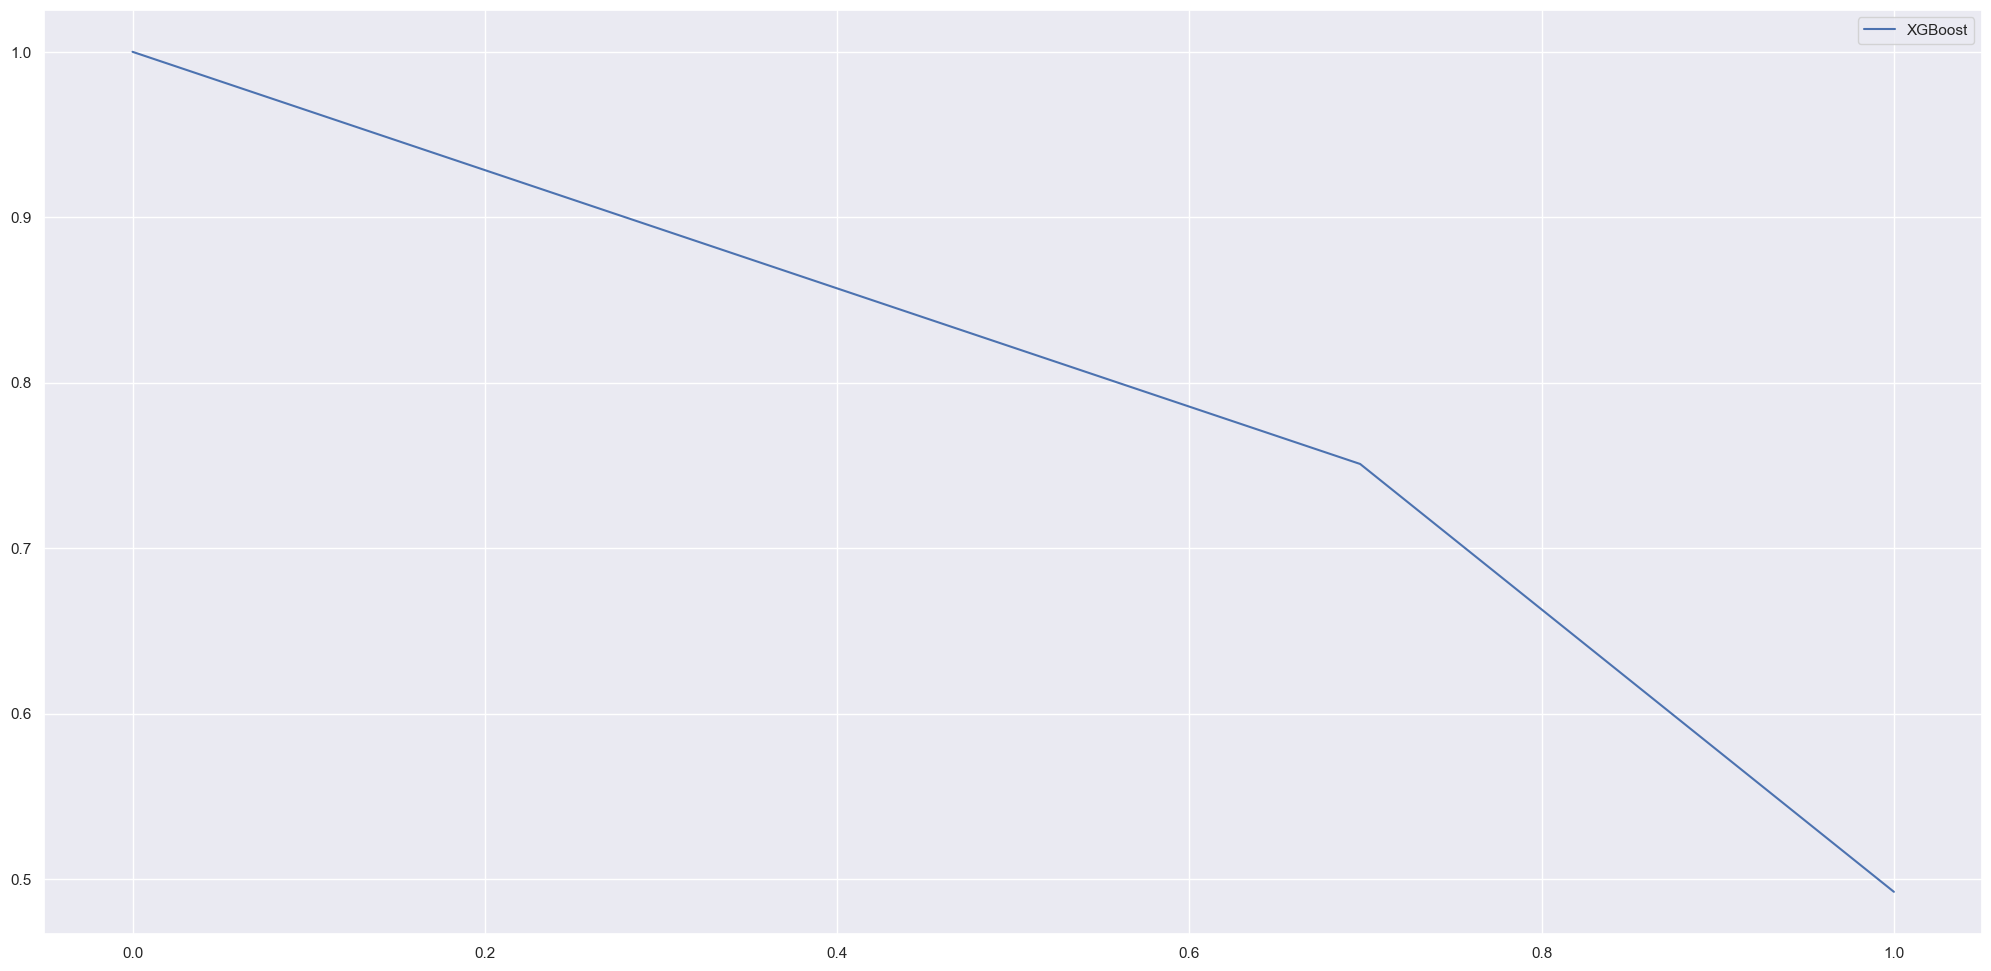

In [143]:
xgb_model = xgb.XGBClassifier(n_jobs = -1)
xgb_model.fit(X_train,y_train)
yhat = xgb_model.predict(X_test)

# performance
xgb = ml_performance('XGBoost', y_test, yhat)
print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

# Precision-Recall curve
precision, recall, thresholds = m.precision_recall_curve(y_test, yhat)
sns.lineplot(x=recall, y=precision, label='XGBoost');

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      3492
           1       0.75      0.70      0.72      3386

    accuracy                           0.74      6878
   macro avg       0.74      0.74      0.74      6878
weighted avg       0.74      0.74      0.74      6878



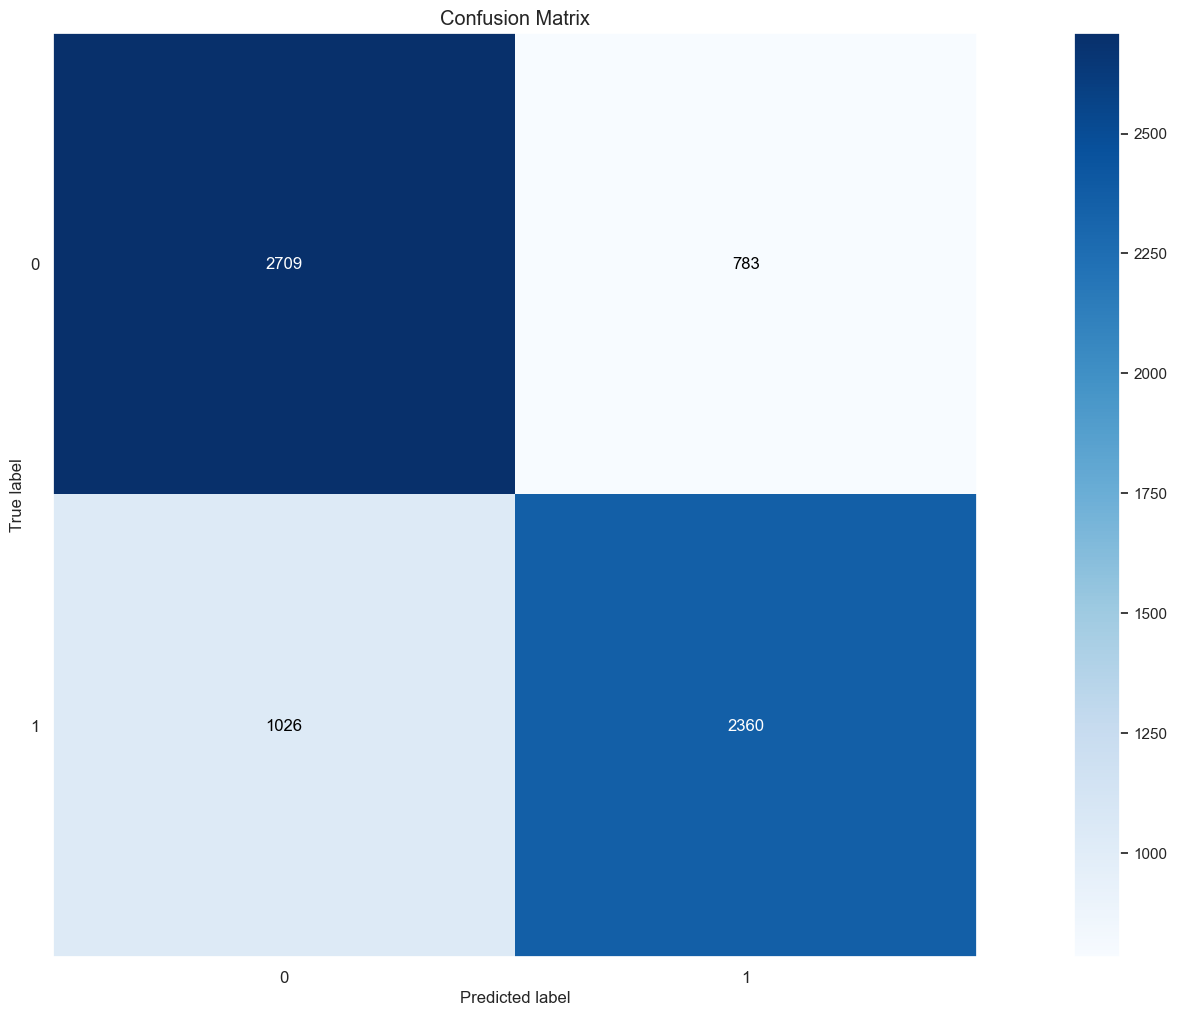

In [144]:
# Classification report
print(m.classification_report(y_test, yhat))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False);

## 7.7. LightGBM

Accuracy on training set: 0.741
Accuracy on test set: 0.736


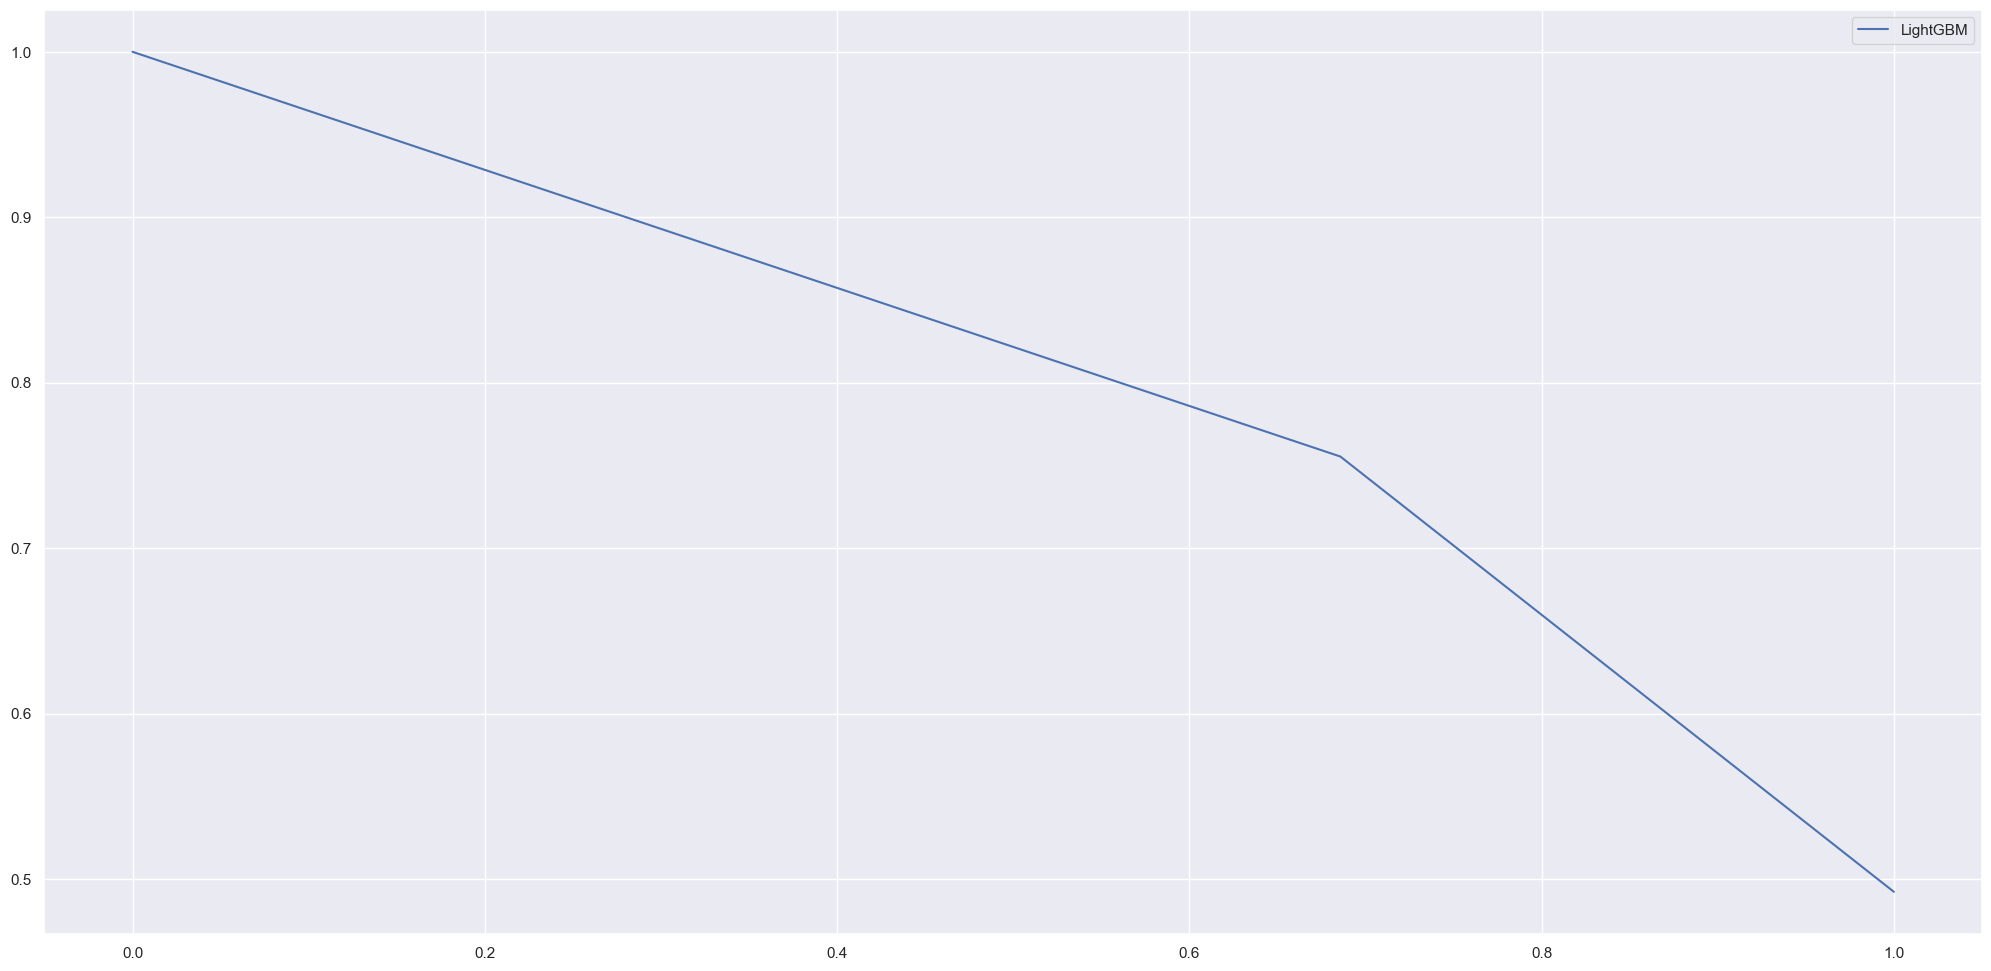

In [145]:
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)
lgbm_model.fit(X_train, y_train)
yhat = lgbm_model.predict(X_test)

# performance
lgbm = ml_performance('LightGBM', y_test, yhat)
print("Accuracy on training set: {:.3f}".format(lgbm_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(lgbm_model.score(X_test, y_test)))

# Precision-Recall curve
precision, recall, thresholds = m.precision_recall_curve(y_test, yhat)
sns.lineplot(x=recall, y=precision, label='LightGBM');

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      3492
           1       0.76      0.69      0.72      3386

    accuracy                           0.74      6878
   macro avg       0.74      0.74      0.73      6878
weighted avg       0.74      0.74      0.74      6878



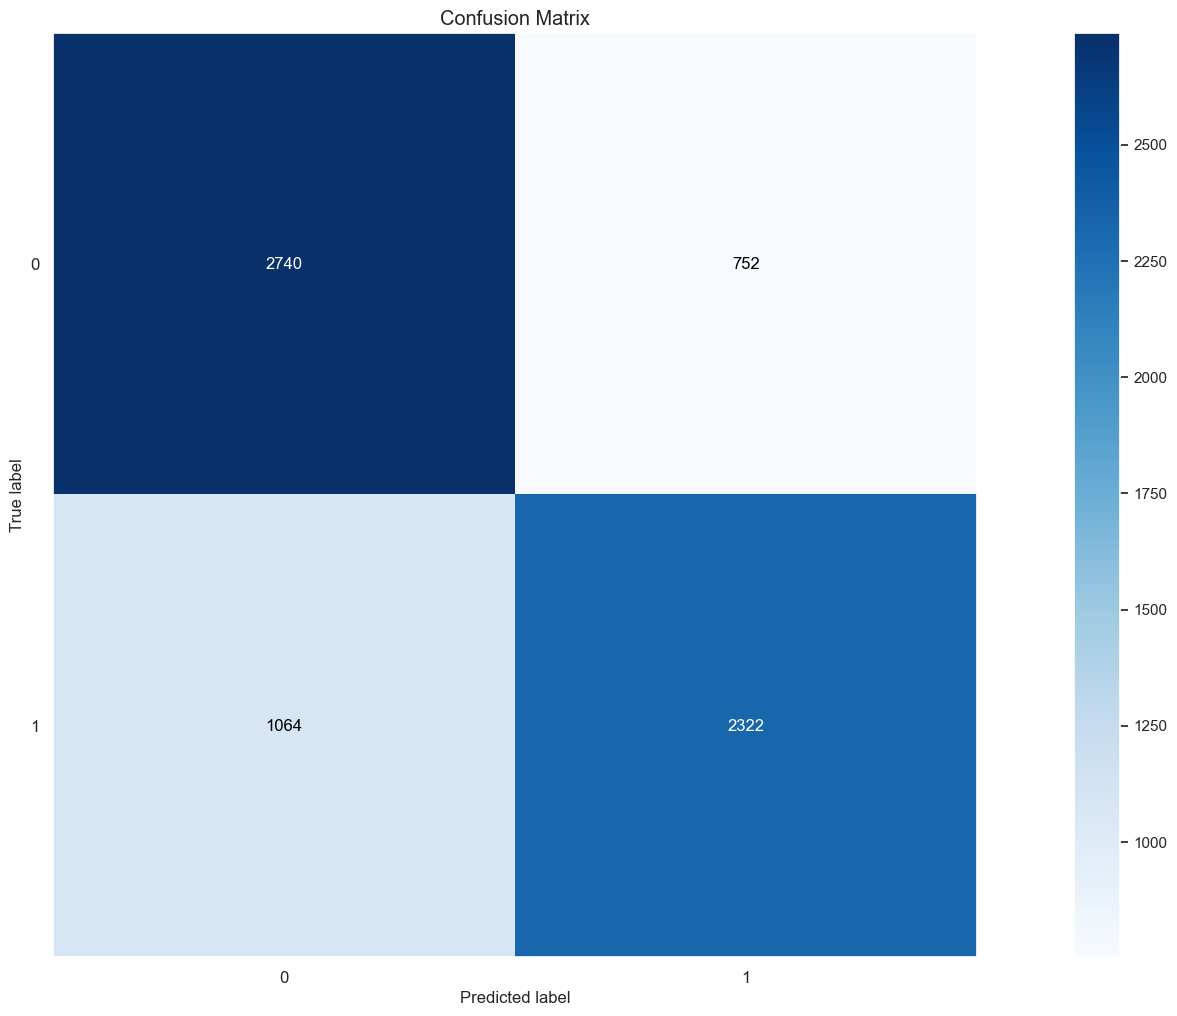

In [146]:
# Classification report
print(m.classification_report(y_test, yhat))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat, normalize=False);

## 7.8. Performance

### 7.8.1. Single Performance

In [147]:
modelling_result = pd.concat([baseline, 
                            lr, 
                            s_v_m, 
                            k_nn, 
                            dtc, 
                            rfc, 
                            xgb, 
                            lgbm]).sort_values('F1-Score')
modelling_result

,Model Name,Accuracy,Kappa,Precision,Recall,ROC,F1-Score
0,Average Model,0.49,-0.02,0.48,0.49,0.49,0.49
0,Random Forest,0.68,0.37,0.69,0.66,0.68,0.67
0,k-Nearest Neighbors,0.69,0.38,0.69,0.67,0.69,0.68
0,Support Vector Machine,0.73,0.46,0.74,0.68,0.73,0.71
0,Logistic Regression,0.73,0.46,0.75,0.68,0.73,0.71
0,LightGBM,0.74,0.47,0.76,0.69,0.74,0.72
0,XGBoost,0.74,0.47,0.75,0.70,0.74,0.72
0,Decision Tree,0.73,0.47,0.74,0.70,0.73,0.72


In [148]:
lgbm_model

LGBMClassifier(random_state=42)

In [149]:
cross_val_score(lgbm_model, X_train, y_train, cv = 5)

array([0.73645947, 0.72328244, 0.72691748, 0.73109778, 0.73182479])

### 7.8.2. Roc Curve

Baseline: ROC AUC=0.500
Logistic Regression: ROC AUC=0.789
Support Vector Machine: ROC AUC=0.789
k-Nearest Neighbors: ROC AUC=0.789
Decision Tree: ROC AUC=0.789
RandomForestClassifier: ROC AUC=0.736
LightGBM: ROC AUC=0.801
XGBoostClassifier: ROC AUC=0.798


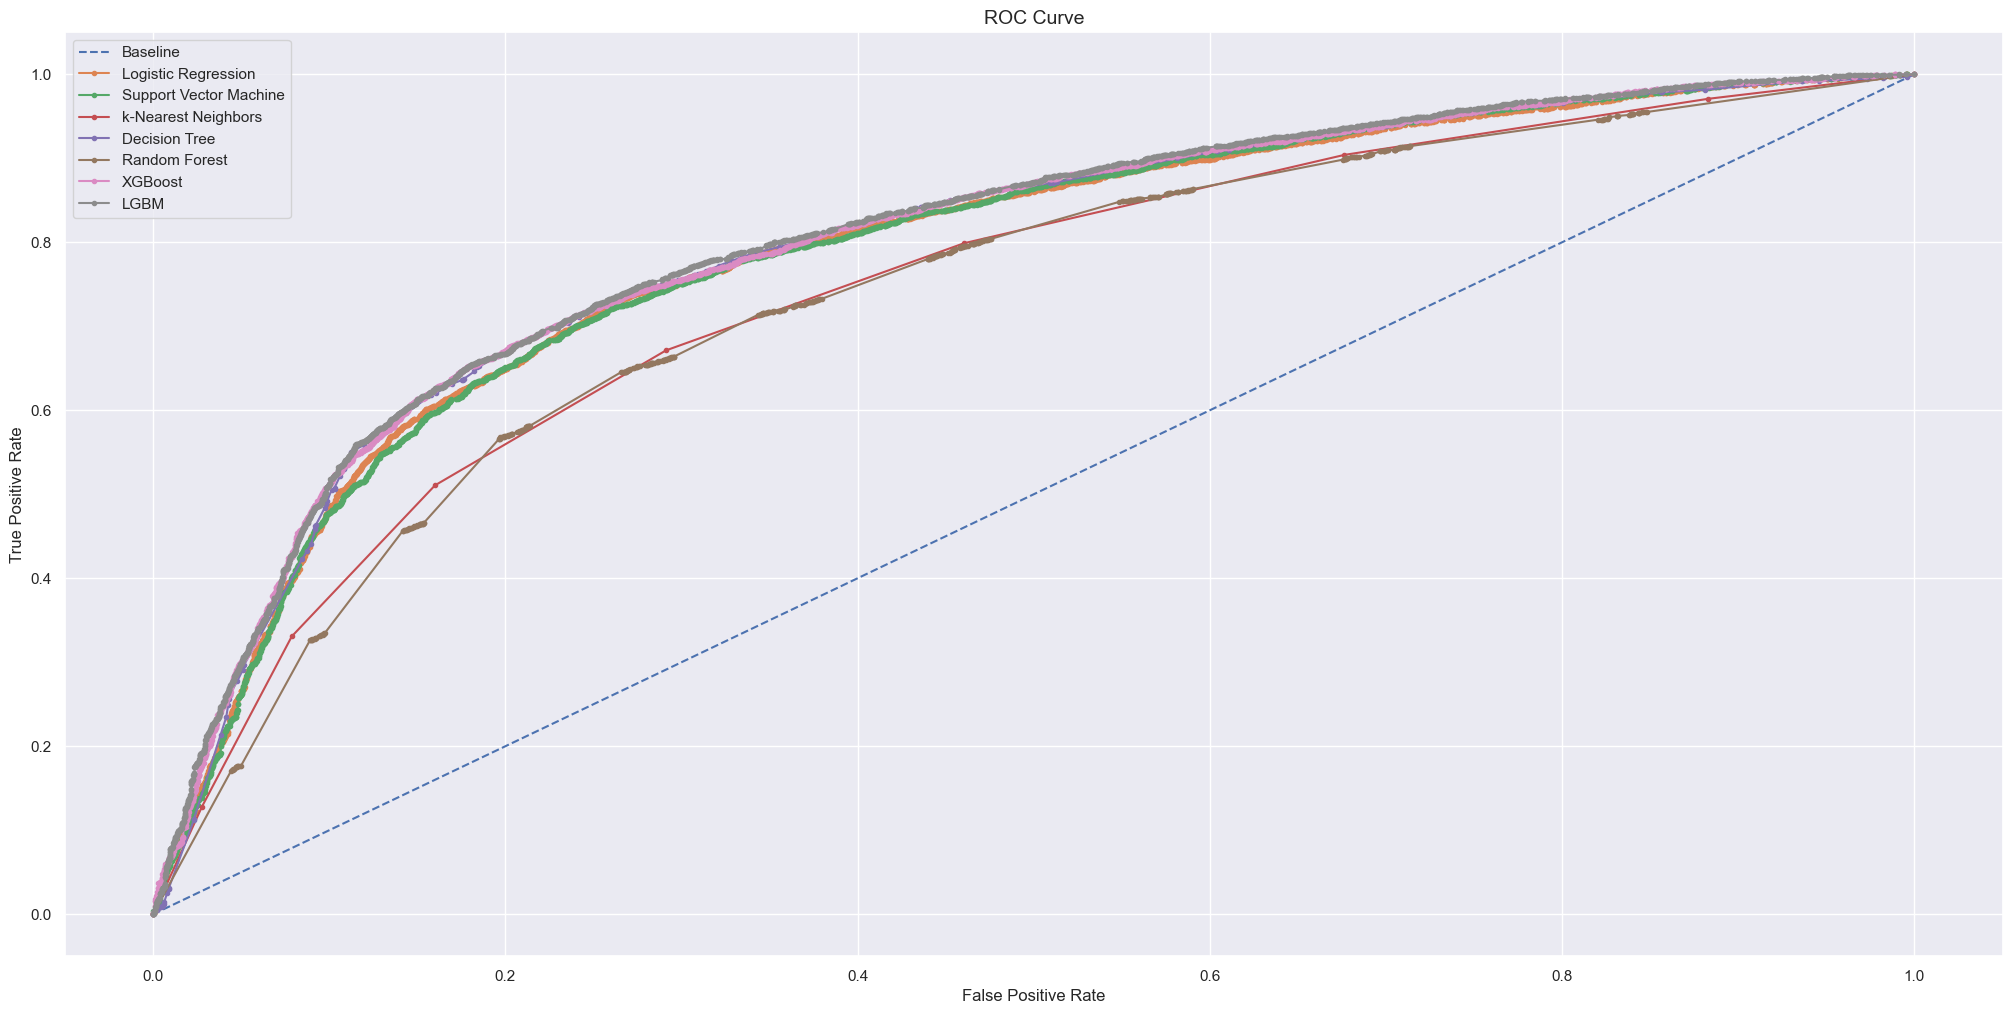

In [150]:
lr_probs = logreg.predict_proba(X_test)
svm_probs = svm.predict_proba(X_test)
knn_probs = knn.predict_proba(X_test)
dt_probs = dt.predict_proba(X_test)
lgbm_probs = lgbm_model.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)
knn_probs = knn.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)

# keep probabilities for the positive outcome only
baseline_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_probs[:, 1]
svm_probs = svm_probs[:, 1]
knn_probs = knn_probs[:, 1]
dt_probs = dt_probs[:, 1]
lgbm_probs = lgbm_probs[:, 1]
xgb_probs = xgb_probs[:, 1]
rf_probs = rf_probs[:, 1]

# calculate scores
baseline_auc = m.roc_auc_score(y_test, baseline_probs)
lr_auc = m.roc_auc_score(y_test, lr_probs)
svm_auc =m.roc_auc_score(y_test, lr_probs)
knn_auc = m.roc_auc_score(y_test, lr_probs)
dt_auc = m.roc_auc_score(y_test, lr_probs)
lgbm_auc = m.roc_auc_score(y_test, lgbm_probs)
xgb_auc = m.roc_auc_score(y_test, xgb_probs)
rf_auc = m.roc_auc_score(y_test, rf_probs)

# summarize scores
print('Baseline: ROC AUC=%.3f' % (baseline_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))
print('Support Vector Machine: ROC AUC=%.3f' % (svm_auc))
print('k-Nearest Neighbors: ROC AUC=%.3f' % (knn_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (rf_auc))
print('LightGBM: ROC AUC=%.3f' % (lgbm_auc))
print('XGBoostClassifier: ROC AUC=%.3f' % (xgb_auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = m.roc_curve(y_test, baseline_probs)
lr_fpr, lr_tpr, _ = m.roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = m.roc_curve(y_test, svm_probs)
knn_fpr, knn_tpr, _ = m.roc_curve(y_test, knn_probs)
dt_fpr, dt_tpr, _ = m.roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = m.roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = m.roc_curve(y_test, xgb_probs)
lgbm_fpr, lgbm_tpr, _ = m.roc_curve(y_test, lgbm_probs)

# plots the roc curve for the model
plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vector Machine')
plt.plot(knn_fpr, knn_tpr, marker='.', label='k-Nearest Neighbors')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')

# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show()


# 8.0. Hyperparameter Fine Tunning

In [151]:
# param_grid = {
#     "boosting_type": ["gbdt", "dart"],
#     "num_leaves": [31, 63, 127],
#     "max_depth": [2, 3, 4],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "n_estimators": [100, 200, 300],
# }
# 
# # Define the cross-validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# 
# # Define the scoring metric
# f1_scorer = m.make_scorer(m.f1_score, average="macro")
# 
# # Perform grid search with cross-validation
# grid = GridSearchCV(lgbm_model, param_grid, cv=cv, scoring=f1_scorer)
# grid.fit(X_train, y_train)
# 
# # Print the best parameters and F1-score
# print("Best parameters:", grid.best_params_)
# print("Best F1-score:", grid.best_score_)
# 
# # Evaluate the best model on the validation set
# y_val_pred = grid.predict(X_val)
# f1 = m.f1_score(y_val, y_val_pred, average='macro')
# print("F1-score on validation set:", f1)

In [152]:
param_tuned = {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}

In [153]:
# model
lgbm_tuned = LGBMClassifier(boosting_type = param_tuned['boosting_type'],
                            learning_rate = param_tuned['learning_rate'],
                            max_depth = param_tuned['max_depth'],
                            n_estimators = param_tuned['n_estimators'],
                            num_leaves = param_tuned['num_leaves'],
                            random_state=42, n_jobs= -1).fit(X_train, y_train)

# prediction
yhat_lgbm_tuned = lgbm_tuned.predict(X_test)

# performance
lgbm_result_tuned = ml_performance('LightGBM', y_test, yhat = yhat_lgbm_tuned)
lgbm_result_tuned

,Model Name,Accuracy,Kappa,Precision,Recall,ROC,F1-Score
0,LightGBM,0.74,0.48,0.75,0.70,0.74,0.72


In [154]:
scores = cross_val_score(lgbm_tuned, X_test, y_test, cv=5, scoring='precision')
print("Cross-validated Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Precision: 0.75 (+/- 0.03)


In [155]:
scores = cross_val_score(lgbm_tuned, X_test, y_test, cv=5, scoring='f1_macro')
print("Cross-validated F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated F1-score: 0.73 (+/- 0.02)


# 9.0. Convert Model Performance to Business Values


In [156]:
accuracy = cross_val_score(lgbm_tuned, X_train, y_train, cv=5)
print("Cross-validated Train Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))

accuracy_cv = cross_val_score(lgbm_tuned, X_test, y_test, cv=5)
print("Cross-validated Test Accuracy: %0.2f (+/- %0.2f)" % (accuracy_cv.mean(), accuracy_cv.std() * 2))

Cross-validated Train Accuracy: 0.73 (+/- 0.01)
Cross-validated Test Accuracy: 0.73 (+/- 0.02)


In [157]:
precision = cross_val_score(lgbm_tuned, X_train, y_train, cv=5, scoring='precision')
print("Cross-validated Train Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))

precision_cv = cross_val_score(lgbm_tuned, X_test, y_test, cv=5, scoring='precision')
print("Cross-validated Test Precision: %0.2f (+/- %0.2f)" % (precision_cv.mean(), precision_cv.std() * 2))

Cross-validated Train Precision: 0.75 (+/- 0.01)
Cross-validated Test Precision: 0.75 (+/- 0.03)


In [158]:
f1_score = cross_val_score(lgbm_tuned, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-validated Train F1-score: %0.2f (+/- %0.2f)" % (f1_score.mean(), f1_score.std() * 2))

f1_score_cv = cross_val_score(lgbm_tuned, X_test, y_test, cv=5, scoring='f1_macro')
print("Cross-validated Test F1-score: %0.2f (+/- %0.2f)" % (f1_score_cv.mean(), f1_score_cv.std() * 2))

Cross-validated Train F1-score: 0.73 (+/- 0.01)
Cross-validated Test F1-score: 0.73 (+/- 0.02)


Worst Case Scenario = 72% accurate ~ US$ 2500

Best Case Scenario = 78% accurate ~ US$ 3000

In [159]:
result = ['LGBM Classifier', "$ {:,.2f}".format(2500*len(df_raw)), "$ {:,.2f}".format(2750*len(df_raw)), "$ {:,.2f}".format(3000*len(df_raw))]
df_business = pd.DataFrame(result).T
df_business.columns = ["Model","Worst Scenario", "Average Scenario", "Best Scenario"]
df_business

,Model,Worst Scenario,Average Scenario,Best Scenario
0,LGBM Classifier,"$ 175,000,000.00","$ 192,500,000.00","$ 210,000,000.00"


In [165]:
pickle.dump(lgbm_tuned, open('../models/lgbm_cardio.pkl', 'wb'))